## 주제 :  코로나 일일 확진자와 영양제/다이어트식품 검색량에 관계가 있는지 알아보자 

### 세부 가설 1 : 코로나 일일 확진자 수 증가 후에는 건강을 우려한 사람들로 인하여 영양제 검색량도 증가할 것이다 
### 
### 세부 가설 2 : 코로나 확진자 수의 증가 추세가 완화된 기간에는 다이어트 식품 검색량이 증가할 것이다  

#### 설정 

In [1]:
import numpy as np
import pandas as pd
import copy
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/NanumGothic.ttf").get_name()
rc('font', family=font_name)

In [2]:
%matplotlib inline
%config inLineBackend.figure_format = 'retina' 

### 기초작업 
#### 기본 파일 불러오기

In [3]:

#전체 검색량 데이터 가져오기 
df_result = pd.read_csv("data/search_result.csv", encoding="utf-8-sig",index_col=0)
#코로나 확진자 데이터 가져오기 
covid = pd.read_csv("data/Covid19InfState.csv", encoding="utf-8-sig")
#성별/연령별 일간 검색량 데이터 가져오기

f_kid = pd.read_csv("data/df2_f_kid.csv", encoding="utf-8-sig", index_col=0) #여성 미성년자
f_20 = pd.read_csv("data/df2_f_20.csv", encoding="utf-8-sig", index_col=0) #여성 20대
f_30 = pd.read_csv("data/df2_f_30.csv", encoding="utf-8-sig", index_col=0) #여성 30대
f_40 = pd.read_csv("data/df2_f_40.csv", encoding="utf-8-sig", index_col=0) #여성 40대
f_senior = pd.read_csv("data/df2_f_senior.csv", encoding="utf-8-sig", index_col=0) #여성 50대이상
m_kid = pd.read_csv("data/df2_m_kid.csv", encoding="utf-8-sig", index_col=0) #남성 미성년자
m_20 = pd.read_csv("data/df2_m_20.csv", encoding="utf-8-sig", index_col=0) #남성 20대
m_30 = pd.read_csv("data/df2_m_30.csv", encoding="utf-8-sig", index_col=0) #남성 30대
m_40 = pd.read_csv("data/df2_m_40.csv", encoding="utf-8-sig", index_col=0) #남성 40대
m_senior = pd.read_csv("data/df2_m_senior.csv", encoding="utf-8-sig", index_col=0) #남성 50대이상 


#### 1. 전체 검색량 데이터 처리 (df_result)
#### 1-1. 상대값에서 절댓값으로 변환

In [4]:
df_realvalue = df_result.iloc[:,1:]
scaler = 2258.17661650362
df_realvalue = round(df_realvalue*scaler, 1)
df_realvalue.insert(0, "date", df_result["date"])

#### 1-2. 전체 검색량 데이터 구분
- 현재 검색량 데이터에는 영양제에 해당하는 카테고리와 다이어트식품에 해당하는 카테고리가 다 들어가있음
- 이를 구분하여 두 개의 데이터프레임으로 만드는 과정 
- 기존의 네이버 쇼핑 데이터에서 카테고리 값을 가져와서 해당 카테고리 값이랑 일치하는 것만 남기는 방식으로 처리 
- 이 과정에서, 네이버 데이터랩 크롤링시 제외하였던 카테고리들은 삭제함 

In [5]:
nutrients = pd.read_csv("data/nutrients_data_complete.csv", encoding = "utf_8_sig", index_col = 0)
healthfood = pd.read_csv("data/healthfood_data_complete.csv", encoding = "utf_8_sig", index_col = 0)

In [6]:
#기타 비타민, 기타 영양제, 기타 건강식품은 네이버 데이터랩 검색어에서 제외하였음
#실수로 영양제에도 곤약을 넣어서..ㅎㅎ 제외함 
nut_list = list(nutrients["cate_5"].unique())
nut_list.remove("기타비타민")
nut_list.remove("기타영양제")
nut_list.remove("곤약")

food_list = list(healthfood["cate_4"].unique())
food_list.remove("기타건강식품")

In [7]:
df_nut = df_realvalue[nut_list]
df_nut["date"] = df_realvalue["date"]
df_nut = df_nut.set_index("date")
df_nut["nut_sum"] = df_nut.sum(axis=1)
df_food = df_realvalue[food_list]
df_food["date"] = df_realvalue["date"]
df_food = df_food.set_index("date")
df_food["food_sum"] = df_food.sum(axis=1)

df_nut = df_nut.reset_index()
df_food = df_food.reset_index()

#### 2. 코로나 데이터 처리 (covid)
1. 필요한 컬럼만 가져오기(날짜, 누적확진자 수 ) 
2. 검색량 데이터랑 date 형태 맞추기 
3. 누적확진자수로 일일 확진자 수 구하기 

In [8]:
#필요한 컬럼만 가져오기
#stateDt:날짜, decideCnt:누적 확진자 수 
covid = covid[["stateDt", "decideCnt"]]
covid["stateDt"] = covid.astype(str) 

#covid trend 데이터의 date 형식을 df_nut_2020, df_food_2020과 맞추기 (yyyy-mm-dd)
covid["stateDt"] = covid["stateDt"].apply(lambda x : x[0:4]+"-"+x[4:6]+"-"+x[6:])
covid = covid.rename(columns={"stateDt" : "date"})

In [9]:
# 누적 확진자수 decideCnt를 일간 확진자수 daycnt로 변환
# 현재 누적 확진자 수에서 직전 확진자 수를 뺌 
#비정상적인 값 처리 (누적 확진자 수인데 해당일의 다음날보다 많은 이상한 값이 존재해서 이전일, 다음일의 평균으로 처리 )

daycnt = [0]
decidecnt= covid["decideCnt"]
decidecnt.fillna(0)
decidecnt.loc[3] = (decidecnt.loc[2] + decidecnt.loc[4])/2
decidecnt.loc[116] = (decidecnt.loc[115] + decidecnt.loc[117])/2
decidecnt.loc[347] = (decidecnt.loc[346] + decidecnt.loc[348])/2

decidecnt = list(decidecnt)

for i in range(1, len(decidecnt)) : 
    daycnt.append(decidecnt[i] - decidecnt[i-1])

covid["daycnt"] = daycnt 

In [10]:
#### 추가 처리. 2020년 1월 1일부터 보려고 slicing 

In [11]:
#2020년 1월 1일부터 보려고 slicing 함
df_nut_2020 = df_nut[df_nut["date"] >= "2020-01-01"]
df_food_2020 = df_food[df_food["date"] >= "2020-01-01"]

#그리고 total_trend로 합침 
total_trend  = pd.merge(left = df_nut_2020, right = df_food_2020, on ="date")
total_trend = pd.merge(left=total_trend, right=covid[["date", "daycnt"]], 
                       on="date", how="outer")

#### 3. 성별, 연령별 검색량 데이터 처리 (f_kid ~ m_senior)
#### 


#### 3-1. 성별, 연령별 검색량의 상댓값 -> 절댓값 변환 

- 개별 데이터프레임의 1열부터 스케일러를 곱해주는 함수 생성 (0열은 날짜이므로 곱하지 않음) 
- 절댓값 변환을 위해 곱해줄 숫자(스케일러)를 dict_scaler 변수에 딕셔너리 형태로 넣고 
- 반복문으로 데이터프레임 리스트에서 데이터프레임을, 딕셔너리에서 스케일러를 순차적으로 가져와 곱해주도록 함
- 스케일러는 월간 검색량(네이버 광고주용 검색광고 시스템 활용) 과 네이버 트렌드랩에서 크롤링한 상댓값을 비교하여 아래와 같이 추산함
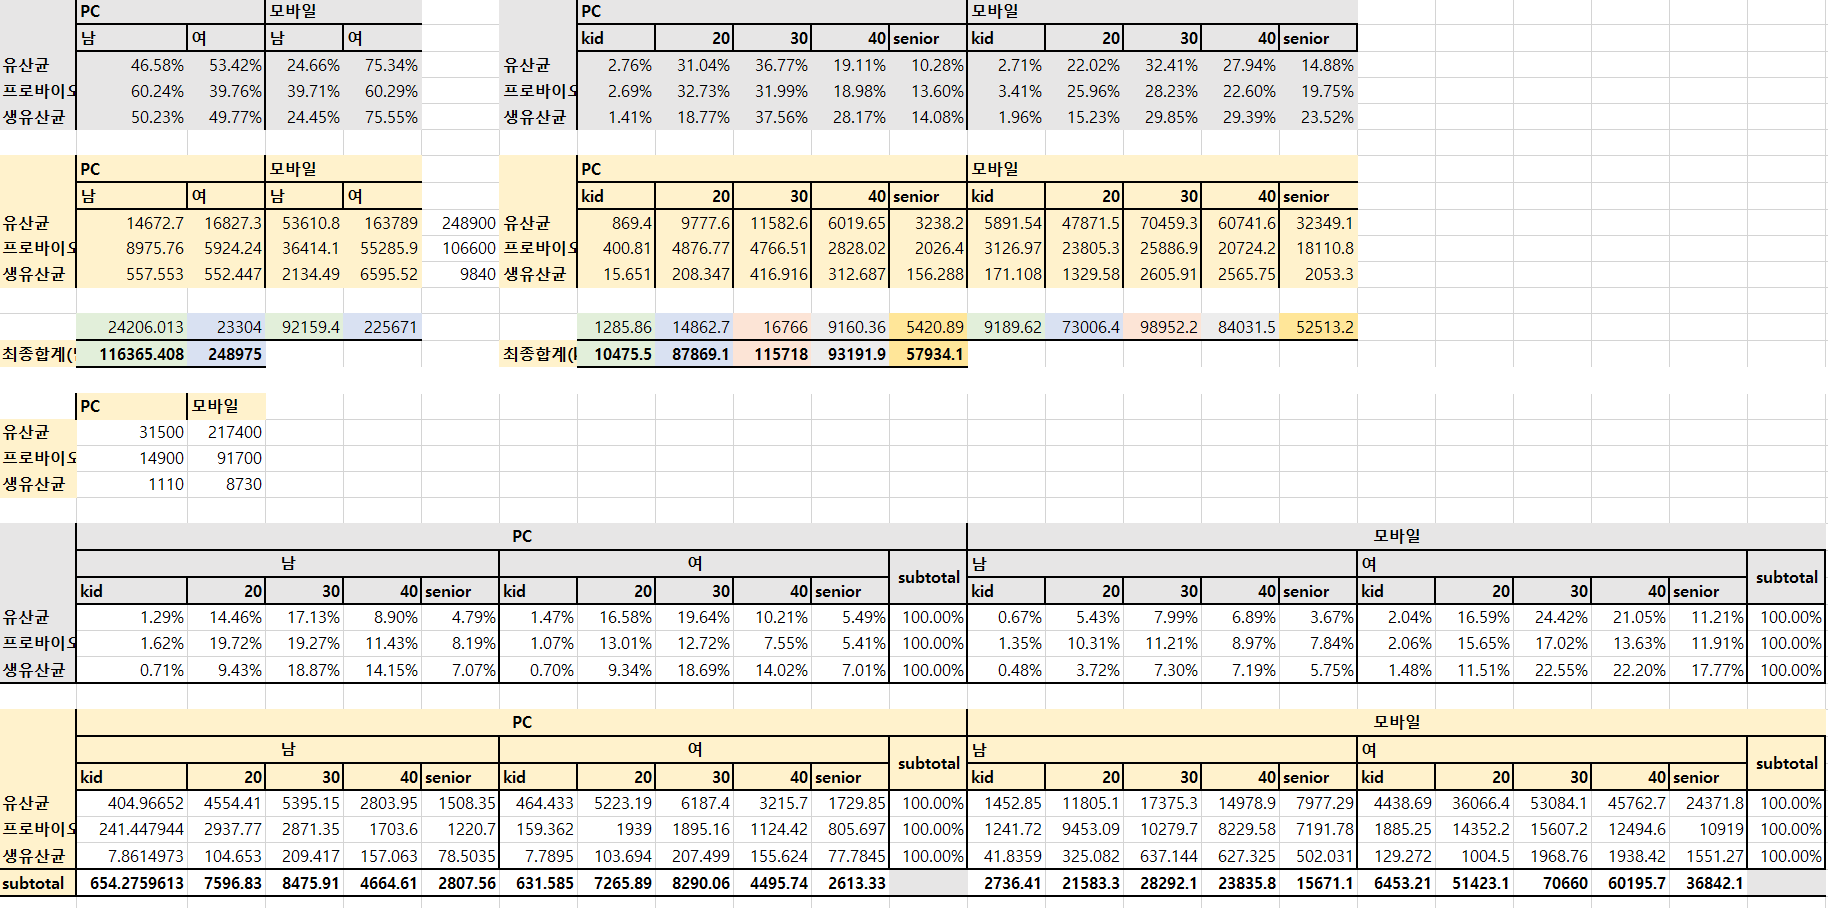

In [12]:

dict_scaler = [{"남성_미성년자":56.86732781},
               {"남성_20대":471.5872413},
               {"남성_30대":480.9030332},
               {"남성_40대":191.1705019},
               {"남성_50대이상":54.65492228},
               {"여성_미성년자":55.79250648}, 
               {"여성_20대":465.8577269},
               {"여성_30대":553.5560949}, 
               {"여성_40대":293.2608899},
               {"여성_50대이상":122.0345283}] 



In [13]:
def scaler(dataframe, scale) : 
    dataframe.iloc[:,1:] = dataframe.iloc[:,1:] * scale
    return dataframe

In [14]:

file_list = [m_kid, m_20, m_30, m_40, m_senior, f_kid, f_20, f_30, f_40, f_senior]
key_list = ["남성_미성년자", "남성_20대", "남성_30대", "남성_40대", "남성_50대이상", 
            "여성_미성년자", "여성_20대", "여성_30대", "여성_40대", "여성_50대이상"]

for index, dataframe in enumerate(file_list):
    scale = dict_scaler[index].get(key_list[index])
    scaler(dataframe, scale)


#### 3-2. 성별, 연령별 검색량을 합친 전체 데이터 프레임 생성 
- 개별 데이터프레임을 합치기 위한 데이터프레임 형태로 변형
- 하나의 데이터프레임으로 merge

In [15]:
#합치기 위한 데이터 프레임 형태로 변형하는 함수 생성 
#컬럼을 date, cate_5, 그리고 남성_미성년자 ~ 여성_50대 이상으로 만들기

file_list = [m_kid, m_20, m_30, m_40, m_senior, f_kid, f_20, f_30, f_40, f_senior]
name_list = ["남성_미성년자", "남성_20대", "남성_30대", "남성_40대", "남성_50대이상", 
            "여성_미성년자", "여성_20대", "여성_30대", "여성_40대", "여성_50대이상"]

def preprocess(dataframe) : 
    dataframe = dataframe.set_index("date")
    dataframe = pd.DataFrame(dataframe.stack().reset_index())
    
    return dataframe

In [16]:
#개별 데이터 프레임에 함수를 적용하고 

df_m_kid = preprocess(m_kid)
df_m_20 = preprocess(m_20)
df_m_30 = preprocess(m_30)
df_m_40 = preprocess(m_40)
df_m_senior = preprocess(m_senior)
df_f_kid = preprocess(f_kid)
df_f_20 = preprocess(f_20)
df_f_30 = preprocess(f_30)
df_f_40 = preprocess(f_40)
df_f_senior = preprocess(f_senior)


In [17]:
#df_total이라는 데이터 프레임으로 합치기

df_total = pd.DataFrame()
df_total = pd.merge(left=df_m_kid, right=df_m_20, how="outer", on=["date", "level_1"] )
df_total = pd.merge(left=df_total, right=df_m_30, how="outer", on=["date", "level_1"] )
df_total = pd.merge(left=df_total, right=df_m_40, how="outer", on=["date", "level_1"] )
df_total = pd.merge(left=df_total, right=df_m_senior, how="outer", on=["date", "level_1"] )
df_total = pd.merge(left=df_total, right=df_f_kid, how="outer", on=["date", "level_1"] )
df_total = pd.merge(left=df_total, right=df_f_20, how="outer", on=["date", "level_1"] )
df_total = pd.merge(left=df_total, right=df_f_30, how="outer", on=["date", "level_1"] )
df_total = pd.merge(left=df_total, right=df_f_40, how="outer", on=["date", "level_1"] )
df_total = pd.merge(left=df_total, right=df_f_senior, how="outer", on=["date", "level_1"] )

#컬럼명 재설정 
df_total.columns = ["date", "cate_5", "남성_미성년자", "남성_20대", "남성_30대", "남성_40대", "남성_50대이상", 
            "여성_미성년자", "여성_20대", "여성_30대", "여성_40대", "여성_50대이상"]

In [18]:
df_total["date"] = df_total["date"].astype(str)

In [19]:
#df_total.to_csv("total_search.csv", encoding = "utf-8-sig")

#### 3-3. 성별, 연령별 검색량의 전체 데이터 프레임(df_total)을 영양제와 다이어트식품으로 구분하기  
- 앞서 생성한 카테고리 리스트(nut_list, food_list) 변수 사용 

In [20]:
nut_total = df_total[df_total["cate_5"].isin(nut_list)]
food_total = df_total[df_total["cate_5"].isin(food_list)]

### 시각화
#### 0. 영양제 총 검색량 / 다이어트식품 총 검색량의 성별, 연령 분포 
- 영양제의 2018년 이후 총 검색량의 성별, 연령 분포 
- 다이어트식품의 2018년 이후 총 검색량의 성별, 연령 분포
- 영양제, 다이어트 식품의 2018년 이후 총 검색량의 성별, 연령 분포

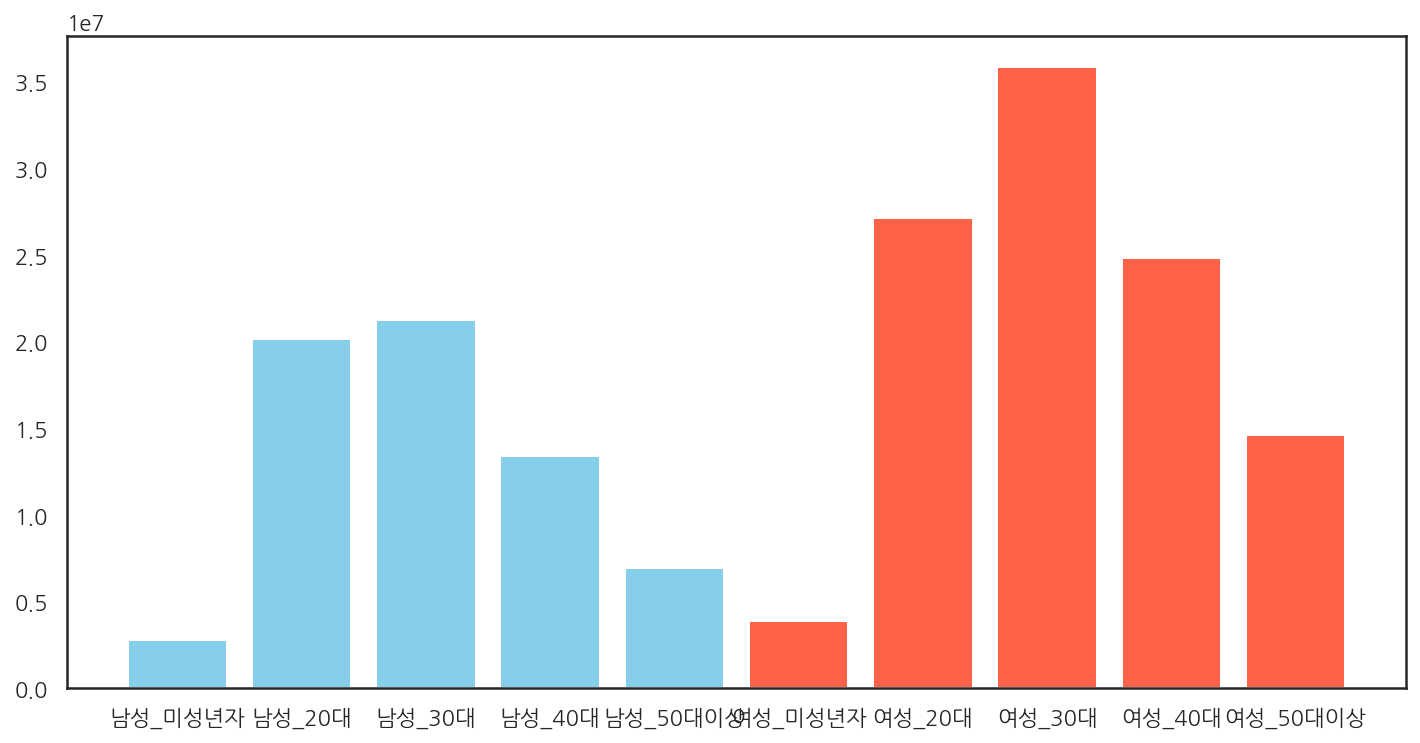

In [21]:
#영양제 
plt.figure(figsize = (12, 6))
plt.bar(list(nut_total.columns[2:7]), nut_total.iloc[:,2:7].sum(axis = 0), color = "skyblue") #남성의 영양제 총검색량        
plt.bar(list(nut_total.columns[7:]), nut_total.iloc[:,7:].sum(axis = 0), color = "tomato") #여성의 영양제 총검색량

plt.show()

<BarContainer object of 5 artists>

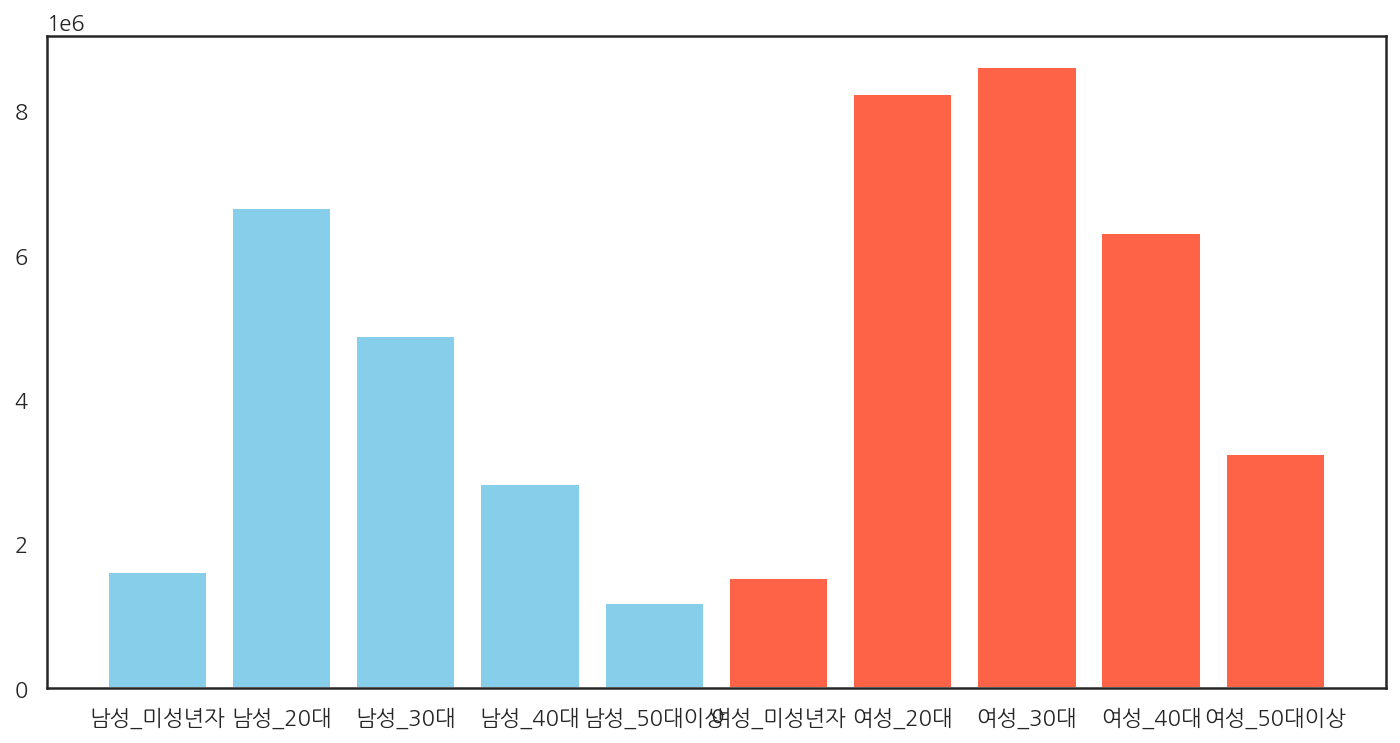

In [22]:
#다이어트식품
plt.figure(figsize = (12, 6))
plt.bar(list(food_total.columns[2:7]), food_total.iloc[:,2:7].sum(axis = 0), color = "skyblue") #남성의 다이어트식품 총검색량        
plt.bar(list(food_total.columns[7:]), food_total.iloc[:,7:].sum(axis = 0), color = "tomato") #여성의 다이어트식품 총검색량

In [23]:
#같이 보기 
search_amount_1 = pd.DataFrame(nut_total.iloc[:, 2:].sum())
search_amount_1["cate"] = "영양제"
search_amount_2 = pd.DataFrame(food_total.iloc[:, 2:].sum())
search_amount_2["cate"] = "다이어트식품"
search_amount = pd.concat([search_amount_1, search_amount_2], axis=0)
search_amount.reset_index(inplace = True)
search_amount = search_amount.rename(columns={0:"amount"})

<AxesSubplot:xlabel='index', ylabel='amount'>

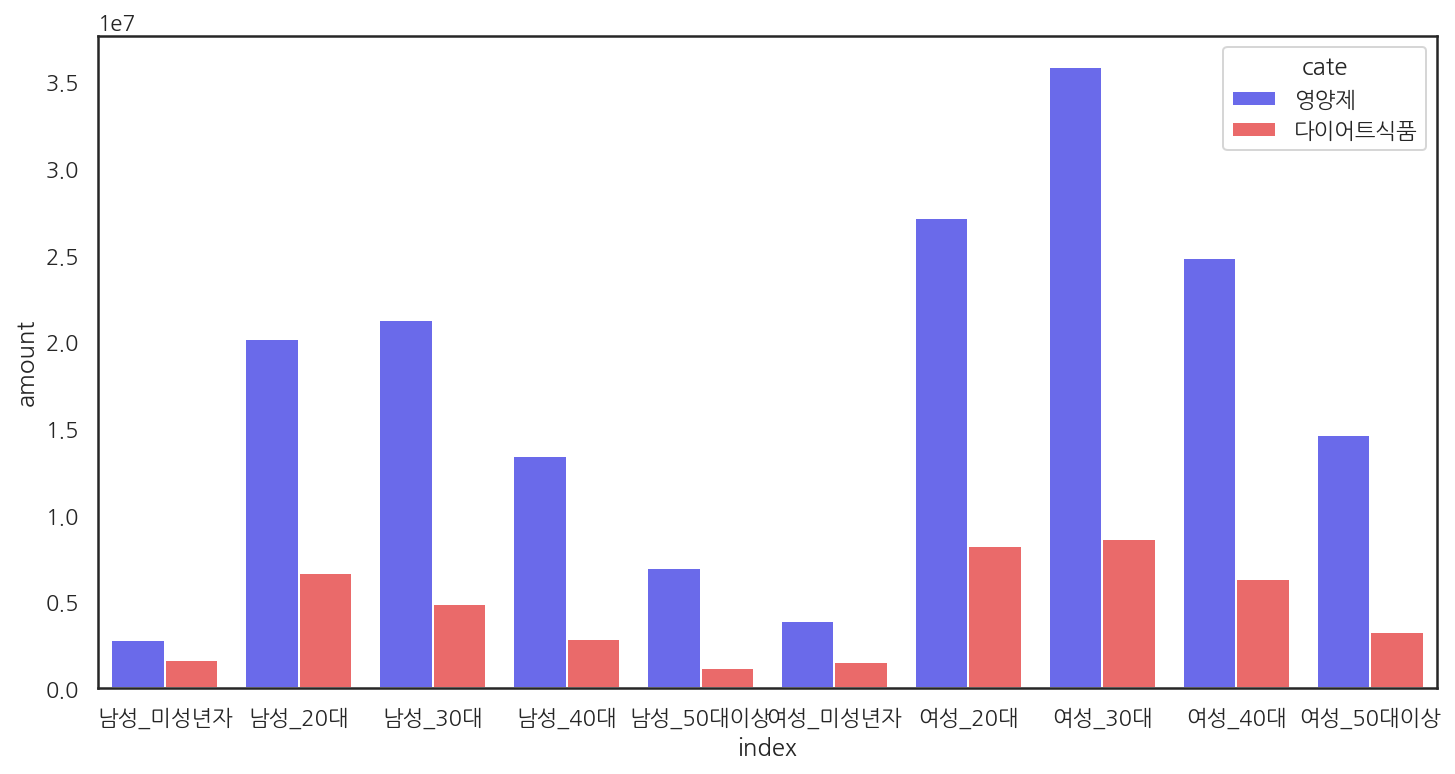

In [24]:
plt.figure(figsize=(12, 6))
sns.barplot(data=search_amount, x="index", y="amount", hue="cate", palette="seismic") 

#### 1. 영양제 총 검색량 / 다이어트식품 총 검색량과 코로나 일일 확진자 수의 그래프 그리기 
- 왼쪽 : 영양제 - 코로나  /  오른쪽 : 다이어트식품 - 코로나

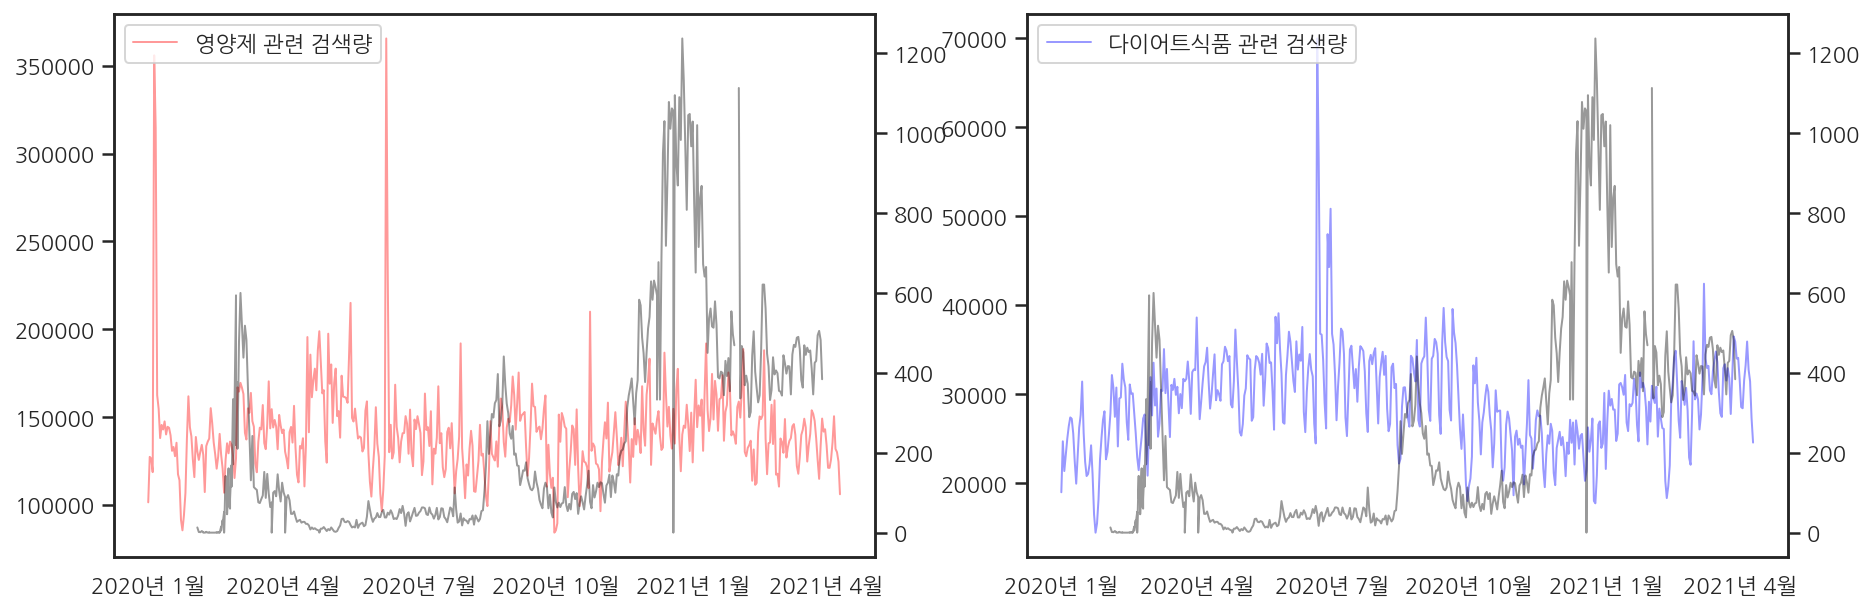

In [25]:
sns.set_style("white")
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'NanumGothic'

plt.figure(figsize=(15,5))

ax1 = plt.subplot(121)
ax2 = ax1.twinx()
plot1 = ax1.plot(total_trend["date"], total_trend["nut_sum"], "-", color='red', lw=1, alpha=0.4, 
                 label = "영양제 관련 검색량")
plot2 = ax2.plot(total_trend["date"], total_trend["daycnt"], "-", color='black', lw=1, alpha=0.4)
plt.xticks(["2020-01-01", "2020-04-01","2020-07-01", "2020-10-01","2021-01-01","2021-04-01"],
          labels = ["2020년 1월","2020년 4월","2020년 7월","2020년 10월",
                    "2021년 1월","2021년 4월"])
ax1.legend(loc = "upper left")

ax3 = plt.subplot(122)
ax4 = ax3.twinx()
plot3 = ax3.plot(total_trend["date"], total_trend["food_sum"], "-", color='blue', lw=1, alpha=0.4,
                label = "다이어트식품 관련 검색량")
plot4 = ax4.plot(total_trend["date"], total_trend["daycnt"], "-", color='black', lw=1, alpha=0.4)
plt.xticks(["2020-01-01", "2020-04-01","2020-07-01", "2020-10-01","2021-01-01","2021-04-01"],
          labels = ["2020년 1월","2020년 4월","2020년 7월","2020년 10월",
                    "2021년 1월","2021년 4월"])
ax3.legend(loc = "upper left")    

plt.show()

#### 2. 세부 카테고리별 검색량 - 코로나 일일 확진자 수 그래프 그리기 
- trend_graph : 검색량을 조회하고 싶은 세부 카테고리를 리스트형으로 넣으면 그래프를 그려주는 함수 
- (여기서 조회되는 검색량은 해당 카테고리에 대한 검색량으로, 성별/연령에 대한 구분이 없음) 

In [26]:
def trend_graph(catenames) :
    sns.set_style("white")
    plt.rcParams['axes.unicode_minus'] = False
    plt.rcParams['font.family'] = 'NanumGothic'

    fig = plt.figure(figsize=(15,5))
    ax1 = fig.add_subplot()
      
    for i, value in enumerate(catenames) : 
        plot1 = ax1.plot(total_trend["date"], total_trend[value], "-", lw=1, alpha=1, label = f"{value}")
        ax1.legend(loc = "upper left")
    
    ax2 = ax1.twinx()
    plot2 = ax2.plot(total_trend["date"], total_trend["daycnt"], "-", color='red', lw=1, alpha=0.7, label = "코로나 일일 확진자")
    plt.xticks(["2020-01-01", "2020-04-01","2020-07-01", "2020-10-01","2021-01-01","2021-04-01"],
          labels = ["2020년 1월","2020년 4월","2020년 7월","2020년 10월", "2021년 1월","2021년 4월"])
    ax2.legend(loc = "upper right")
    plt.show()

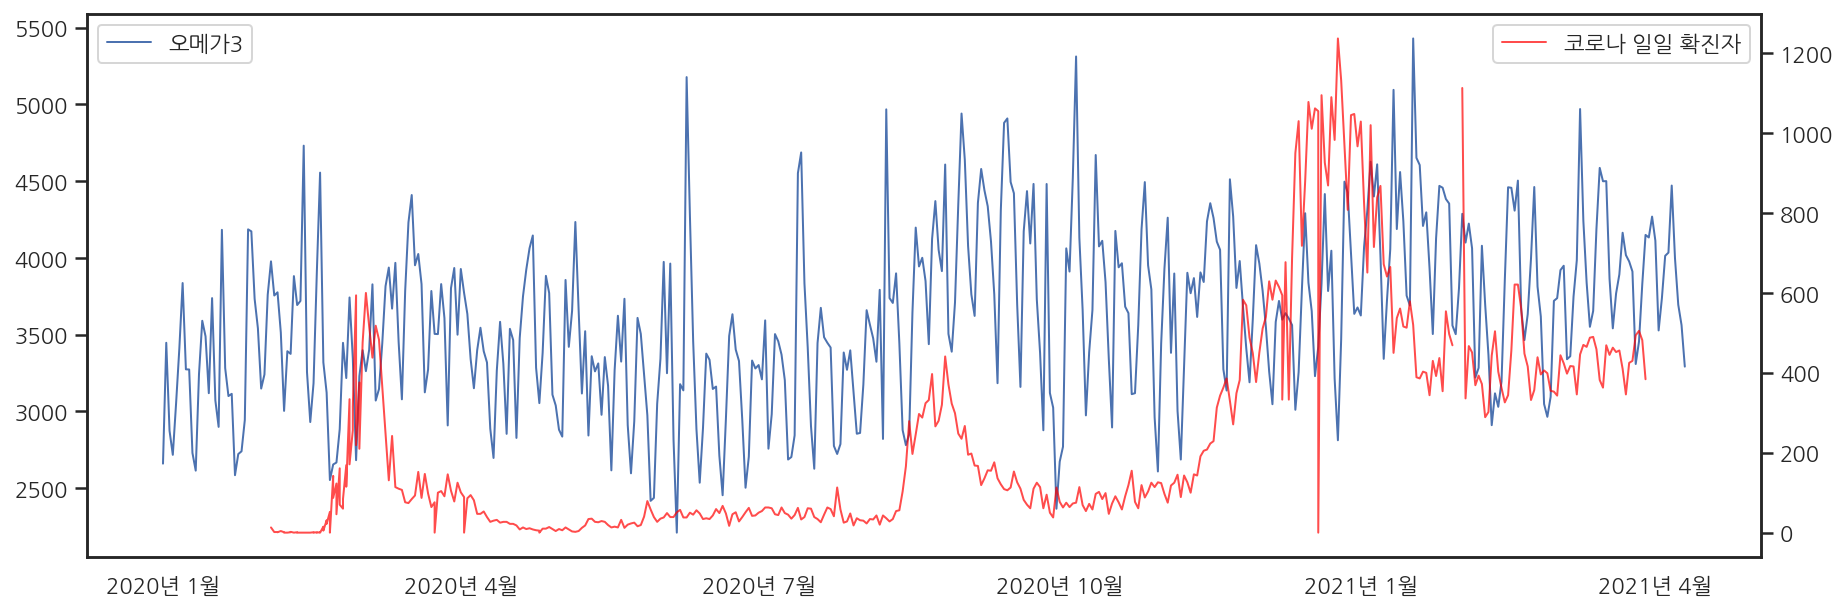

In [27]:
trend_graph(["오메가3"]) ## 여기에 리스트 형태로 카테고리를 넣어주세요 

In [28]:
total_trend.columns ## << 카테고리 목록을 확인하려면 이쪽 

Index(['date', '수면보조제', '아르기닌(아미노산)', '효소', '은행추출물', '초록입홍합', '헤모힘', '타트체리',
       '매스틱', '구연산', '마카', '초유단백질', '양태반', '아미노산', '베타카로틴', '엘더베리', '커큐민',
       '석류추출물', '퀘르세틴', '기타식물추출물', '크랜베리', '베타인 HCL', '숙취해소제', '요오드', '라이코펜',
       '나토키나제', '노니', '마늘', '타우린', '폴리페놀', '대구 간유', '녹용/녹혈', 'SAMe', '프로바이오틱스',
       '밀크씨슬', '멀티비타민', '오메가3', '크릴오일', '비타민C', '환자식/영양보충식', '루테인', '홍삼',
       '프리바이오틱스', '마그네슘', '엽산', '프로폴리스', '폴리코사놀', '비타민B', '기타건강보조식품', '칼슘',
       '알로에정/겔', '비타민D', '코큐텐', '철분', '보스웰리아', '효모', '스피루리나', '아연', '키토산',
       '쏘팔메토', '글루코사민', '비오틴', '감마리놀렌산', 'MSM', '칼륨', '건강분말', '클로렐라', '셀레늄',
       '헛개나무', '건강음료', '로얄제리', '비타민A', '스쿠알렌', '건강환/정', '석류즙', '기타건강즙', '꿀',
       '비타민E', 'nut_sum', '콜라겐', '기타다이어트식품', '뷰티푸드', '헬스보충제', '곤약쌀', '다이어트차',
       '곤약젤리', '식이섬유', '가르시니아', '기타곤약가공품', '다이어트바', '잔티젠', '레몬밤', 'CLA',
       '히알루론산', '카테킨', '와일드망고', '곤약', 'food_sum', 'daycnt'],
      dtype='object')

#### 3. 코로나19 일간 확진자와 연령별/성별별 검색량 그래프 그리기 
- 영양제 / 다이어트식품을 구분하여 그리기 



In [29]:
nut_search = nut_total.groupby("date").sum().reset_index()
nut_search_2020 = nut_search[nut_search["date"] >= "2020-01-01"]
nut_search_2020["date"] = pd.to_datetime(nut_search_2020["date"])

food_search = food_total.groupby("date").sum().reset_index()
food_search_2020 = food_search[food_search["date"] >= "2020-01-01"]
food_search_2020["date"] = pd.to_datetime(food_search["date"])

In [30]:
total_trend["date"] = pd.to_datetime(total_trend["date"]) #날짜 변환

In [31]:
#영양제


def nut_population(columns) :
    sns.set_style("white")
    plt.rcParams['axes.unicode_minus'] = False
    plt.rcParams['font.family'] = 'NanumGothic'

    fig = plt.figure(figsize=(15,5))
    
    ax1 = fig.add_subplot()
    for i, value in enumerate(columns) : 
        ax1.plot(nut_search_2020["date"], nut_search_2020[value], "-", lw=1, alpha=0.8, label = f"{value}")
        ax1.legend(loc = "upper left")  
    
    ax2 = ax1.twinx()
    ax2.plot(total_trend["date"], total_trend["daycnt"], "-", color='red', 
                     lw=1, alpha=0.5, label = "코로나 일일 확진자")
    ax2.legend(loc = "upper right")       
        
    plt.xticks(["2020-01-01", "2020-04-01","2020-07-01", "2020-10-01","2021-01-01","2021-04-01"],
          labels = ["2020년 1월","2020년 4월","2020년 7월","2020년 10월", "2021년 1월","2021년 4월"])
    
    plt.show()
       


In [32]:
#다이어트식품



def diet_population(columns) :
    sns.set_style("white")
    plt.rcParams['axes.unicode_minus'] = False
    plt.rcParams['font.family'] = 'NanumGothic'

    fig = plt.figure(figsize=(15,5))
    
    ax1 = fig.add_subplot()
    for i, value in enumerate(columns) : 
        ax1.plot(food_search_2020["date"], food_search_2020[value], "-", lw=1, alpha=0.8, label = f"{value}")
        ax1.legend(loc = "upper left")  
    
    ax2 = ax1.twinx()
    ax2.plot(total_trend["date"], total_trend["daycnt"], "-", color='red', 
                     lw=1, alpha=0.5, label = "코로나 일일 확진자")
    ax2.legend(loc = "upper right")       
        
    plt.xticks(["2020-01-01", "2020-04-01","2020-07-01", "2020-10-01","2021-01-01","2021-04-01"],
          labels = ["2020년 1월","2020년 4월","2020년 7월","2020년 10월", "2021년 1월","2021년 4월"])
    
    plt.show()
       



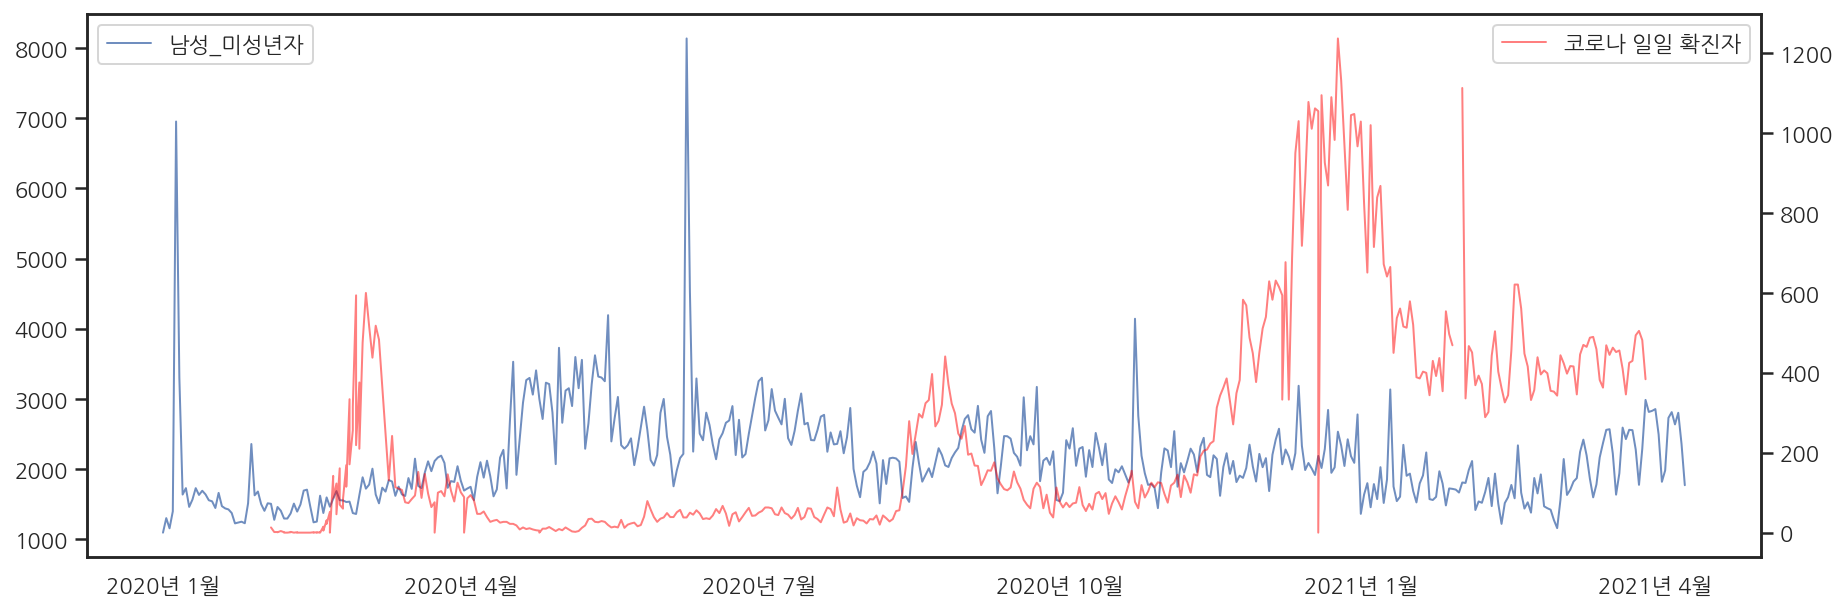

In [33]:
nut_population(["남성_미성년자"])

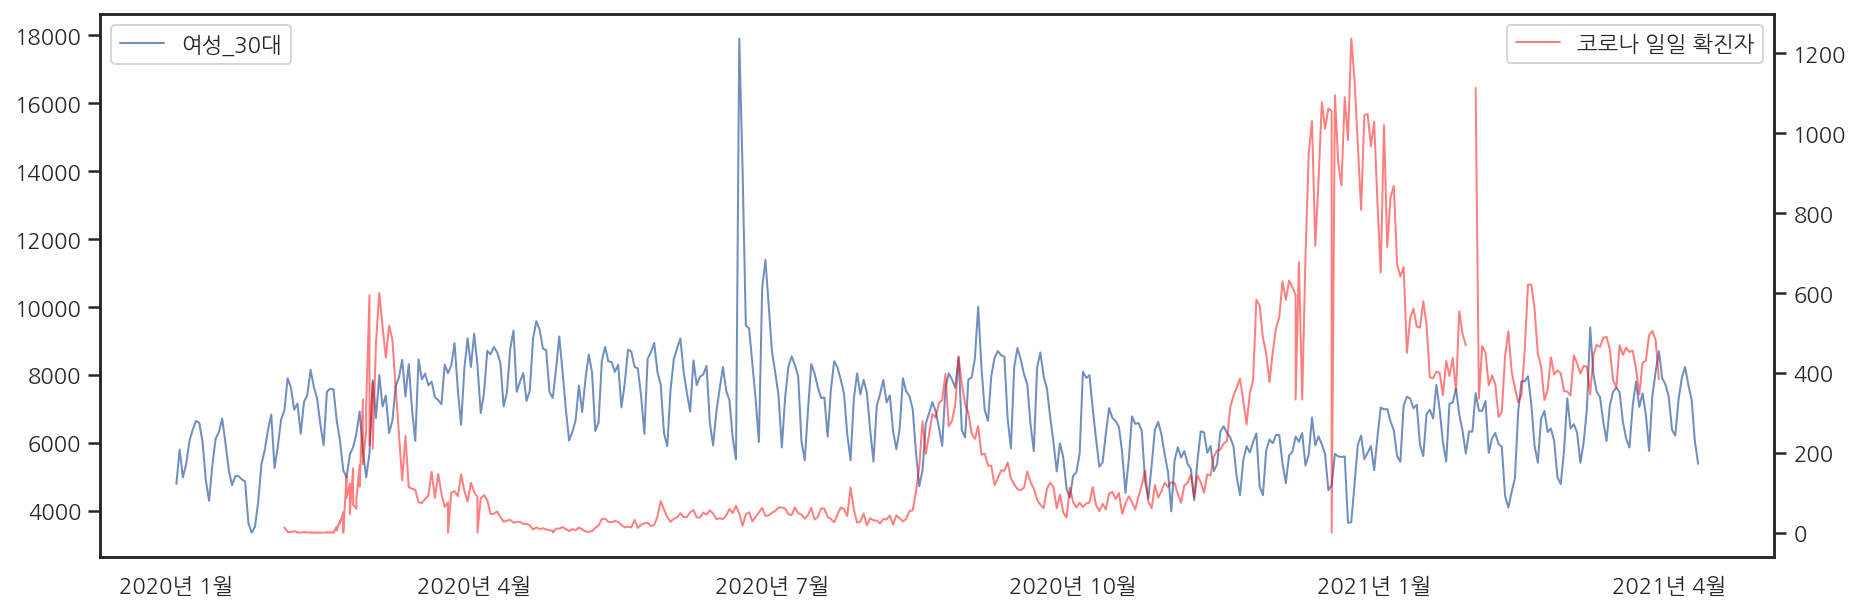

In [34]:
diet_population(["여성_30대"])

#### 4. 검색량 기준 인기 카테고리  연도별로 보기 
- 연도별 영양제 검색량 순위(1위~5위)
- 연도별 다이어트식품 검색량 순위(1위~5위)

In [35]:
#### 추가처리 - 연도 및 연도+월 컬럼 추가 

In [36]:
nut_total.insert(0, "year", nut_total["date"].apply(lambda x : x[0:4]))

In [37]:
nut_total.insert(1, "yyyymm", nut_total["date"].apply(lambda x : x[0:7]))

In [38]:
food_total.insert(0, "year", food_total["date"].apply(lambda x : x[0:4]))

In [39]:
food_total.insert(1, "yyyymm", food_total["date"].apply(lambda x : x[0:7]))

In [40]:
## 전체 파일에서 진행 
df_total.insert(0, "year", df_total["date"].apply(lambda x : x[0:4]))
df_total.insert(1, "yyyymm", df_total["date"].apply(lambda x : x[0:7]))

In [41]:
#영양제 랭킹 데이터프레임 만들기
nut_rank = pd.DataFrame()
nut_rank["rank"] = [1, 2, 3, 4, 5]

#연도별로 묶은 후 반복문으로 1~5위 뽑아서 데이터프레임에 붙이기 
dummy = nut_total.groupby(["year", "cate_5"]).sum()
dummy.insert(0, "sum", dummy.sum(axis=1))
dummy = dummy.reset_index()
year_list = ["2018", "2019", "2020", "2021"]

for i, year in enumerate(year_list): 
    data = dummy[dummy["year"] == year].sort_values(by="sum", ascending=False)
    nut_rank[year] = list(data[:5]["cate_5"])

In [42]:
#다이어트식품 랭킹 데이터프레임 만들기
diet_rank = pd.DataFrame()
diet_rank["rank"] = [1, 2, 3, 4, 5]

#연도별로 묶은 후 반복문으로 1~5위 뽑아서 데이터프레임에 붙이기 
dummy = food_total.groupby(["year", "cate_5"]).sum()
dummy.insert(0, "sum", dummy.sum(axis=1))
dummy = dummy.reset_index()
year_list = ["2018", "2019", "2020", "2021"]

for i, year in enumerate(year_list): 
    data = dummy[dummy["year"] == year].sort_values(by="sum", ascending=False)
    diet_rank[year] = list(data[:5]["cate_5"])

In [43]:
#전체 랭킹 데이터프레임 만들기(연도별, 1~10위)
total_rank = pd.DataFrame()
total_rank["rank"] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

#연도별로 묶은 후 반복문으로 1~5위 뽑아서 데이터프레임에 붙이기 
dummy = df_total.groupby(["year", "cate_5"]).sum()
dummy.insert(0, "sum", dummy.sum(axis=1))
dummy = dummy.reset_index()
year_list = ["2018", "2019", "2020", "2021"]

for i, year in enumerate(year_list): 
    data = dummy[dummy["year"] == year].sort_values(by="sum", ascending=False)
    total_rank[year] = list(data[:10]["cate_5"])

In [44]:
nut_rank

rank     2018     2019     2020     2021
0     1  프로바이오틱스  프로바이오틱스  프로바이오틱스     건강분말
1     2     밀크씨슬     크릴오일     건강분말  프로바이오틱스
2     3     비타민D  프리바이오틱스     밀크씨슬     밀크씨슬
3     4    폴리코사놀     건강분말     타트체리     비타민D
4     5  프리바이오틱스     밀크씨슬     비타민D     타트체리

In [45]:
diet_rank

rank   2018   2019     2020     2021
0     1    레몬밤  헬스보충제    헬스보충제      콜라겐
1     2   곤약젤리    레몬밤      콜라겐    헬스보충제
2     3  헬스보충제    콜라겐     곤약젤리      곤약쌀
3     4  가르시니아   곤약젤리  기타곤약가공품     곤약젤리
4     5  와일드망고  와일드망고      곤약쌀  기타곤약가공품

In [46]:
total_rank.set_index("rank")

2018     2019     2020        2021
rank                                       
1         레몬밤  프로바이오틱스  프로바이오틱스        건강분말
2     프로바이오틱스     크릴오일     건강분말     프로바이오틱스
3        곤약젤리  프리바이오틱스    헬스보충제         콜라겐
4        밀크씨슬     건강분말      콜라겐        밀크씨슬
5        비타민D     밀크씨슬     밀크씨슬        비타민D
6       헬스보충제    헬스보충제     타트체리       헬스보충제
7       폴리코사놀    폴리코사놀     비타민D        타트체리
8     프리바이오틱스     비타민D    프로폴리스  아르기닌(아미노산)
9        건강음료      레몬밤     크릴오일       멀티비타민
10      프로폴리스    보스웰리아    멀티비타민       프로폴리스

#### 5. 연도별 검색량 변화 추이(2018, 2019, 2020) 
- 영양제 연도별 검색량
- 다이어트식품 연도별 검색량 추이

In [47]:
#영양제 
dummy_nut = nut_total.groupby(["year"]).sum()
dummy_nut = dummy_nut.iloc[:3,:] #2021년 제외
dummy_nut

남성_미성년자        남성_20대        남성_30대        남성_40대      남성_50대이상  \
year                                                                          
2018  782602.170936  4.692503e+06  4.626591e+06  2.565151e+06  1.153806e+06   
2019  983193.636707  8.094504e+06  8.292451e+06  4.630954e+06  2.134292e+06   
2020  806348.854705  5.964096e+06  6.651289e+06  4.857296e+06  2.749468e+06   

           여성_미성년자        여성_20대        여성_30대        여성_40대      여성_50대이상  
year                                                                        
2018  1.153213e+06  6.256407e+06  7.564168e+06  4.270644e+06  2.089153e+06  
2019  1.140311e+06  9.816020e+06  1.259100e+07  8.086554e+06  4.361665e+06  
2020  1.257960e+06  8.928075e+06  1.253079e+07  9.861022e+06  6.192870e+06

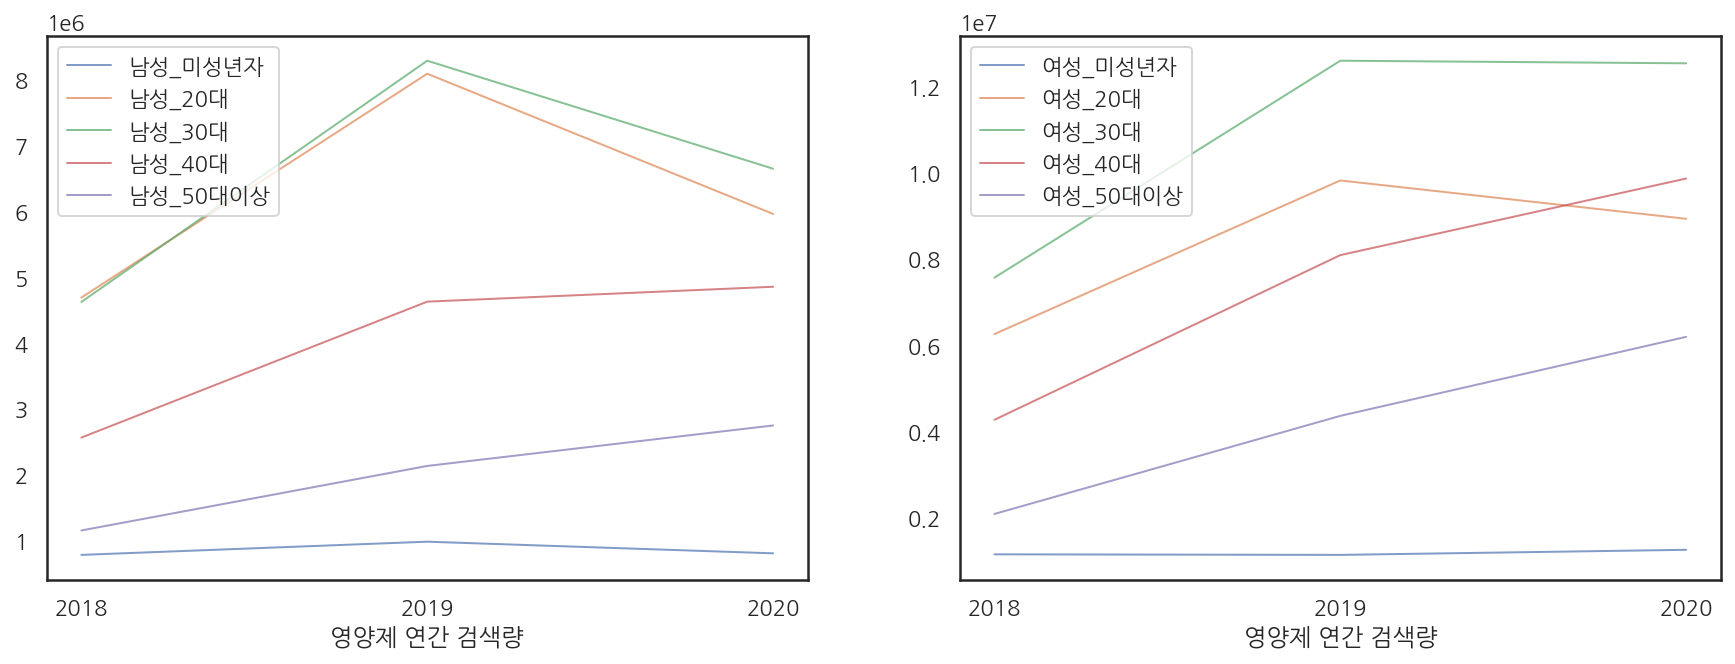

In [48]:
sns.set_style("white")
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'NanumGothic'

plt.figure(figsize=(15,5))

ax1 = plt.subplot(121)
ax1.plot(dummy_nut.index, dummy_nut.iloc[:,:5], lw=1, alpha=0.7)
ax1.legend(["남성_미성년자", "남성_20대", "남성_30대", "남성_40대", "남성_50대이상"])
plt.xlabel("영양제 연간 검색량")

ax2 = plt.subplot(122)
ax2.plot(dummy_nut.index, dummy_nut.iloc[:,5:], lw=1, alpha=0.7)
ax2.legend(["여성_미성년자", "여성_20대", "여성_30대", "여성_40대", "여성_50대이상"])
plt.xlabel("영양제 연간 검색량")

plt.show()

In [49]:
#다이어트식품
dummy_food = food_total.groupby(["year"]).sum()
dummy_food = dummy_nut.iloc[:3,:] #2021년 제외
dummy_food

남성_미성년자        남성_20대        남성_30대        남성_40대      남성_50대이상  \
year                                                                          
2018  782602.170936  4.692503e+06  4.626591e+06  2.565151e+06  1.153806e+06   
2019  983193.636707  8.094504e+06  8.292451e+06  4.630954e+06  2.134292e+06   
2020  806348.854705  5.964096e+06  6.651289e+06  4.857296e+06  2.749468e+06   

           여성_미성년자        여성_20대        여성_30대        여성_40대      여성_50대이상  
year                                                                        
2018  1.153213e+06  6.256407e+06  7.564168e+06  4.270644e+06  2.089153e+06  
2019  1.140311e+06  9.816020e+06  1.259100e+07  8.086554e+06  4.361665e+06  
2020  1.257960e+06  8.928075e+06  1.253079e+07  9.861022e+06  6.192870e+06

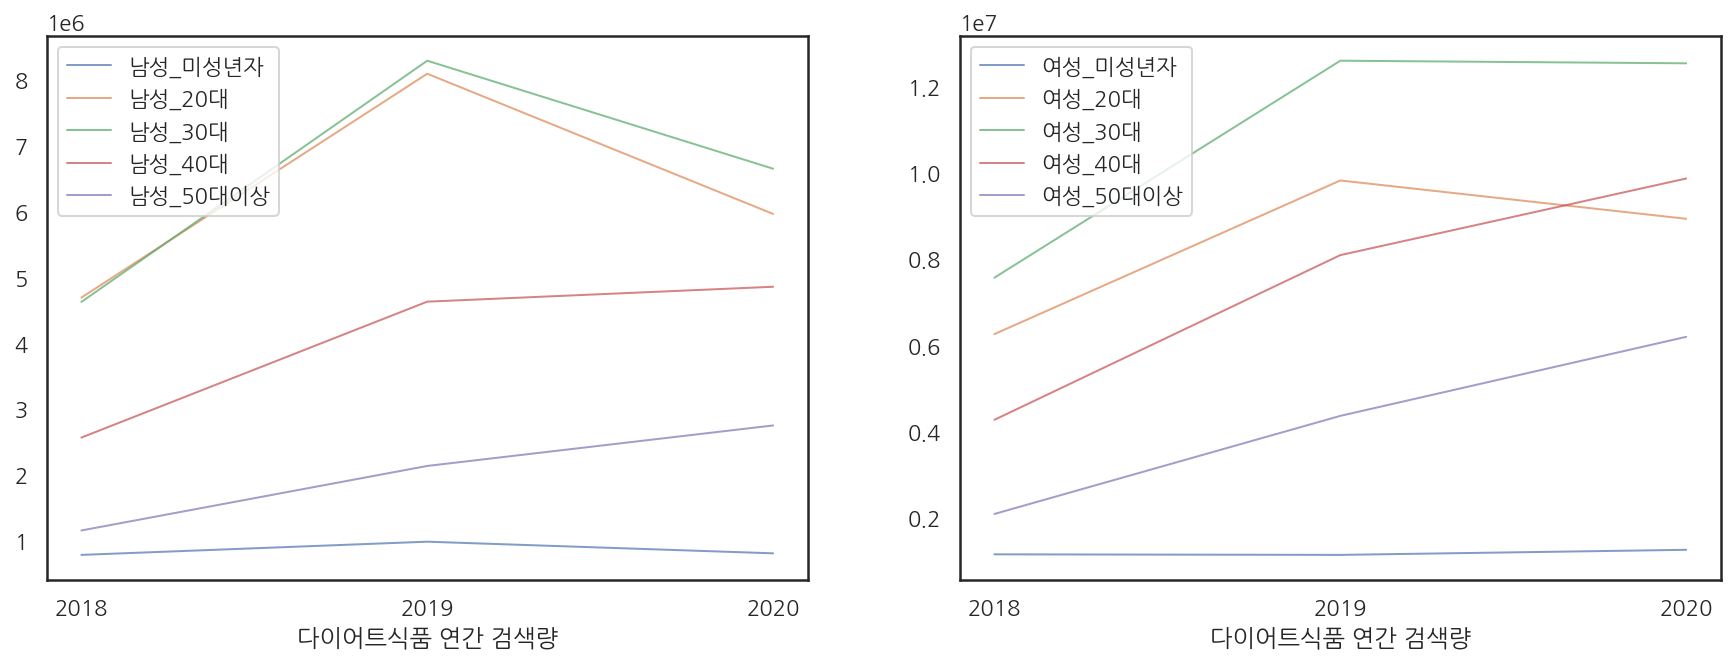

In [50]:
sns.set_style("white")
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'NanumGothic'

plt.figure(figsize=(15,5))

ax1 = plt.subplot(121)
ax1.plot(dummy_food.index, dummy_food.iloc[:,:5], lw=1, alpha=0.7)
ax1.legend(["남성_미성년자", "남성_20대", "남성_30대", "남성_40대", "남성_50대이상"])
plt.xlabel("다이어트식품 연간 검색량")

ax2 = plt.subplot(122)
ax2.plot(dummy_food.index, dummy_food.iloc[:,5:], lw=1, alpha=0.7)
ax2.legend(["여성_미성년자", "여성_20대", "여성_30대", "여성_40대", "여성_50대이상"])
plt.xlabel("다이어트식품 연간 검색량")

plt.show()

#### 6. 전체 검색량 변화 추이 
- 영양제 월별 검색량
- 다이어트식품 월별 검색량 추이

In [52]:
#영양제 
dummy_nut = nut_total.groupby(["yyyymm"]).sum()
dummy_nut = dummy_nut[:-1] #2021년 4월 데이터 제외(4월 10일까지만 있기 때문)
dummy_nut["sum"] = dummy_nut.sum(axis=1)

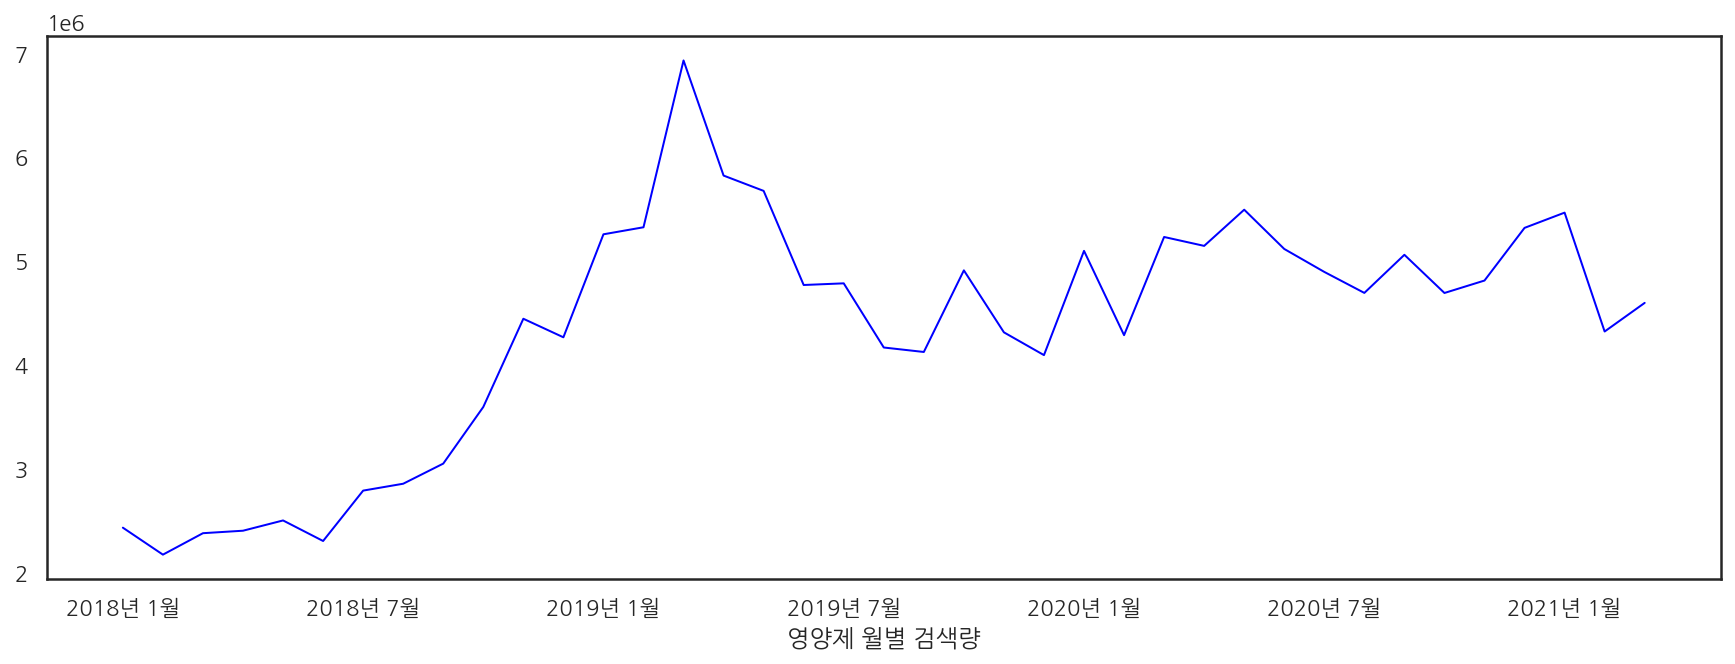

In [53]:
sns.set_style("white")
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'NanumGothic'

plt.figure(figsize=(15,5))

plt.plot(dummy_nut.index, dummy_nut["sum"], lw=1, color="blue", alpha=1)
plt.xlabel("영양제 월별 검색량")
plt.xticks(["2018-01", "2018-07","2019-01", "2019-07","2020-01","2020-07", "2021-01"],
          labels = ["2018년 1월","2018년 7월","2019년 1월","2019년 7월","2020년 1월","2020년 7월", "2021년 1월"])

plt.show()

In [54]:
#다이어트식품
dummy_food = food_total.groupby(["yyyymm"]).sum()
dummy_food = dummy_food[:-1] #2021년 4월 데이터 제외(4월 10일까지만 있기 때문)
dummy_food["sum"] = dummy_food.sum(axis=1)

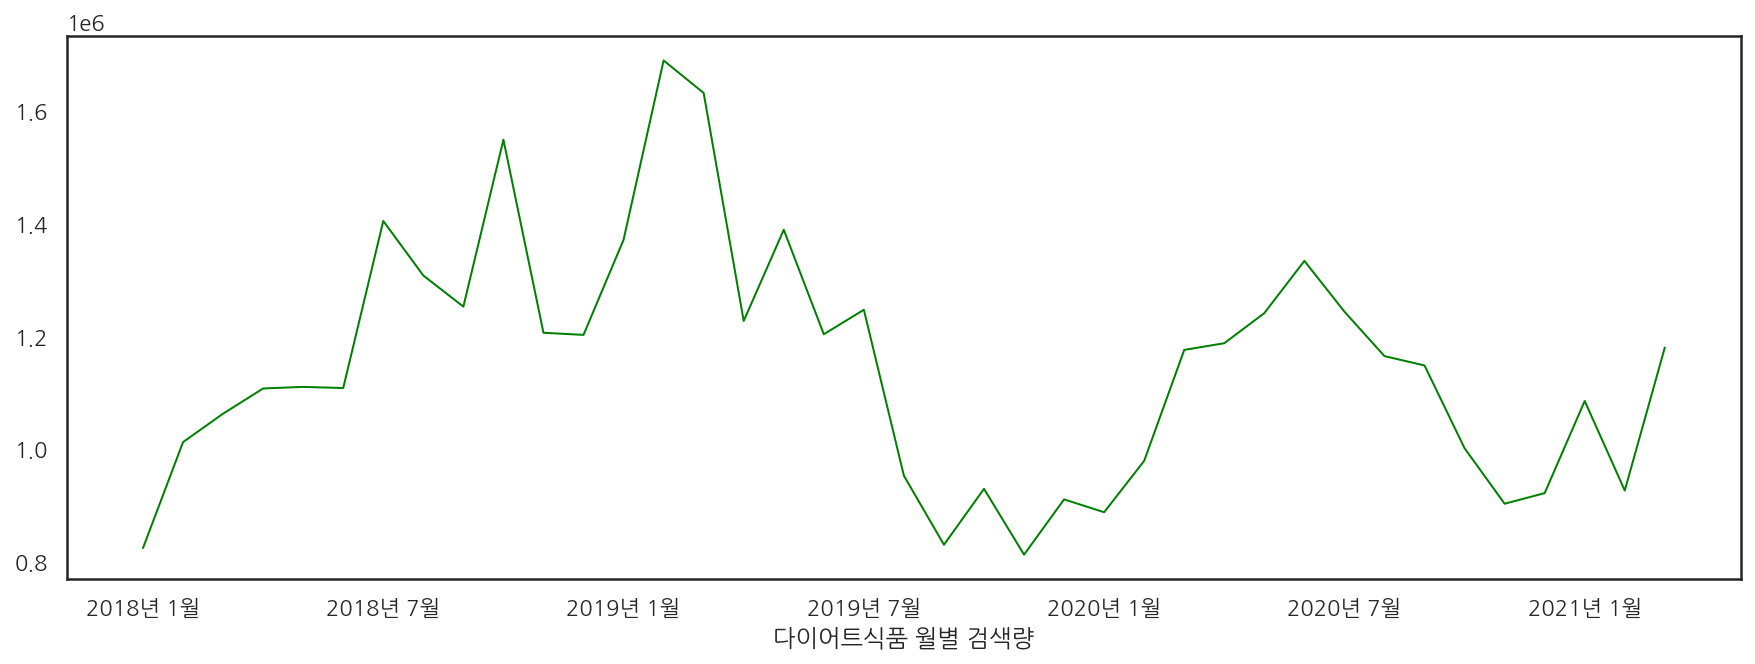

In [55]:
sns.set_style("white")
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'NanumGothic'

plt.figure(figsize=(15,5))

plt.plot(dummy_food.index, dummy_food["sum"], color="green", lw=1, alpha=1)
plt.xlabel("다이어트식품 월별 검색량")
plt.xticks(["2018-01", "2018-07","2019-01", "2019-07","2020-01","2020-07", "2021-01"],
          labels = ["2018년 1월","2018년 7월","2019년 1월","2019년 7월","2020년 1월","2020년 7월", "2021년 1월"])

plt.show()

In [56]:
def drawgraph(*args) : 
    plt.figure(figsize = (10,7))
    sns.set_style("whitegrid")
    plt.rcParams['font.family'] = 'NanumGothic'
    name_list = []
    for i in args : 
        sns.lineplot(x= "date", y = i, alpha = 0.7, data=group_total.iloc[:-1])
        name_list.append(i)
    plt.xticks(["1801", "1807","1901", "1907","2001","2007", "2101"],
          labels = ["2018년 1월","2018년 7월","2019년 1월","2019년 7월","2020년 1월","2020년 7월", "2021년 1월"])
    plt.ylabel("월간 검색량")
    plt.legend(group_total[name_list].iloc[:-1])
    plt.show()

In [57]:
total_trend.head()

date  수면보조제  아르기닌(아미노산)      효소  은행추출물   초록입홍합    헤모힘  타트체리     매스틱  \
0 2020-01-01  353.6      2218.8  1051.4  211.0   333.7  500.0  41.8   650.9   
1 2020-01-02  683.5      4471.8  1406.0  277.6   402.1  577.0  65.6  1456.5   
2 2020-01-03  550.4      4253.2  1703.5  262.4   376.4  558.0  68.4   653.9   
3 2020-01-04  403.1      4477.5  1416.4  238.6   281.4  567.5  45.6   535.1   
4 2020-01-05  445.8      5089.7  1493.4  249.1  2800.6  480.1  45.6   567.2   

     구연산  ...  다이어트바     잔티젠     레몬밤    CLA   히알루론산    카테킨  와일드망고     곤약  \
0  159.9  ...  442.4   741.2   854.6  424.2  1034.4  229.3   88.9  714.9   
1  192.0  ...  527.6  1018.8  1046.9  509.0  1231.6  278.5  108.2  806.1   
2  171.1  ...  548.2   849.8   938.4  512.0  1204.7  228.8  100.6  779.5   
3  185.3  ...  410.8   849.8  1018.8  478.6  1207.6  241.6   90.1  905.0   
4  174.1  ...  546.1   909.5  1007.8  488.0  1164.3  221.8   98.9  776.7   

   food_sum  daycnt  
0   18973.7     0.0  
1   24695.3     NaN  
2   21358.7     NaN  
3   23144.0     NaN  
4   24986.1     NaN  

[5 rows x 99 columns]

#### 7. 개별 제품의 검색량 변화 추이 

In [58]:
#영양제 검색량 - 남녀 나눠그리기(남녀 검색량 자체가 차이나기 때문에 따로 그림)
#catename에 개별 제품을 넣으면 되는 함수 

def nut_trend(catename) : 

    dummy = nut_total[nut_total["cate_5"] == catename]
    dummy = dummy.groupby("yyyymm").sum()
    dummy = dummy[:-1]

    sns.set_style("white")
    plt.rcParams['axes.unicode_minus'] = False
    plt.rcParams['font.family'] = 'NanumGothic'

    plt.figure(figsize=(15,5))

    ax1 = plt.subplot(121)
    ax1.plot(dummy.index, dummy.iloc[:,:5], lw=1, alpha=0.85)
    ax1.legend(["남성_미성년자", "남성_20대", "남성_30대", "남성_40대", "남성_50대이상"])
    plt.xlabel(f"{catename} 월간 검색량")
    plt.xticks(["2018-01", "2018-07","2019-01", "2019-07","2020-01","2020-07", "2021-01"],
          labels = ["2018년 1월","2018년 7월","2019년 1월","2019년 7월","2020년 1월","2020년 7월", "2021년 1월"])

    ax2 = plt.subplot(122)
    ax2.plot(dummy.index, dummy.iloc[:,5:], lw=1, alpha=0.85)
    ax2.legend(["여성_미성년자", "여성_20대", "여성_30대", "여성_40대", "여성_50대이상"])
    plt.xlabel(f"{catename} 월간 검색량")
    
    plt.xticks(["2018-01", "2018-07","2019-01", "2019-07","2020-01","2020-07", "2021-01"],
          labels = ["2018년 1월","2018년 7월","2019년 1월","2019년 7월","2020년 1월","2020년 7월", "2021년 1월"])

    plt.show()

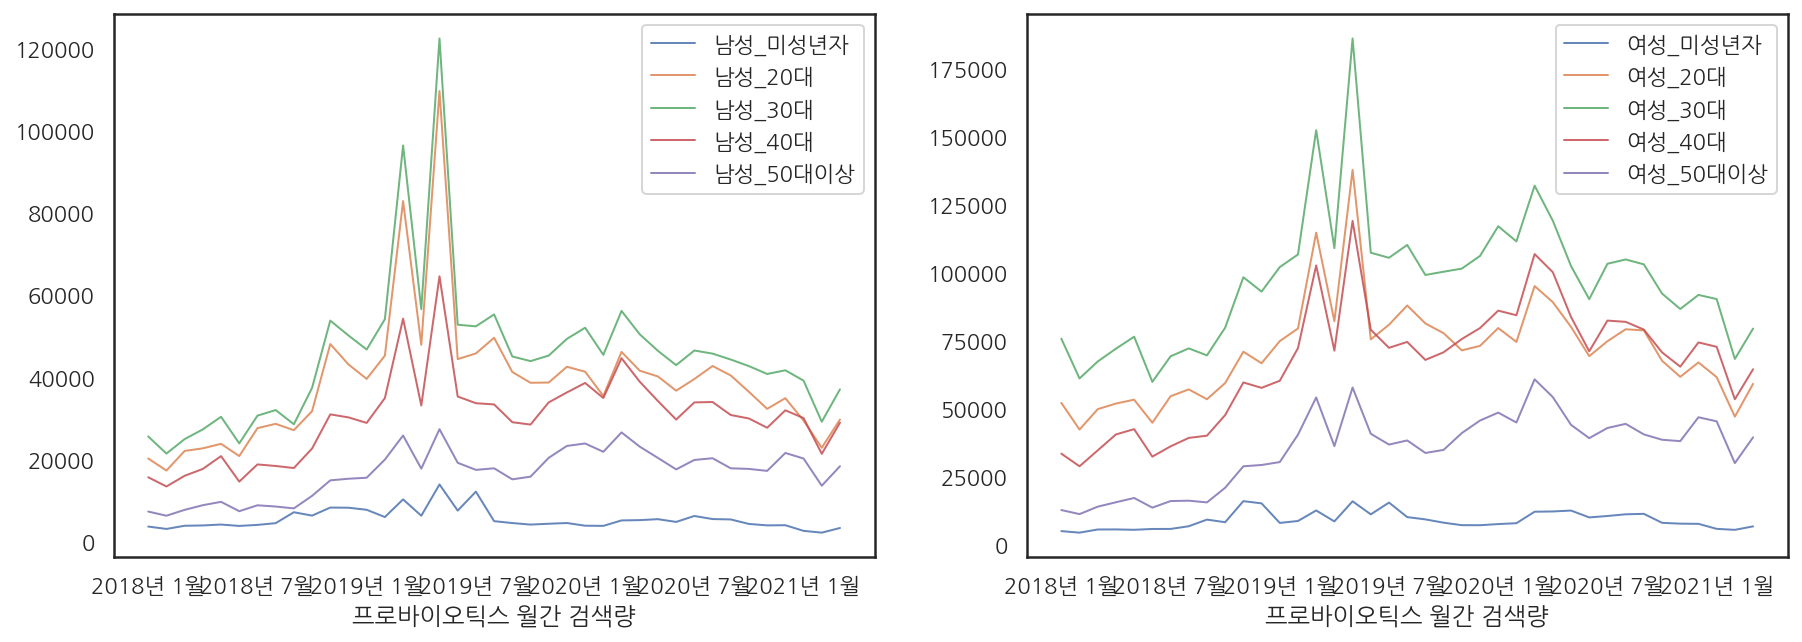

In [59]:
nut_trend("프로바이오틱스")

In [60]:
#영양제 검색량
#catename에 개별 제품을 넣고, grouplist에 비교하고자 하는 그룹을 리스트 형태로 넣으면 되는 함수 


def nut_trend_v2(catename, grouplist) : 

    dummy = nut_total[nut_total["cate_5"] == catename]
    dummy = dummy.groupby("yyyymm").sum()
    dummy = dummy[:-1]

    sns.set_style("white")
    plt.rcParams['axes.unicode_minus'] = False
    plt.rcParams['font.family'] = 'NanumGothic'

    plt.figure(figsize=(15,5))


    ax1 = plt.subplot(111)
    
    for i, value in enumerate(grouplist) : 
        ax1.plot(dummy.index, dummy[value], "-", lw=1, label = f"{value}")
        ax1.legend(loc = "upper left")  

    plt.xlabel(f"{catename} 월간 검색량")
    plt.xticks(["2018-01", "2018-07","2019-01", "2019-07","2020-01","2020-07", "2021-01"],
          labels = ["2018년 1월","2018년 7월","2019년 1월","2019년 7월","2020년 1월","2020년 7월", "2021년 1월"])
    plt.show()

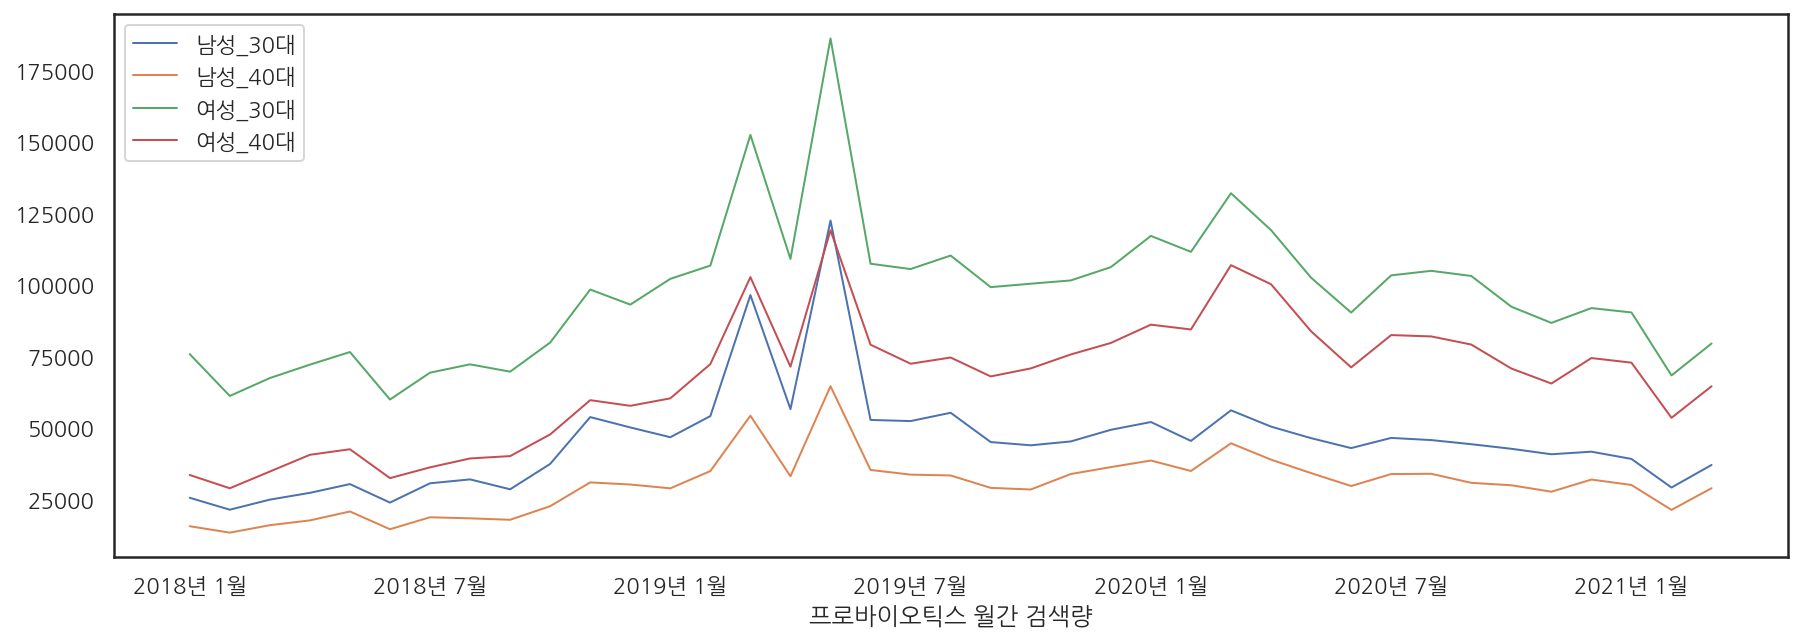

In [61]:
nut_trend_v2("프로바이오틱스", ["남성_30대", "남성_40대", "여성_30대", "여성_40대"])

In [62]:
#다이어트식품 검색량 - 남녀 나눠그리기(남녀 검색량 자체가 차이나기 때문에 따로 그림)
#catename에 개별 제품을 넣으면 되는 함수 

def food_trend(catename) : 

    dummy = food_total[food_total["cate_5"] == catename]
    dummy = dummy.groupby("yyyymm").sum()
    dummy = dummy[:-1]

    sns.set_style("white")
    plt.rcParams['axes.unicode_minus'] = False
    plt.rcParams['font.family'] = 'NanumGothic'

    plt.figure(figsize=(15,5))

    ax1 = plt.subplot(121)
    ax1.plot(dummy.index, dummy.iloc[:,:5], lw=1, alpha=0.85)
    ax1.legend(["남성_미성년자", "남성_20대", "남성_30대", "남성_40대", "남성_50대이상"])
    plt.xlabel(f"{catename} 월간 검색량")
    plt.xticks(["2018-01", "2018-07","2019-01", "2019-07","2020-01","2020-07", "2021-01"],
          labels = ["2018년 1월","2018년 7월","2019년 1월","2019년 7월","2020년 1월","2020년 7월", "2021년 1월"])

    ax2 = plt.subplot(122)
    ax2.plot(dummy.index, dummy.iloc[:,5:], lw=1, alpha=0.85)
    ax2.legend(["여성_미성년자", "여성_20대", "여성_30대", "여성_40대", "여성_50대이상"])
    plt.xlabel(f"{catename} 월간 검색량")
    
    plt.xticks(["2018-01", "2018-07","2019-01", "2019-07","2020-01","2020-07", "2021-01"],
          labels = ["2018년 1월","2018년 7월","2019년 1월","2019년 7월","2020년 1월","2020년 7월", "2021년 1월"])

    plt.show()

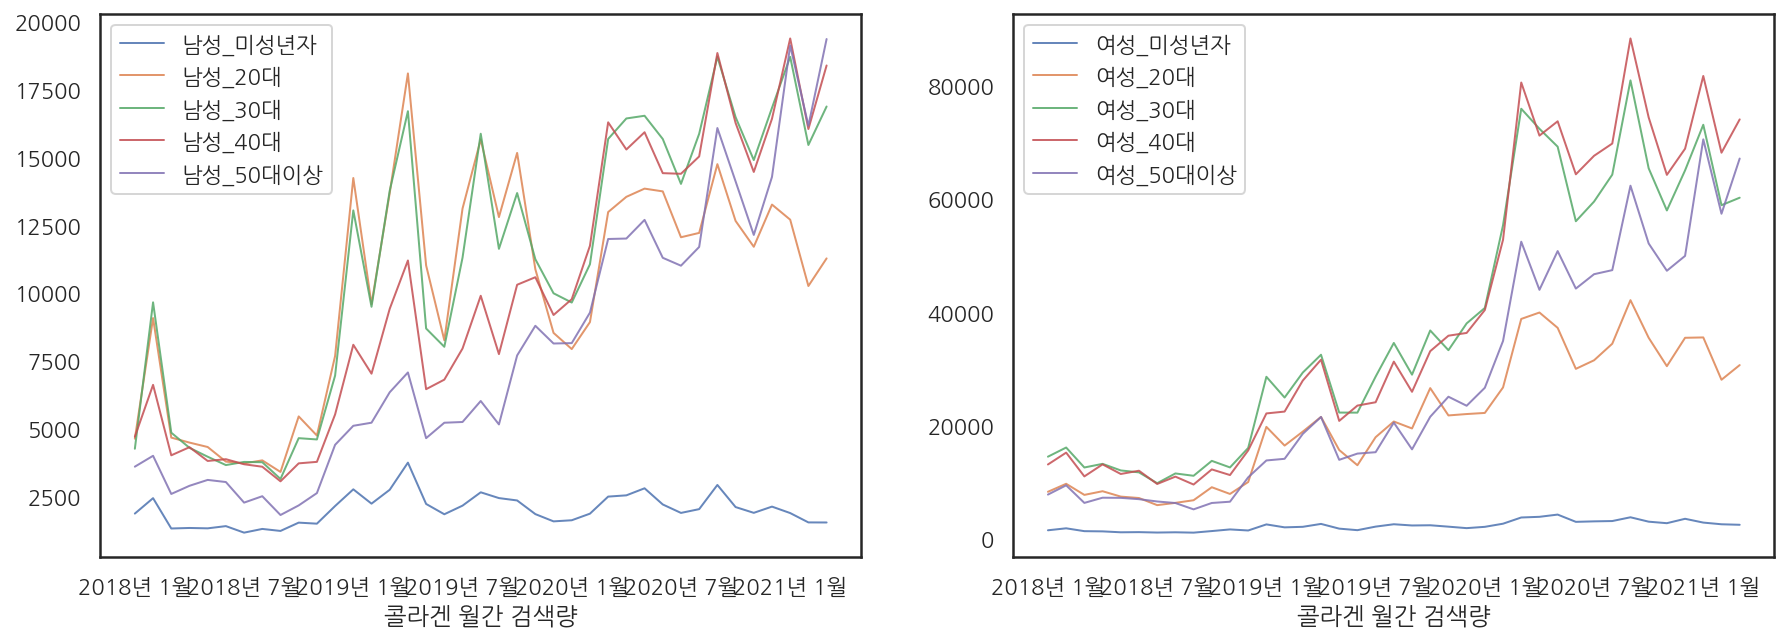

In [63]:
food_trend("콜라겐")

In [64]:
#다이어트식품 검색량
#catename에 개별 제품을 넣고, grouplist에 비교하고자 하는 그룹을 리스트 형태로 넣으면 되는 함수 


def food_trend_v2(catename, grouplist) : 

    dummy = food_total[food_total["cate_5"] == catename]
    dummy = dummy.groupby("yyyymm").sum()
    dummy = dummy[:-1]

    sns.set_style("white")
    plt.rcParams['axes.unicode_minus'] = False
    plt.rcParams['font.family'] = 'NanumGothic'

    plt.figure(figsize=(15,5))


    ax1 = plt.subplot(111)
    
    for i, value in enumerate(grouplist) : 
        ax1.plot(dummy.index, dummy[value], "-", lw=1, label = f"{value}")
        ax1.legend(loc = "upper left")  

    plt.xlabel(f"{catename} 월간 검색량")
    plt.xticks(["2018-01", "2018-07","2019-01", "2019-07","2020-01","2020-07", "2021-01"],
          labels = ["2018년 1월","2018년 7월","2019년 1월","2019년 7월","2020년 1월","2020년 7월", "2021년 1월"])
    plt.show()

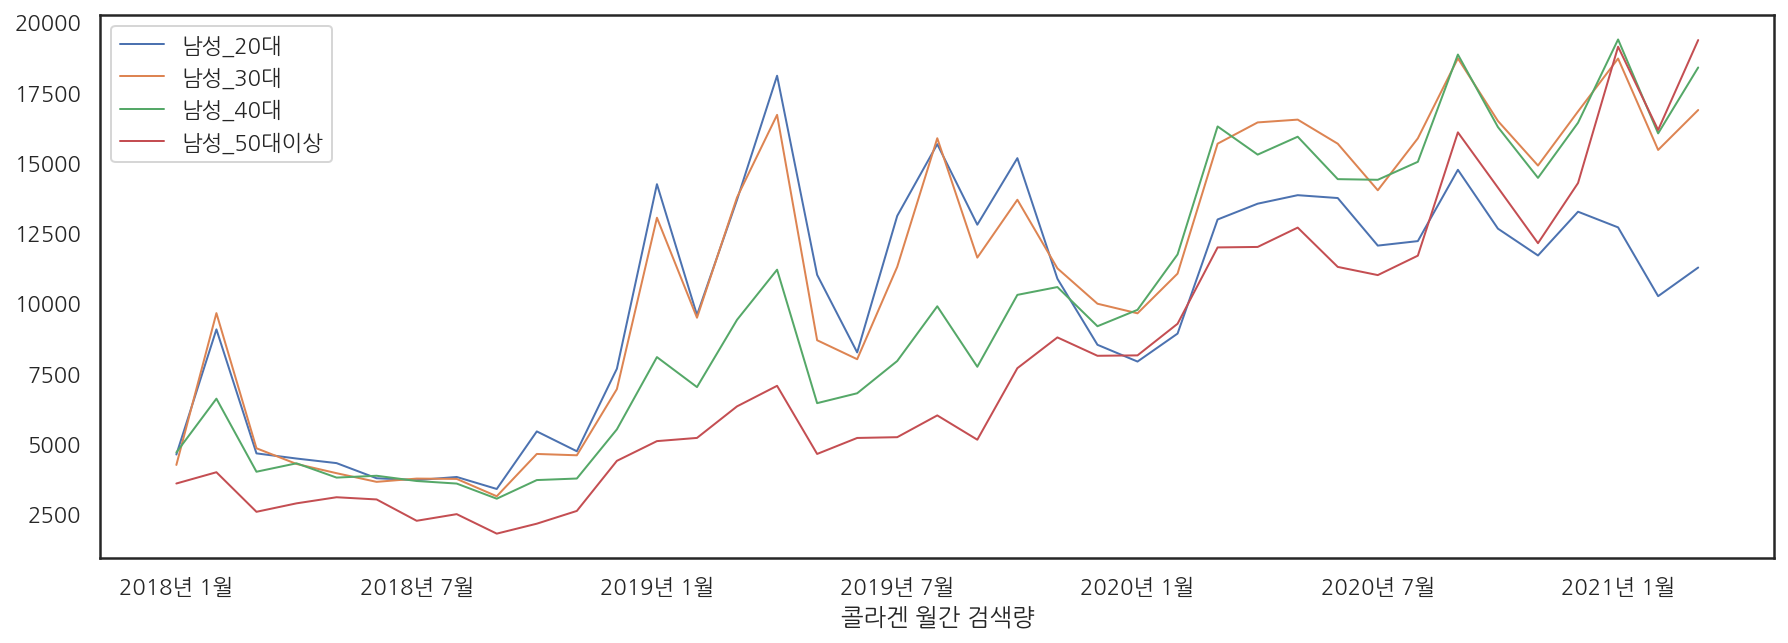

In [65]:
food_trend_v2("콜라겐", ["남성_20대", "남성_30대", "남성_40대", "남성_50대이상"])

#### 8. 일자별 영양제 1등 뽑기 (참고용으로 제작) 

In [66]:
nut_best = nut_total.copy()
nut_best["sum"] = nut_best[4:].sum(axis=1)

In [67]:
nut_best = nut_best.pivot(index="date", columns="cate_5", values="sum")
nut_best = nut_best.reset_index()

In [68]:
nut_best_2020 = nut_best[nut_best["date"] >= "2020-01-01"]
nut_best_2020 = nut_best_2020[nut_best_2020["date"] <= "2020-07-31"]

In [69]:
nut_best_2020 = nut_best_2020.set_index("date").T


In [70]:
datelist = list(nut_best_2020.columns)
search_list = []
index_list = []

for date in datelist: 
    max_search = nut_best_2020[date].max()
    max_index = nut_best_2020.index[nut_best_2020[date] == max_search].tolist()
    search_list.append(max_search)
    index_list.append(max_index[0])
    

In [71]:
max_df = pd.DataFrame({"date":datelist, 
                      "max_index":index_list, 
                      "max_search":search_list})

In [72]:
max_df.sort_values(by="max_search", ascending=False)

date max_index     max_search
160  2020-06-09      크릴오일  266388.595626
4    2020-01-05       타우린  261727.851920
5    2020-01-06       타우린  203926.776998
161  2020-06-10      크릴오일  127152.333835
135  2020-05-15      건강분말   70983.987124
..          ...       ...            ...
212  2020-07-31   프로바이오틱스   12451.144088
23   2020-01-24   프로바이오틱스   11574.911279
156  2020-06-05   프로바이오틱스   11517.077479
22   2020-01-23   프로바이오틱스   10718.836680
157  2020-06-06   프로바이오틱스    9942.156058

[213 rows x 3 columns]

#### 9. 면역력 관련 키워드 검색량과 확진자 수 비교 (참고자료)


In [73]:
search_immune = pd.read_excel("data/search_immune.xlsx")

In [74]:
search_immune = search_immune[search_immune["날짜"] <= "2021-03-29"]

In [75]:
search_immune["covid"] = covid["daycnt"]

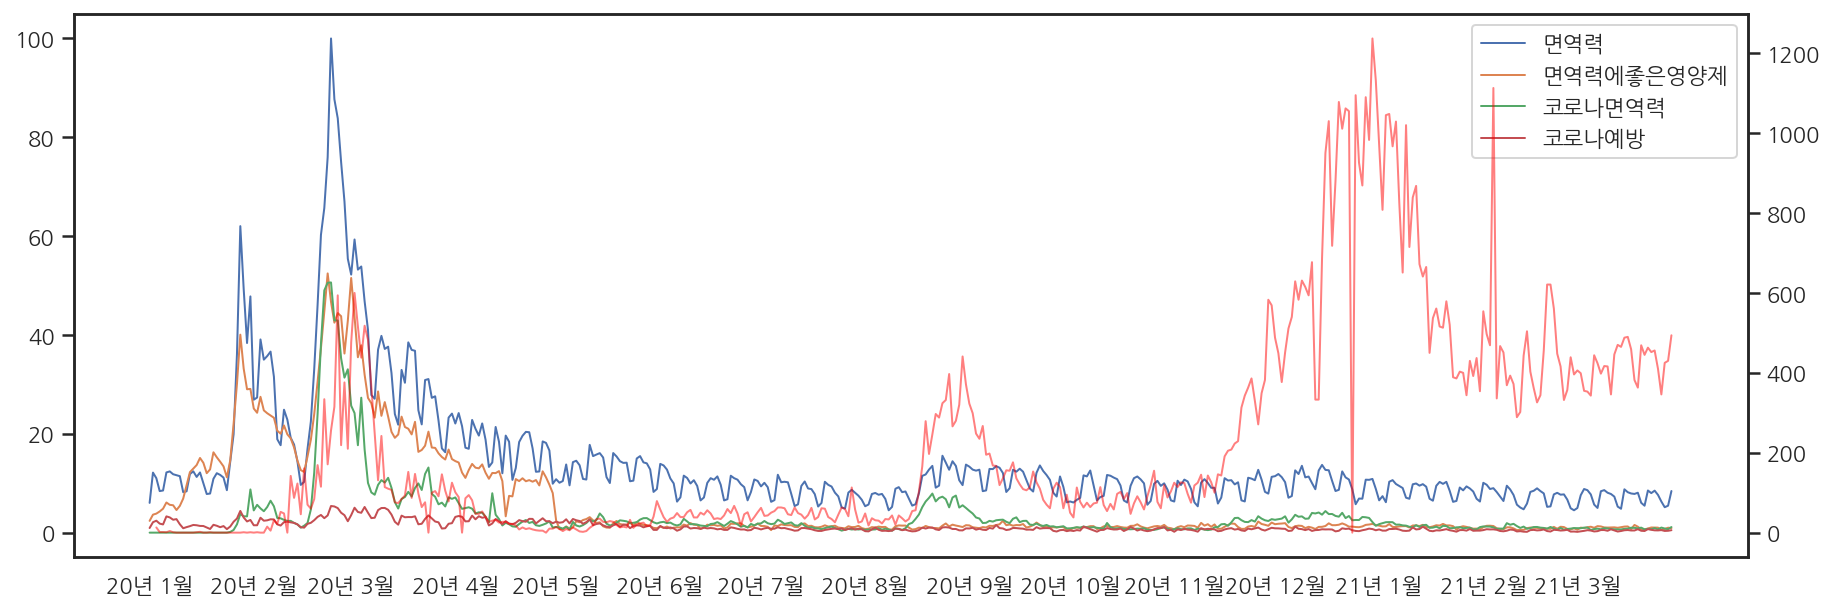

In [76]:
sns.set_style("white")
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'NanumGothic'

plt.figure(figsize=(15,5))

ax1 = plt.subplot(111)
ax2 = ax1.twinx()
plot1 = ax1.plot(search_immune["날짜"], search_immune["면역력"], "-", lw=1, alpha=1, 
                 label = "면역력")
plot1 = ax1.plot(search_immune["날짜"], search_immune["면역력에좋은영양제"], "-", lw=1, alpha=1, 
                 label = "면역력에좋은영양제")
plot1 = ax1.plot(search_immune["날짜"], search_immune["코로나면역력"], "-", lw=1, alpha=1, 
                 label = "코로나면역력")
plot1 = ax1.plot(search_immune["날짜"], search_immune["코로나예방"], "-", lw=1, alpha=1, 
                 label = "코로나예방")

plot2 = ax2.plot(search_immune["날짜"], search_immune["covid"], "-", lw=1, color="red", alpha=0.5, label= "코로나 일일 확진자")

plt.xticks(rotation=45, ticks=["2020-01-01", "2020-02-01", "2020-03-01", "2020-04-01", "2020-05-01", "2020-06-01", "2020-07-01", 
            "2020-08-01", "2020-09-01", "2020-10-01", "2020-11-01", "2020-12-01", "2021-01-01", "2021-02-01", "2021-03-01"], 
          labels = ["20년 1월", "20년 2월", "20년 3월", "20년 4월", "20년 5월", "20년 6월", "20년 7월", "20년 8월"
                  , "20년 9월", "20년 10월", "20년 11월", "20년 12월", "21년 1월", "21년 2월", "21년 3월"])


ax1.legend(loc = "best")


#### 10. 구매량, 판매량 랭킹 비교 
- 10.1. 판매량 랭킹 찾기 

In [77]:
#판매량 랭킹을 계산하기 위해 판매량이 있는 데이터를 import 
nutrients = pd.read_csv("data/pre_nutrients.csv", encoding = "utf-8-sig", index_col = 0)
dietfood = pd.read_csv("data/healthfood_preprocessing.csv", encoding = "utf-8-sig", index_col = 0)

In [78]:
nutrients = nutrients[["name", "brand", "cate_1", "cate_2", "cate_3", "cate_4", "cate_5", "tag", "price", "review", "purchaseCnt", "date"]]
dietfood["cate_5"] = dietfood["cate_4"] #cate_5 맞추기 
dietfood = dietfood[["name", "brand", "cate_1", "cate_2", "cate_3", "cate_4", "cate_5", "tag", "price", "review", "purchaseCnt", "date"]]

In [79]:
#하나의 데이터프레임으로 합치기 
df_concat = pd.concat([nutrients, dietfood])
df_concat = df_concat.reset_index(drop=True)

In [80]:
#판매 랭킹 20 찾기
sell_ranking = df_concat.groupby("cate_5").sum().sort_values(by="purchaseCnt", ascending = False)
sell_ranking = sell_ranking[["review", "purchaseCnt"]]
sell_ranking_20 = sell_ranking[:20]

- 10.2 검색량 랭킹 찾기 

In [81]:
search_ranking = df_total.copy()
search_ranking["sum"] = search_ranking.iloc[:, 4:].sum(axis=1)
search_ranking = search_ranking[["cate_5", "sum"]]
search_ranking = search_ranking.groupby("cate_5").sum().sort_values(by="sum", ascending = False)
search_ranking_20 = search_ranking[:20]

- 10.3 랭킹 매기기

In [82]:
rank_list = list(range(1, 21))

In [83]:
sell_ranking_20["sell_rank"] = rank_list
search_ranking_20["search_rank"] = rank_list

- 10.4 순위분석
- total_rank : 판매 20위, 검색 20위 합친 데이터프레임
- both_rank : 판매 20위, 검색 20위 내에 모두 랭크된 카테고리만으로 이루어진 데이터프레임 
- 판매 20위권에는 있으나 검색 20위권에는 들지 못한 카테고리, 그리고 반대로 판매 20위권에는 들지 못했으나 검색 20위권에는 들어간 카테고리 또한 찾습니다

In [84]:
total_rank = pd.merge(left=sell_ranking_20, right=search_ranking_20, how="outer", on="cate_5")
both_rank = pd.merge(left=sell_ranking_20, right=search_ranking_20, how="inner", on="cate_5")

In [85]:
#판매 랭킹, 검색 랭킹에 들어간 판매 랭킹들
both_sell = list(both_rank["sell_rank"])
#판매 랭킹, 검색 랭킹에 들어간 검색 랭킹들
both_search = list(both_rank["search_rank"])

In [86]:
#판매 랭킹에는 있으나 검색 랭킹에는 없는 판매 랭킹 리스트
only_sell = list(set(sell_ranking_20["sell_rank"]) - set(both_sell))

#판매 랭킹에는 없으나 검색 랭킹에는 있는 검색 랭킹 리스트
only_search = list(set(search_ranking_20["search_rank"]) - set(both_search))

In [87]:
#판매 랭킹에만 들어간 카테고리의 데이터프레임
sell_ranking_only = sell_ranking_20.copy()

for rank in both_sell : 
    sell_ranking_only = sell_ranking_only.drop(sell_ranking_only[sell_ranking_only["sell_rank"] == rank].index)
        

In [88]:
#검색 랭킹에만 들어간 카테고리의 데이터프레임 
search_ranking_only = search_ranking_20.copy()

for rank in both_search : 
    search_ranking_only = search_ranking_only.drop(search_ranking_only[search_ranking_only["search_rank"] == rank].index)
        

In [89]:
#합쳐서 그룹(판매, 검색 모두 상위권, 판매만 상위권, 검색만 상위권의 세 그룹)이 구분되도록 데이터프레임 생성 
rank_result = pd.concat([both_rank, sell_ranking_only])
rank_result = pd.concat([rank_result, search_ranking_only])

- 위의 결과를 표현하는 그래프로 시각화
- 판매,검색 모두 상위권 / 판매만 상위권 / 검색만 상위권으로 구분되도록 그렸습니다

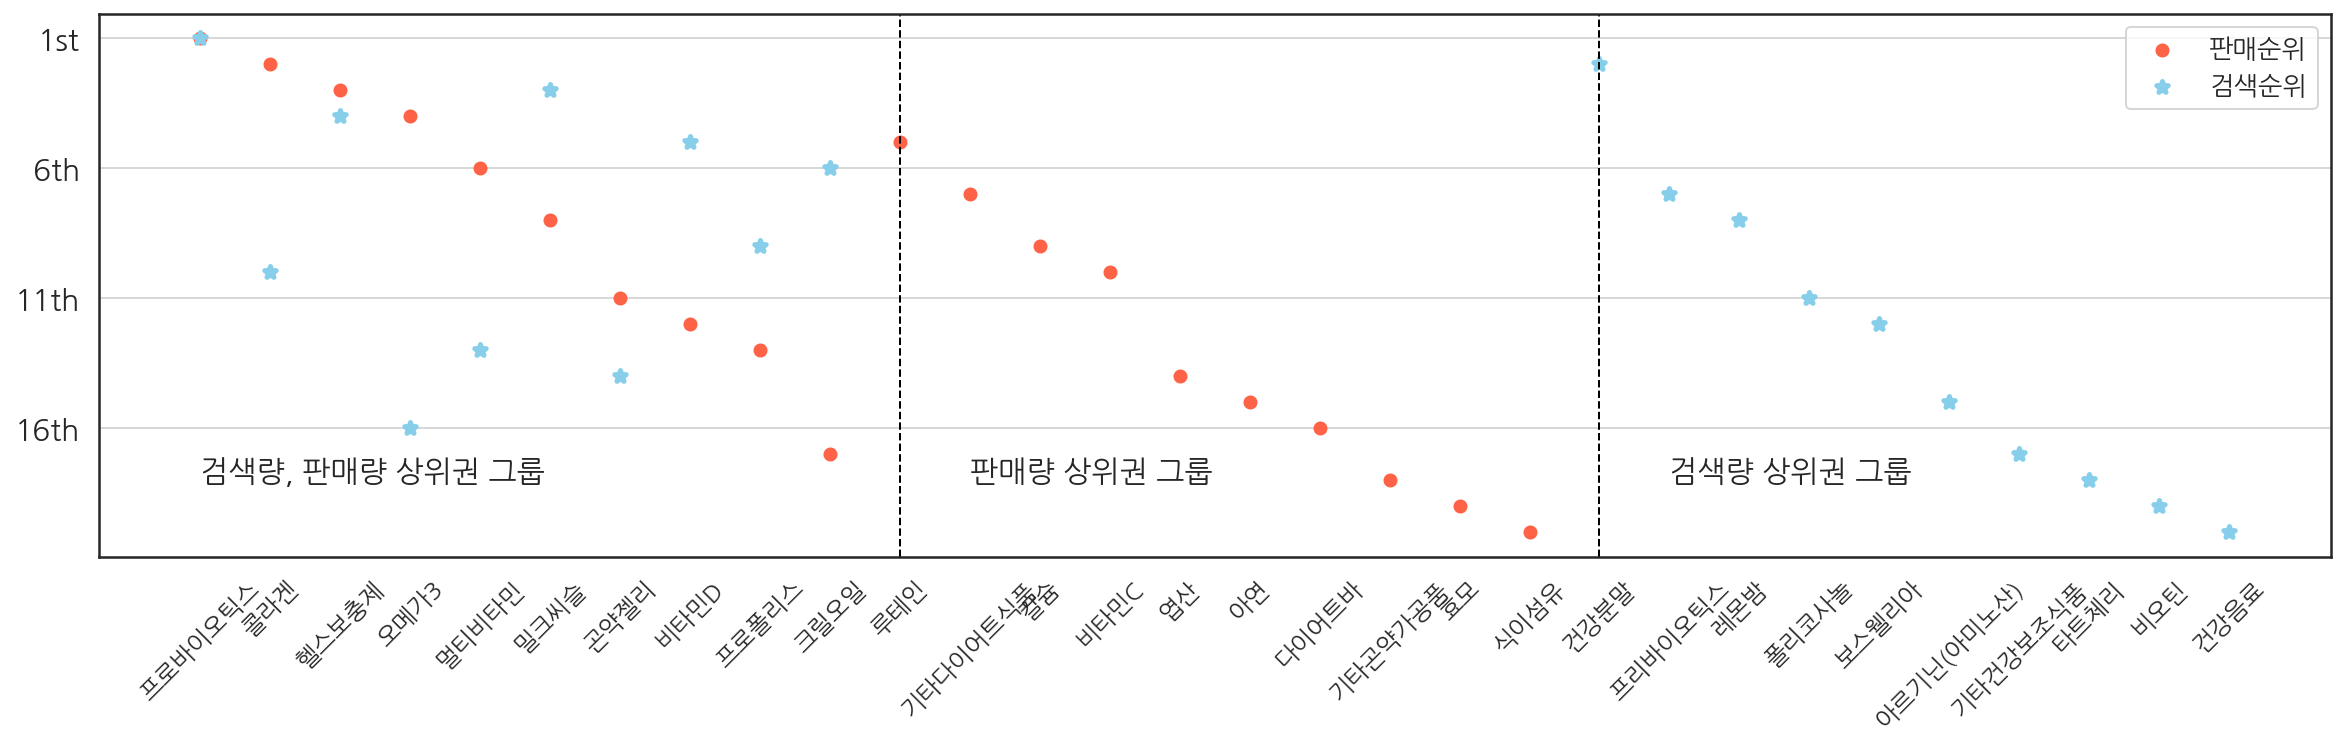

In [90]:
plt.figure(figsize=(20,5))
plt.scatter(rank_result.index, rank_result["sell_rank"], color="tomato", linewidth=1, label="판매순위")
plt.scatter(rank_result.index, rank_result["search_rank"], color="skyblue", 
            marker="*",  linewidth=2.5, label="검색순위")

plt.axvline(x="루테인", color="black", linestyle='--', linewidth=1) #그룹 구분을 위해 세로선 긋기
plt.axvline(x="건강분말", color="black", linestyle='--', linewidth=1) #그룹 구분을 위해 세로선 긋기

plt.gca().invert_yaxis() #1등이 제일 위에 오도록 
plt.xticks(rotation=45, fontsize=12)
plt.yticks(ticks=[1, 6, 11, 16], labels=["1st", "6th", "11th", "16th"], fontsize=15)
plt.grid(True, axis='y', color='grey', alpha=0.3)
plt.text("프로바이오틱스", 18, "검색량, 판매량 상위권 그룹", fontsize=15) #표에 텍스트 넣기
plt.text("기타다이어트식품", 18, "판매량 상위권 그룹", fontsize=15) #표에 텍스트 넣기
plt.text("프리바이오틱스", 18, "검색량 상위권 그룹", fontsize=15) #표에 텍스트 넣기
plt.legend(loc="upper right", fontsize=13)
plt.show()

In [91]:
df_total["sum"] = df_total.iloc[:,4:].sum(axis=1)

In [92]:
#전체 검색량 - 제품별, 남녀연령 합쳐서
#catename에 개별 제품을 리스트로 넣으면 되는 함수 
#labelname에 표의 이름을 넣어주세요!

def total_search(catelist, labelname) : 
    plt.figure(figsize=(15,5))
    
    for index, cate in enumerate(catelist) : 
        dummy = df_total[["yyyymm", "cate_5", "sum"]]
        dummy = dummy[dummy["cate_5"] == cate]
        dummy = dummy.groupby("yyyymm").sum()
        dummy = dummy[:-1]
    
        plt.plot(dummy.index, dummy["sum"], lw=1, alpha=0.85, label= f"{cate}")
    
    plt.xlabel(labelname)
    plt.xticks(["2018-01", "2018-07","2019-01", "2019-07","2020-01","2020-07", "2021-01"],
          labels = ["2018년 1월","2018년 7월","2019년 1월","2019년 7월","2020년 1월","2020년 7월", "2021년 1월"])

    plt.legend()
    plt.show()

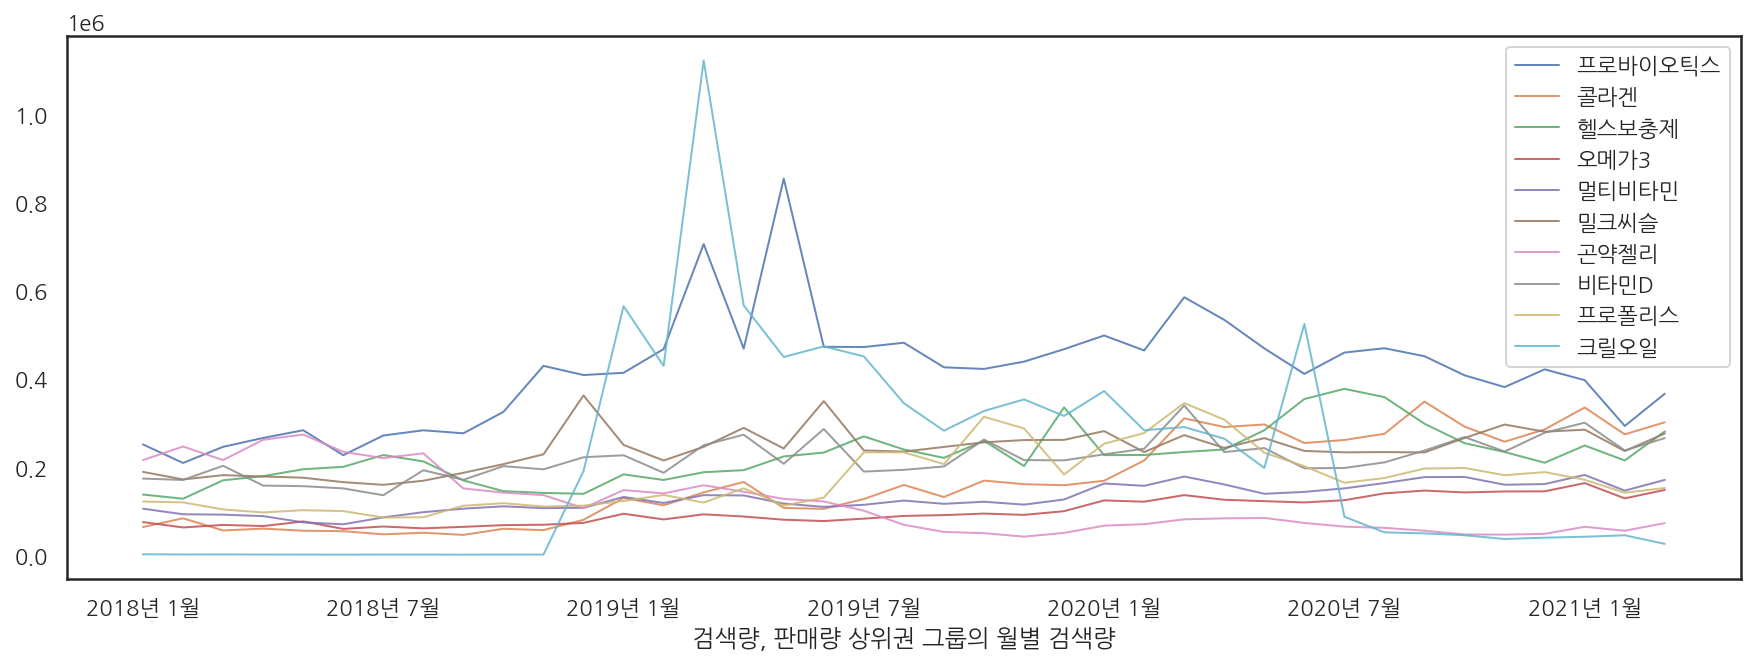

In [93]:
total_search(list(both_rank.index), "검색량, 판매량 상위권 그룹의 월별 검색량")

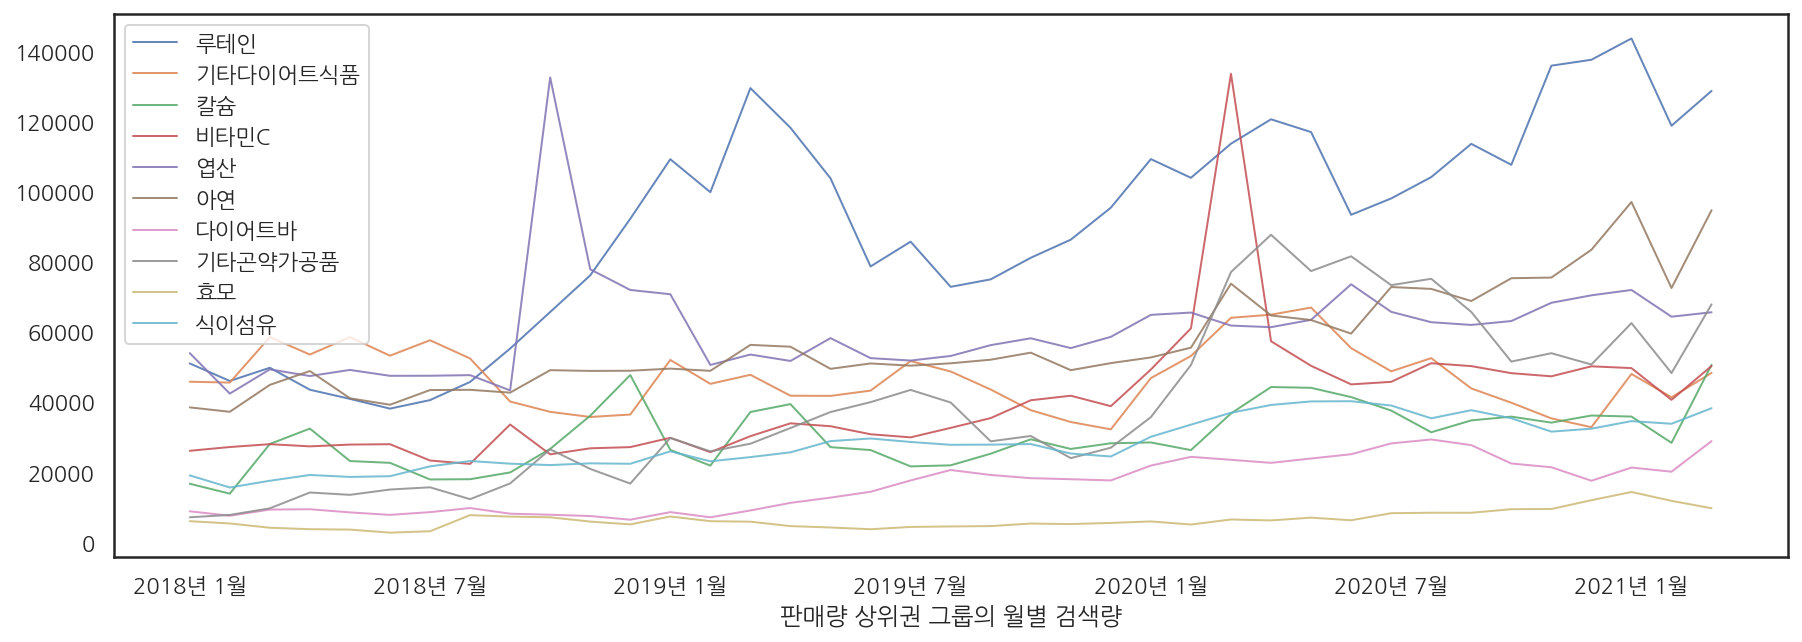

In [94]:
total_search(list(sell_ranking_only.index), "판매량 상위권 그룹의 월별 검색량")

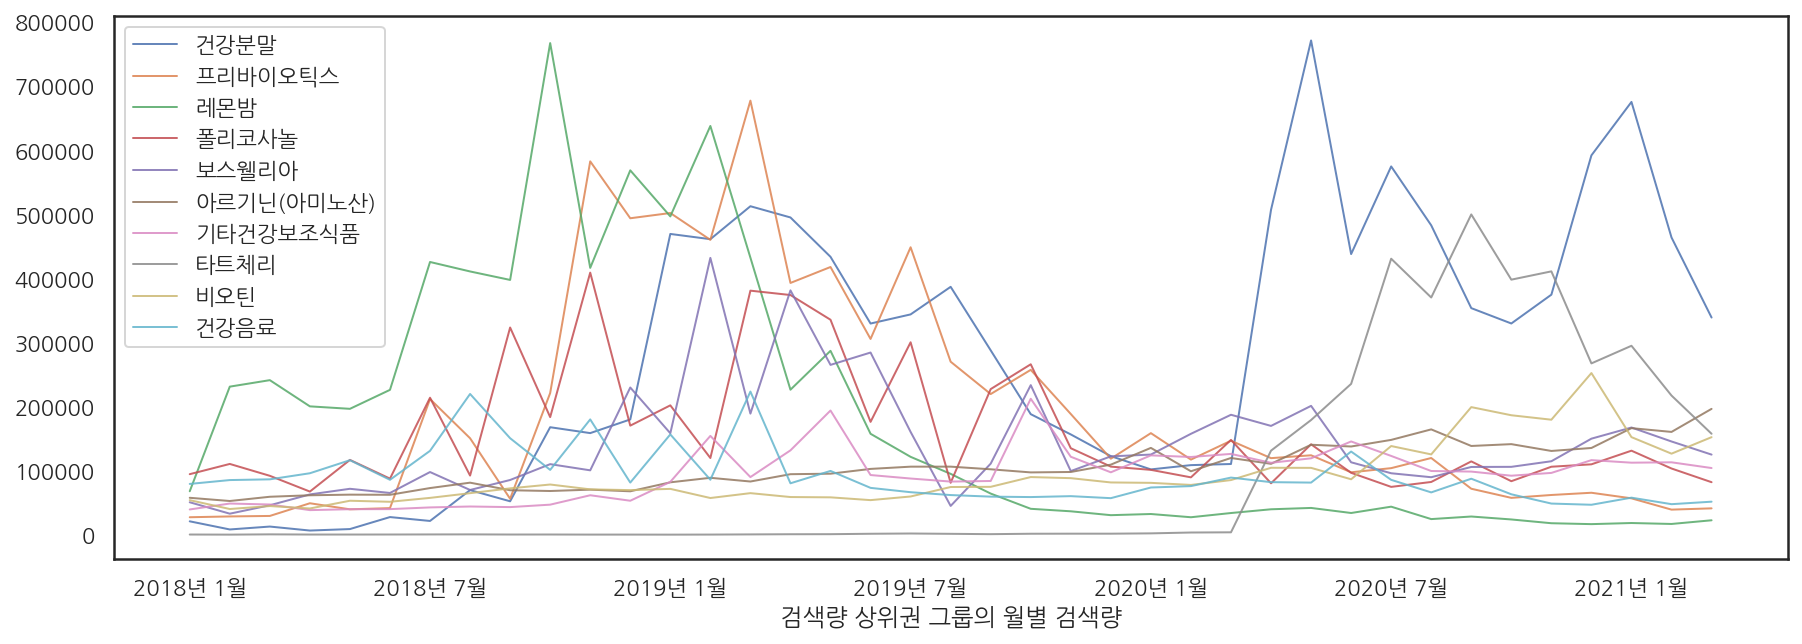

In [95]:
total_search(list(search_ranking_only.index), "검색량 상위권 그룹의 월별 검색량")

#### 추가분석! 제품 태그 분석하기 (검색량, 판매량 모두 상위권인 그룹!)
#### 어떤 태그가 잘 먹히는지 알아보자 
- 카테고리, 태그만 있는 데이터프레임 먼저 생성 
- searchtags 함수 : 해당 카테고리의 모든 태그를 찾아 리스트로 반환
- counter 함수 : 리스트로 반환된 전체 태그리스트에서 개별 태그와 개별 태그의 갯수를 딕셔너리로 반환
- fromtag_todf 함수 : 딕셔너리를 보기 편하게(?) 데이터프레임으로 반환하고 내림차순으로 sorting

In [96]:
#영양제 데이터에서 카테고리, 태그 가져오기 
nut_tag = nutrients[["cate_5", "tag"]]

In [97]:
#다이어트 식품에서 카테고리, 태그 가져오기
healthfood["cate_5"] = healthfood["cate_4"]
food_tag = healthfood[["cate_5", "tag"]]

In [98]:
#df_tag로 합치기 
df_tag = pd.concat([nut_tag, food_tag])
df_tag = df_tag.reset_index(drop = True)
df_tag = df_tag.rename(columns={"cate_5":"category"})

In [99]:
#Nan값 제외하기 
df_tag = df_tag.dropna()
df_tag = df_tag.reset_index(drop=True)

In [100]:
#상위권 그룹의 카테고리명 참고  
tag_list = list(both_rank.index)

In [101]:
#카테고리 값중 하나를 catename에 str 형태로 넣으면 됩니다  
#판매량, 검색량 상위인 카테고리 : 
#['프로바이오틱스', '콜라겐', '헬스보충제', '오메가3', '멀티비타민',
#'밀크씨슬', '곤약젤리', '비타민D', '프로폴리스', '크릴오일']
#해당 카테고리에 속하는 제품의 태그를 반환합니다 
def searchtags(catename) :
    dummytag = []
    for i in range(len(df_tag)) : 
        if df_tag["category"].iloc[i] == catename : 
            dummytag.append(df_tag["tag"][i])
        
    tag_total = ",".join(dummytag)
    tag_total = tag_total.split(",")
    print(f"{catename} tag search complete" )
    return tag_total

In [102]:
#태그 개수 counter 
#리스트를 넣으시면 개별 태그와 태그의 갯수를 딕셔너리 형태로 반환합니다 ({태그 : 갯수})
def counter(word_list):
    word_count = {}
    for word in word_list:
        if word in word_count:
            word_count[word] += 1
        else:
            word_count[word] = 1
    return word_count

In [103]:
#딕셔너리를 데이터프레임으로 변환
def fromtag_todf(word_count): 
    dummy_df = pd.DataFrame([word_count]).T.sort_values(by=0, ascending=False)
    dummy_df = dummy_df.rename(columns={0:"count"})
    return dummy_df

In [104]:
fromtag_todf(counter(searchtags("칼슘"))).head(20)

칼슘 tag search complete


count
영양제           49
아연            32
비타민D          31
비타민           29
뼈건강           27
건강            25
몸에좋은영양제       22
뼈에좋은칼슘        16
몸에좋은영양소       16
뼈             14
키즈비타민         11
천연            11
뼈에좋은영양제       11
멀티비타민         10
종합영양제         10
칼슘             9
합성             9
키즈             9
건강한            9
선물하기좋은영양제      9

## 잘 팔리는 제품과 잘 팔리지 않는 제품의 이유를 알아보자

### 설정

In [109]:
import platform
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt


import datetime # 날짜 바꾸끼
import os
import sys
import urllib.request
import json
import numpy as np
import pandas as pd
import copy
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import matplotlib as mpl
mpl.rcParams["axes.unicode_minus"] = False
import matplotlib.ticker as ticker

plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
elif platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Linux':
    rc('font', family='NanumBarunGothic')
else:
    print('Unknown system... sorry~~')

### 기본 파일 불러오기

In [110]:
# 다이어트식품 데이터 가져오기
dietfood = pd.read_csv("data/healthfood_preprocessing.csv", encoding='utf-8-sig')
# 영양제 데이터 가져오기
nutrients = pd.read_csv("data/pre_nutrients.csv", encoding='utf-8-sig')

### 데이터 정리하기

##### dietfood cate_5 만들어주기 (nutrients에만 cate_5 값이 있기 때문)

In [111]:
dietfood["cate_5"] = dietfood["cate_4"]

##### column 순서 바꿔주기
- 범주형 -> 수치형

In [112]:
nutrients = nutrients[["name", "brand", "cate_1", "cate_2", "cate_3", "cate_4", "cate_5", "tag", "price", "review", "purchaseCnt", "date"]]
dietfood = dietfood[["name", "brand", "cate_1", "cate_2", "cate_3", "cate_4", "cate_5", "tag", "price", "review", "purchaseCnt", "date"]]

##### concat 합치기
- reset index : index 초기화
- drop index column : 중복 index 컬럼 drop

In [113]:
df_concat = pd.concat([nutrients, dietfood])
df_concat.reset_index()
df_concat[["name", "brand", "cate_1", "cate_2", "cate_3", "cate_4", "cate_5", "tag", "price", "review", "purchaseCnt", "date"]]

name   brand cate_1  \
0                       SMDR 데이엔딩슬립스타트 (락티움 수면 영양제 보조제)     NaN     식품   
1       곤약 세라마이드+히알라스킨 먹는 인도 곤약감자추출물 히알루론산 /콜라겐,엘라스틴(부)  파이토뉴트리     식품   
2     곤약 세라마이드 - 먹는 인도 곤약감자 세라미드 추출물 피부영양제품 이너뷰티 비오틴(부)  파이토뉴트리     식품   
3                       효소원 N 발효 효소 소화 곡물 현미 제품 ( 90포 )     효소원     식품   
4     닥터스 베스트 Doctor’s Best 엑스트라 스트렝스 징코, 120mg, 베지 ...     NaN     식품   
...                                                 ...     ...    ...   
7709  하이드록시컷 Hydroxycut Pro Clinical Hydroxycut, Los...     NaN     식품   
7710  캘리포니아 골드 뉴트리션 California Gold Nutrition Golden...     NaN     식품   
7711               차병원 닥터프로그램 프로다이어틱스 3병 유산균 다이어트 체지방감소     NaN     식품   
7712  이클레틱 인스티튜션 Eclectic Institute Beet Juice POWde...     NaN     식품   
7713              히말리야 허벌 헬스케어 Himalaya 암라(Amla), 60 캡슐     NaN     식품   

      cate_2  cate_3    cate_4  cate_5                           tag  price  \
0       건강식품     영양제  기타건강보조식품   수면보조제                           NaN  64500   
1       건강식품     영양제  기타건강보조식품      곤약                피부영양제,기타건강기능식품  75800   
2       건강식품     영양제  기타건강보조식품      곤약  피부영양공급,피부영양제,피부장벽강화,기타건강보조식품  36500   
3       건강식품     영양제  기타건강보조식품      효소             현미효소,곡물효소,효소,발효효소  38000   
4       건강식품     영양제  기타건강보조식품   은행추출물                           NaN  10076   
...      ...     ...       ...     ...                           ...    ...   
7709  다이어트식품   헬스보충제     헬스보충제   헬스보충제                           NaN   6739   
7710  다이어트식품  기타건강식품    기타건강식품  기타건강식품                           NaN  12375   
7711  다이어트식품  기타건강식품    기타건강식품  기타건강식품                           NaN  43620   
7712  다이어트식품   다이어트차     다이어트차   다이어트차                           NaN  11363   
7713  다이어트식품   다이어트차     다이어트차   다이어트차                           NaN  15289   

      review  purchaseCnt      date  
0      16022            0  20191114  
1      20493         6296  20181214  
2      20279         5804  20180206  
3      16504        14875  20180622  
4      16217            0  20190807  
...      ...          ...       ...  
7709     255            0  20210327  
7710     241            0  20200308  
7711     223            0  20200114  
7712     216            0  20201206  
7713     204            0  20210218  

[15553 rows x 12 columns]

##### 날짜 바꾸기
1. int 타입을 str로 바꿔주기
- series.astype(str)
2. 바꿀 컬럼의 datetime format 확인하기
- pd.to_datetime(df[columm], infer_datetime_format=True)
3. str 타입 자료형 datetime 타입으로 바꿔주기
- pd.to_datetime(df[column], format="%Y%m%d)
4. yyyy-mm-dd 형태를 yymm으로 바꿔주기
- series.dt.strftime("%y%m")

In [114]:
pd.to_datetime(df_concat["date"], infer_datetime_format=True) # 데이트타임 날짜 포맷 확인
df_concat["date"] = pd.to_datetime(df_concat["date"], format="%Y%m%d") # 데이트타임 날짜 포맷으로 변경
df_concat["date"] = df_concat["date"].dt.strftime("%y%m") # 연/월 형태의 문자형으로 타입 변경
df_concat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15553 entries, 0 to 7713
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   name         15553 non-null  object
 1   brand        10377 non-null  object
 2   cate_1       15553 non-null  object
 3   cate_2       15553 non-null  object
 4   cate_3       15553 non-null  object
 5   cate_4       15543 non-null  object
 6   cate_5       15543 non-null  object
 7   tag          5803 non-null   object
 8   price        15553 non-null  int64 
 9   review       15553 non-null  int64 
 10  purchaseCnt  15553 non-null  int64 
 11  date         15553 non-null  object
dtypes: int64(3), object(9)
memory usage: 1.5+ MB


##### 여기까지 정리한 파일을 csv로 추출해주기

In [115]:
#df_concat.to_csv("data/check.csv", encoding='utf-8-sig')

##### date와 cate_5로 데이터 묶어주기 : groupby : 연월 yymm
- cate_5와 date 컬럼으로 groupby하여 review, purchaseCnt 값을 sum하여주고
- price를 mean으로 별도의 df로 저장한 뒤 price 컬럼을 옮김
- set_index를 이용하여 인덱스 값을 date로 재설정

In [116]:
total_month = df_concat[["cate_5", "review", "purchaseCnt", "date"]].groupby(["cate_5", "date"]).sum().reset_index() # sum으로 묶어주기
total_price = df_concat[["cate_5", "price", "date"]].groupby(["cate_5", "date"]).mean().reset_index() # price는 mean으로 별도로 묶어주기
total_month["price_avg"] = round(total_price["price"]) # price 값 만들기
total_month = total_month.set_index(total_month["date"]) # 날짜를 인덱스로 만들어주기
total_month = total_month.drop("date", axis=1) # 중복 컬럼 삭제(date)
total_month = total_month.reset_index() # 날짜 컬럼으로 인덱스 리셋하기

##### 검색량 데이터 추가하기

- 데이터 불러오기
- merge를 이용하여 합치기 (month 먼저)
- total_month + df_group_month : 쇼핑 판매데이터 + 트랜드 검색데이터 합치기

In [117]:
# 파일 import하여 개별 데이터프레임으로 만들기 
f_kid = pd.read_csv("data/f_kid.csv", encoding = "utf-8-sig")
f_20 = pd.read_csv("data/f_20.csv", encoding = "utf-8-sig")
f_30 = pd.read_csv("data/f_30.csv", encoding = "utf-8-sig")
f_40 = pd.read_csv("data/f_40.csv", encoding = "utf-8-sig")
f_senior = pd.read_csv("data/f_senior.csv", encoding = "utf-8-sig")
m_kid = pd.read_csv("data/m_kid.csv", encoding = "utf-8-sig")
m_20 = pd.read_csv("data/m_20.csv", encoding = "utf-8-sig")
m_30 = pd.read_csv("data/m_30.csv", encoding = "utf-8-sig")
m_40 = pd.read_csv("data/m_40.csv", encoding = "utf-8-sig")
m_senior = pd.read_csv("data/m_senior.csv", encoding = "utf-8-sig")
file_list = [m_kid, m_20, m_30, m_40, m_senior, f_kid, f_20, f_30, f_40, f_senior]
name_list = ["남성_미성년자", "남성_20대", "남성_30대", "남성_40대", "남성_50대이상", 
            "여성_미성년자", "여성_20대", "여성_30대", "여성_40대", "여성_50대이상"]
# 데이터프레임 모양 변환을 위한 함수 생성
def preprocess(dataframe) : 
    dataframe = dataframe.set_index("date")
    dataframe = pd.DataFrame(dataframe.stack())
    dataframe = dataframe.reset_index()
    return dataframe
# 데이터프레임에 함수 적용 
df_m_kid = preprocess(m_kid)
df_m_20 = preprocess(m_20)
df_m_30 = preprocess(m_30)
df_m_40 = preprocess(m_40)
df_m_senior = preprocess(m_senior)
df_f_kid = preprocess(f_kid)
df_f_20 = preprocess(f_20)
df_f_30 = preprocess(f_30)
df_f_40 = preprocess(f_40)
df_f_senior = preprocess(f_senior)
#데이터프레임 merge로 합치기 
df_total = pd.DataFrame()
df_total = pd.merge(left = df_m_kid, right = df_m_20, how = "outer", on = ["date", "level_1"] )
df_total = pd.merge(left = df_total, right = df_m_30, how = "outer", on = ["date", "level_1"] )
df_total = pd.merge(left = df_total, right = df_m_40, how = "outer", on = ["date", "level_1"] )
df_total = pd.merge(left = df_total, right = df_m_senior, how = "outer", on = ["date", "level_1"] )
df_total = pd.merge(left = df_total, right = df_f_kid, how = "outer", on = ["date", "level_1"] )
df_total = pd.merge(left = df_total, right = df_f_20, how = "outer", on = ["date", "level_1"] )
df_total = pd.merge(left = df_total, right = df_f_30, how = "outer", on = ["date", "level_1"] )
df_total = pd.merge(left = df_total, right = df_f_40, how = "outer", on = ["date", "level_1"] )
df_total = pd.merge(left = df_total, right = df_f_senior, how = "outer", on = ["date", "level_1"] )
#column명 재설정 
df_total.columns = ["date", "cate_5", "남성_미성년자", "남성_20대", "남성_30대", "남성_40대", "남성_50대이상", 
            "여성_미성년자", "여성_20대", "여성_30대", "여성_40대", "여성_50대이상"]

##### csv로 보내서 파일 확인하기

In [118]:
#df_total.to_csv("data/shopping_total.csv", encoding='utf-8-sig')

## 쇼핑 데이터와 검색데이터 합치기

In [119]:
total_month["date"] = total_month["date"].astype(int)
df_merge = pd.merge(left=total_month, right=df_total, how='inner', on=["date","cate_5"]) # merge, 쇼핑 왼쪽, 검색 오른쪽, 이너로 합치고 키값은 날짜와 카테고리
df_merge["total_search"] = df_merge.iloc[:, 6:].sum(axis=1) # 총 검색량 컬럼 값 만들기
total = df_merge # total로 저장
# 컬럼 순서 바꿔주기
total = total[["date", "cate_5", "review", "purchaseCnt", "price_avg", "total_search", "남성_미성년자", "남성_20대", "남성_30대", "남성_40대", "남성_50대이상", "여성_미성년자", "여성_20대", "여성_30대", "여성_40대", "여성_50대이상"]]

##### 2018년 이후 데이터로 정리하기
- (1) date 컬럼에서 2018년도이후로 잘라내기
- (2) date 컬럼에서 18, 19, 20년도 별도로 잡아내기

In [120]:
total_mask = total["date"] > 1712 # 18년부터
total_mask2 = total["date"] < 2103 # 21년까지(4월은 데이터값이 얼마 없기 때문에 drop)
total_over_18 = total[total_mask] # 18년도부터로 필터 씌워주고
total_under_21 = total_over_18[total_mask2] #21년3월이하로 필터 씌워주면 끝

##### 3개년 판매 top20와 bottom20 잡아내기

In [121]:
top_20 = total_under_21.sort_values("purchaseCnt", ascending=False)
top_20 = top_20.iloc[:20]
bottom_20 = total_under_21.sort_values("purchaseCnt", ascending=False)
bottom_20 = bottom_20.iloc[-20:]

##### 검색 데이터 처리하기

In [127]:
# 데이터 불러오기
top_10_search = pd.read_csv("data/total_search.csv", encoding='utf-8-sig')
top_10_search = top_10_search.drop('Unnamed: 0', axis=1)
# 데이터 정리하기 (쇼핑데이터와 마찬가지)
top_10_search["total_search"] = top_10_search.iloc[:, 4:].sum(axis=1)
top_10_search = top_10_search[["cate_5", "total_search"]].groupby("cate_5").sum()
top_10_search = top_10_search.sort_values("total_search", ascending=False)
top_10_search = top_10_search.reset_index()
top_10_search = top_10_search.iloc[:20]
top_10_search["rank"] = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
top_10_search = top_10_search.set_index("rank")

##### 쇼핑 데이터 처리하기

In [128]:
# 데이트를 드롭하고 카테고리만으로 묶어서 sum값으로 만들기
cate_sum = total_under_21[["cate_5", "review", "purchaseCnt", "total_search"]].groupby("cate_5").sum()
# 구매건수를 내림차순으로 정렬하기(순위 나누기 위해서)
cate_sum = cate_sum.sort_values("purchaseCnt", ascending=False)
# 인덱스 초기화하기
cate_sum = cate_sum.reset_index()
# 구매건수 기준 상위 10개 제품 자르기
top_10_product = cate_sum.iloc[:10]
# 구매건수 기준 하위 10개 제품 자르기
bottom_10_product = cate_sum.iloc[-10:]
# 쇼핑 구매건수 상위 20개 제품 자르기
top_20 = cate_sum.iloc[:20]
# 쇼핑 구매건수 하위 20개 제품 자르기
bottom_20 = cate_sum.iloc[-20:]
# 상위 20개 제품 랭크 만들고 랭크를 인덱스로 바꿔주기
top_20["rank"] = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
top_20 = top_20.set_index("rank")
# 검색/쇼핑에만 있는 랭크 데이터 마스킹하기 - 그래프용
masking1 = (total_under_21["cate_5"] == "루테인") | (total_under_21["cate_5"] == "기타다이어트식품") | (total_under_21["cate_5"] == "칼슘") | (total_under_21["cate_5"] == "다이어트바") | (total_under_21["cate_5"] == "기타곤약가공품") | (total_under_21["cate_5"] == "아연") | (total_under_21["cate_5"] == "엽산") | (total_under_21["cate_5"] == "비타민C") | (total_under_21["cate_5"] == "가르시니아")
masking2 = (total_under_21["cate_5"] == "건강분말") | (total_under_21["cate_5"] == "프리바이오틱스") | (total_under_21["cate_5"] == "레몬밤") | (total_under_21["cate_5"] == "폴리코사놀") | (total_under_21["cate_5"] == "보스웰리아") | (total_under_21["cate_5"] == "아르기닌(아미노산)") | (total_under_21["cate_5"] == "타트체리") | (total_under_21["cate_5"] == "비오틴") | (total_under_21["cate_5"] == "건강음료")
masking_shopping = total_under_21[masking1]
masking_shopping = masking_shopping.iloc[1:]
masking_searching = total_under_21[masking2]
# 카테고리 순위 교집합, 차집합으로 나누기 -그래프 그리기용
masking_common_shopping = (top_20["cate_5"] == "프로바이오틱스") | (top_20["cate_5"] == "헬스보충제") | (top_20["cate_5"] == "콜라겐") | (top_20["cate_5"] == "밀크씨슬") | (top_20["cate_5"] == "비타민D") | (top_20["cate_5"] == "크릴오일") | (top_20["cate_5"] == "프로폴리스") | (top_20["cate_5"] == "오메가3") | (top_20["cate_5"] == "기타건강보조식품") | (top_20["cate_5"] == "멀티비타민") | (top_20["cate_5"] == "곤약젤리")
masking_non_common_shopping = (top_20["cate_5"] == "루테인") | (top_20["cate_5"] == "기타다이어트식품") | (top_20["cate_5"] == "칼슘") | (top_20["cate_5"] == "다이어트바") | (top_20["cate_5"] == "기타곤약가공품") | (top_20["cate_5"] == "아연") | (top_20["cate_5"] == "엽산") | (top_20["cate_5"] == "비타민C") | (top_20["cate_5"] == "가르시니아")
masking_common_search = (top_10_search["cate_5"] == "프로바이오틱스") | (top_10_search["cate_5"] == "헬스보충제") | (top_10_search["cate_5"] == "콜라겐") | (top_10_search["cate_5"] == "밀크씨슬") | (top_10_search["cate_5"] == "비타민D") | (top_10_search["cate_5"] == "크릴오일") | (top_10_search["cate_5"] == "프로폴리스") | (top_10_search["cate_5"] == "오메가3") | (top_10_search["cate_5"] == "기타건강보조식품") | (top_10_search["cate_5"] == "멀티비타민") | (top_10_search["cate_5"] == "곤약젤리")
masking_non_common_search = (top_10_search["cate_5"] == "건강분말") | (top_10_search["cate_5"] == "프리바이오틱스") | (top_10_search["cate_5"] == "레몬밤") | (top_10_search["cate_5"] == "폴리코사놀") | (top_10_search["cate_5"] == "보스웰리아") | (top_10_search["cate_5"] == "아르기닌(아미노산)") | (top_10_search["cate_5"] == "타트체리") | (top_10_search["cate_5"] == "비오틴") | (top_10_search["cate_5"] == "건강음료")
# df로 저장하기
top_10_common1 = top_20[masking_common_shopping]
top_10_common2 = top_10_search[masking_common_search]
top_10_non_common1 = top_20[masking_non_common_shopping]
top_10_non_common2 = top_10_search[masking_non_common_search]
# 판매 상위 10개 제품 데이터를 date가 있는 원본 total_under_21 df를 기반으로 만들어주기
tc1 = total_under_21[total_under_21['cate_5'] == '프로바이오틱스']
tc2 = total_under_21[total_under_21['cate_5'] == '콜라겐']
tc3 = total_under_21[total_under_21['cate_5'] == '헬스보충제']
tc4 = total_under_21[total_under_21['cate_5'] == '루테인']
tc5 = total_under_21[total_under_21['cate_5'] == '오메가3']
tc6 = total_under_21[total_under_21['cate_5'] == '기타다이어트식품']
tc7 = total_under_21[total_under_21['cate_5'] == '멀티비타민']
tc8 = total_under_21[total_under_21['cate_5'] == '곤약젤리']
tc9 = total_under_21[total_under_21['cate_5'] == '밀크씨슬']
tc10 = total_under_21[total_under_21['cate_5'] == '칼슘']
top10 = pd.concat([tc1, tc2, tc3, tc4, tc5, tc6, tc7, tc8, tc9, tc10])
# 판매 하위 10개 제품 데이터를 date가 있는 원본 total_under_21 df를 기반으로 만들어주기
bc1 = total_under_21[total_under_21['cate_5'] == '꿀']
bc2 = total_under_21[total_under_21['cate_5'] == '나토키나제']
bc3 = total_under_21[total_under_21['cate_5'] == '스쿠알렌']
bc4 = total_under_21[total_under_21['cate_5'] == '대구 간유']
bc5 = total_under_21[total_under_21['cate_5'] == '퀘르세틴']
bc6 = total_under_21[total_under_21['cate_5'] == '폴리페놀']
bc7 = total_under_21[total_under_21['cate_5'] == '마늘']
bc8 = total_under_21[total_under_21['cate_5'] == '베타인 HCL']
bc9 = total_under_21[total_under_21['cate_5'] == '비타민E']
bc10 = total_under_21[total_under_21['cate_5'] == '타우린']
bottom10 = pd.concat([bc1, bc2, bc3, bc4, bc5, bc6, bc7, bc8, bc9, bc10])

##### date 타입 str로 바꿔주기

In [129]:
total_under_21.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1637 entries, 0 to 1745
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1637 non-null   object 
 1   cate_5        1637 non-null   object 
 2   review        1637 non-null   int64  
 3   purchaseCnt   1637 non-null   int64  
 4   price_avg     1637 non-null   float64
 5   total_search  1637 non-null   float64
 6   남성_미성년자       1637 non-null   float64
 7   남성_20대        1637 non-null   float64
 8   남성_30대        1637 non-null   float64
 9   남성_40대        1637 non-null   float64
 10  남성_50대이상      1637 non-null   float64
 11  여성_미성년자       1637 non-null   float64
 12  여성_20대        1637 non-null   float64
 13  여성_30대        1637 non-null   float64
 14  여성_40대        1637 non-null   float64
 15  여성_50대이상      1637 non-null   float64
dtypes: float64(12), int64(2), object(2)
memory usage: 217.4+ KB


In [130]:
total_under_21["date"] = total_under_21["date"].astype(str)
bottom10["date"] = bottom10["date"].astype(str)
# top_20["date"] = top_20["date"].astype(str)

###### 시각화 1_ 제품 순위별 구매건수와 검색량 비교
- top 10 제품의 구매건수와 검색량
- bottom 10 제품의 구매건수와 검색량

(1) top 10 제품들은 대체로 구매건수와 검색량의 그래프가 비슷하다
(2) bottom 10 제품들은 구매건수(리뷰수)와 검색량의 그래프가 전혀 다르다

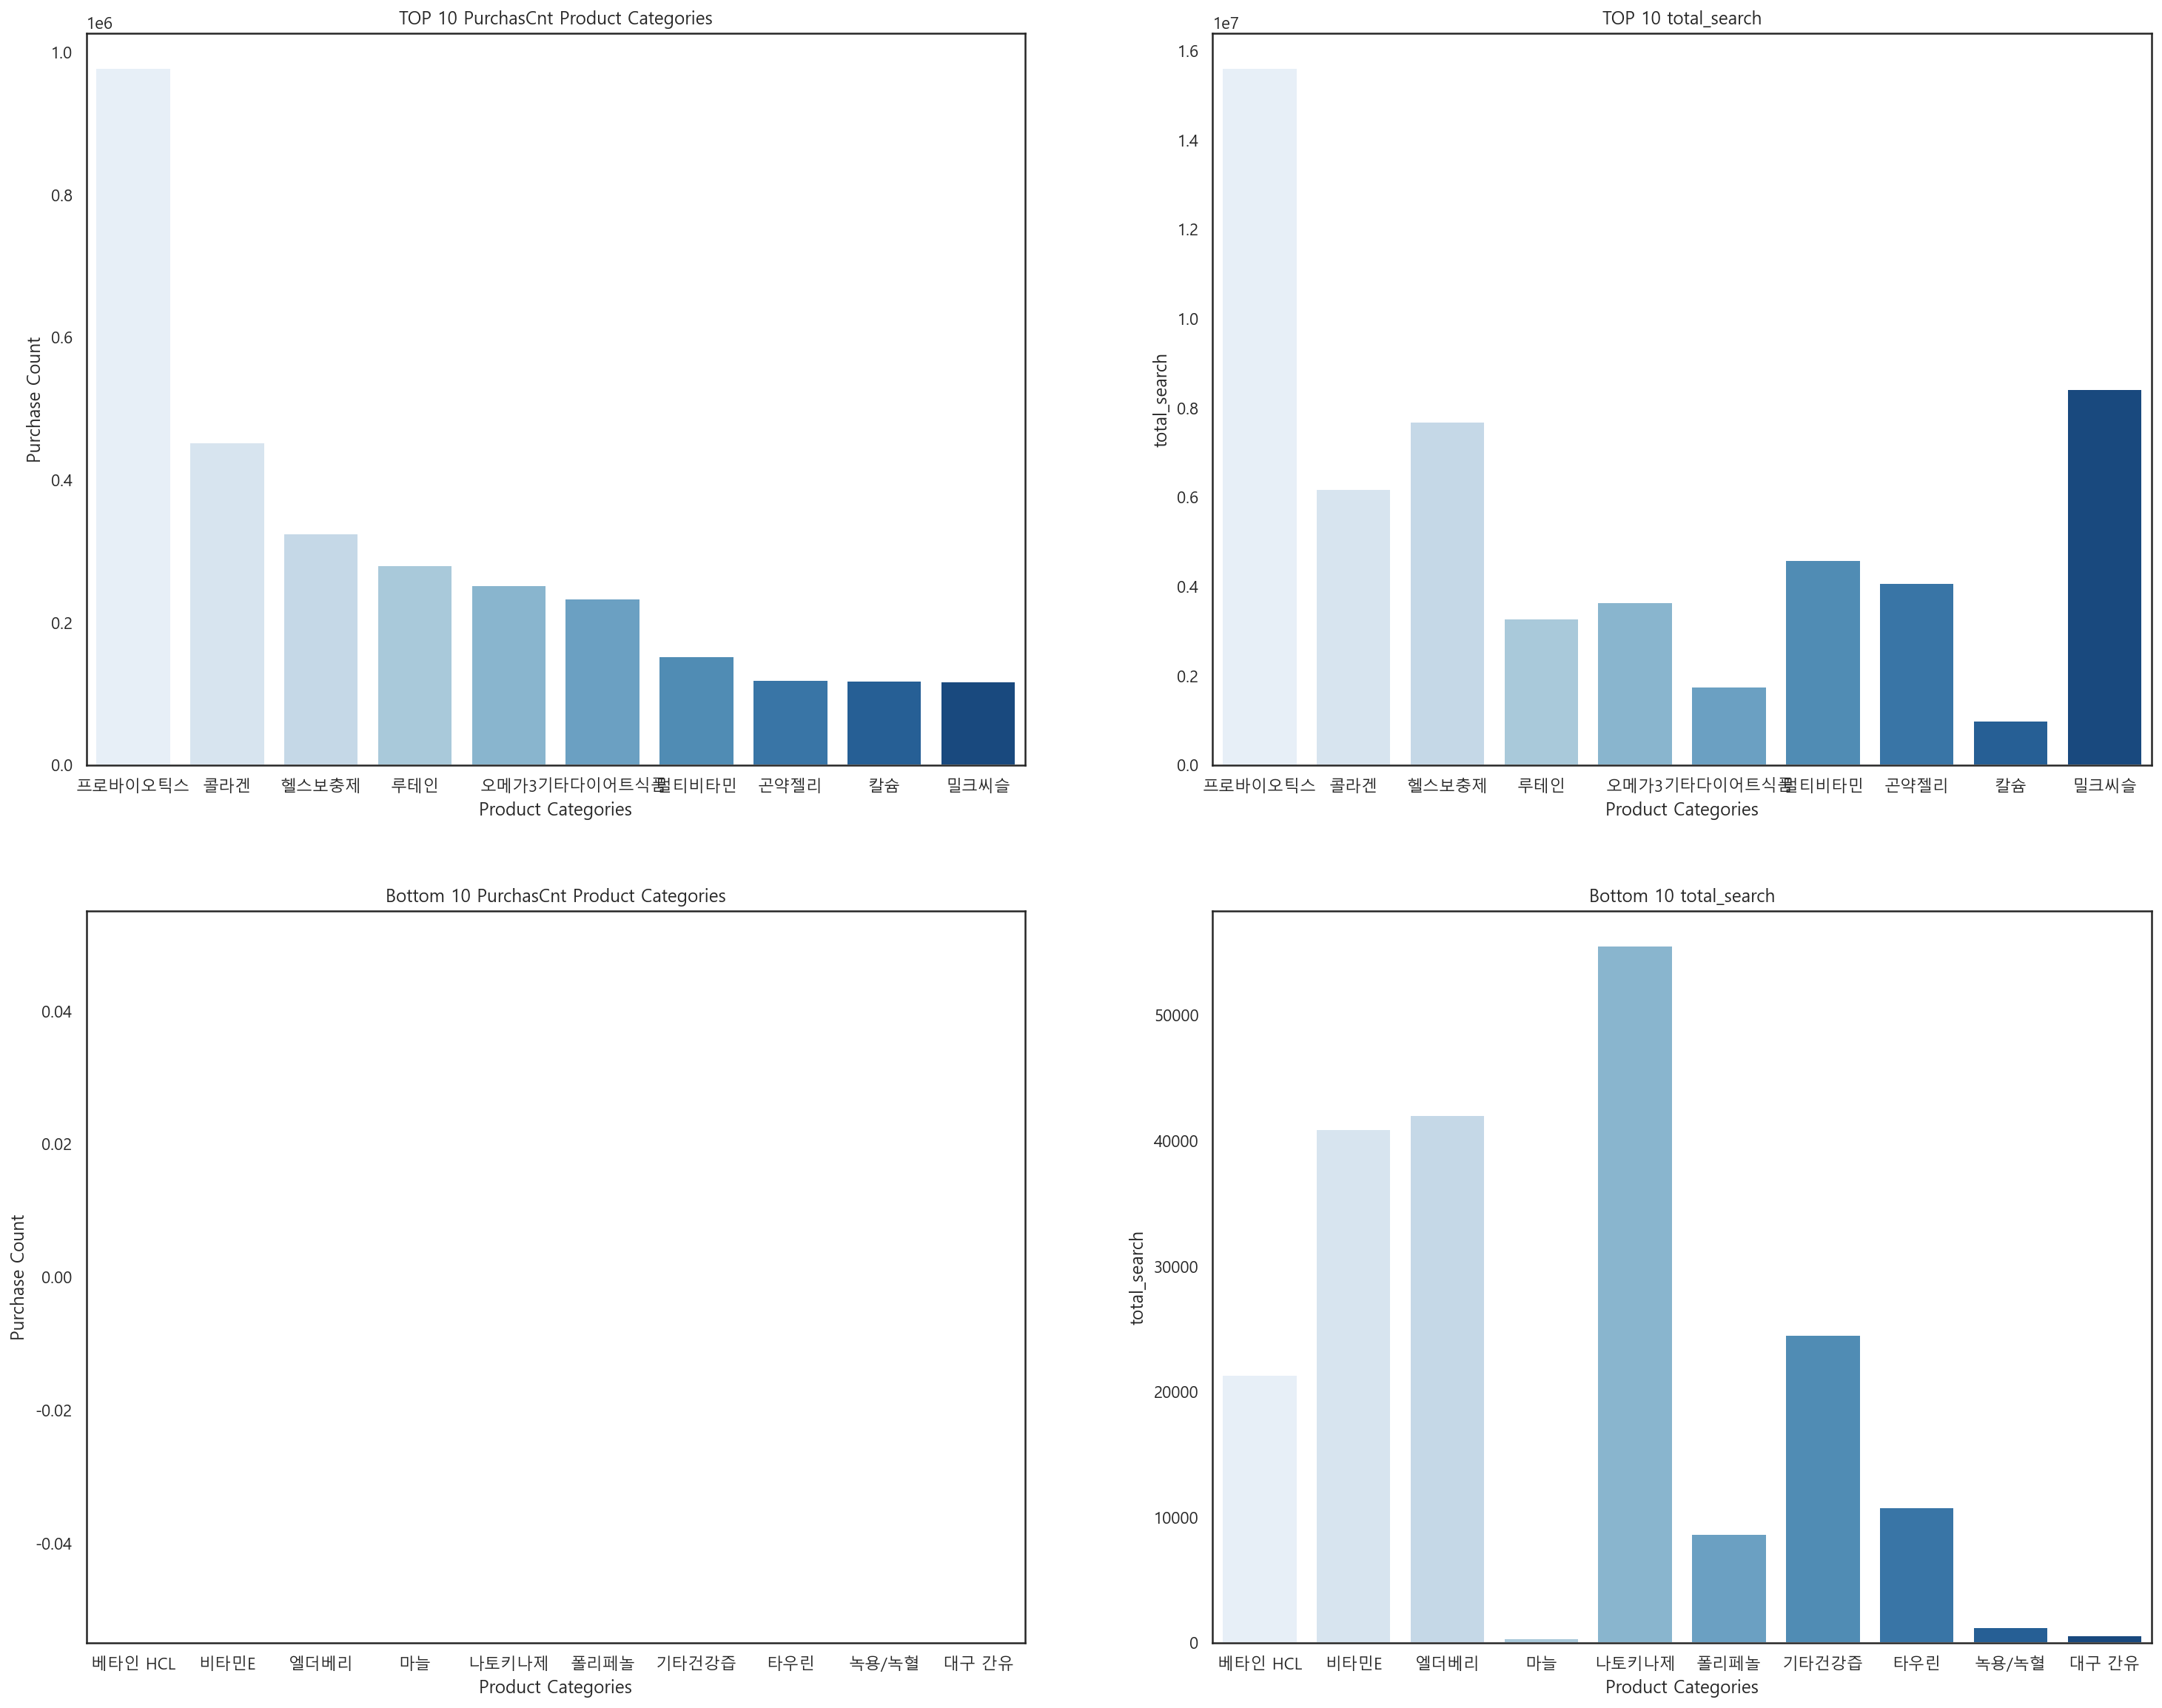

In [131]:
plt.figure(figsize=(25,20))

plt.subplot(221)
sns.barplot(x=top_10_product["cate_5"], y=top_10_product["purchaseCnt"], data=top_10_product, palette='Blues')
plt.title('TOP 10 PurchasCnt Product Categories')
plt.xlabel('Product Categories')
plt.ylabel('Purchase Count')

plt.subplot(222)
sns.barplot(x=top_10_product["cate_5"], y=top_10_product["total_search"], data=top_10_product, palette='Blues')
plt.title('TOP 10 total_search')
plt.xlabel('Product Categories')
plt.ylabel('total_search')

plt.subplot(223)
sns.barplot(x=bottom_10_product["cate_5"], y=bottom_10_product["purchaseCnt"], data=bottom_10_product, palette='Blues')
plt.title('Bottom 10 PurchasCnt Product Categories')
plt.xlabel('Product Categories')
plt.ylabel('Purchase Count')

plt.subplot(224)
sns.barplot(x=bottom_10_product["cate_5"], y=bottom_10_product["total_search"], data=bottom_10_product, palette='Blues')
plt.title('Bottom 10 total_search')
plt.xlabel('Product Categories')
plt.ylabel('total_search')

plt.show()

##### 제품 순위별 리뷰수와 검색수 비교
(1) top 10 제품들의 리뷰수와 검색수는 대체로 비슷하다

(2) bottom 10 제품들의 리뷰수와 검색수는 전혀 다르다

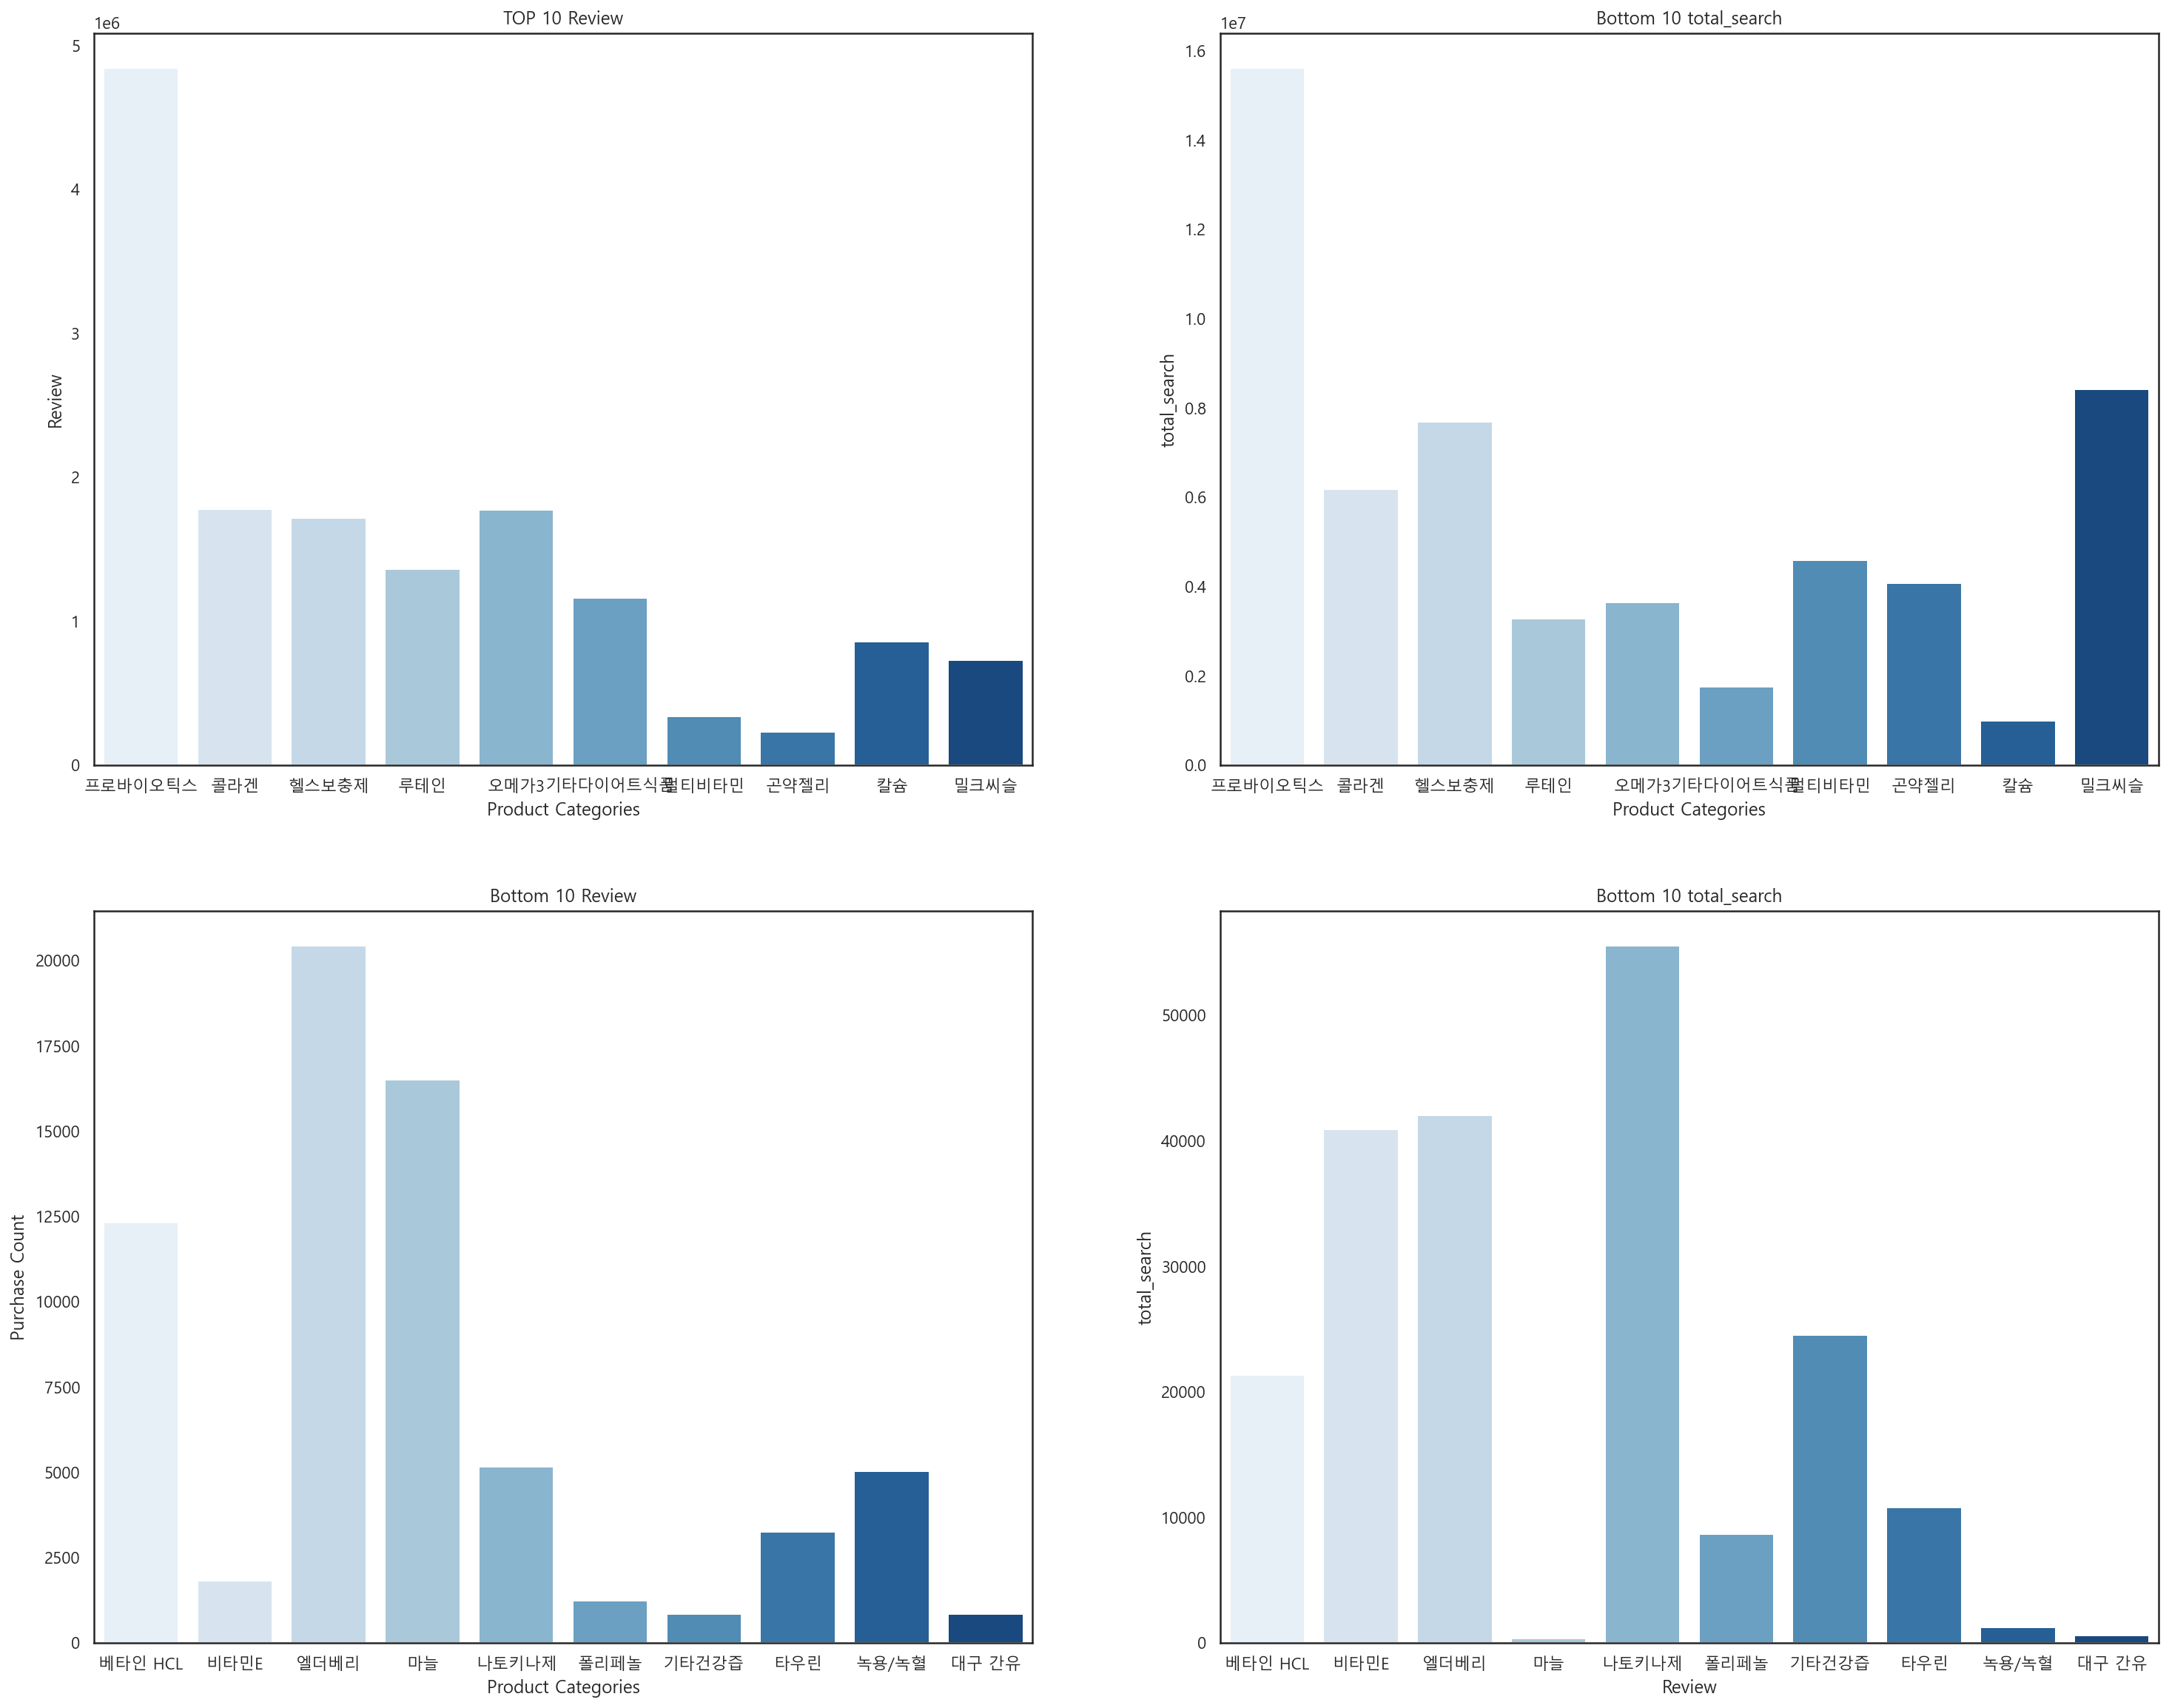

In [132]:
plt.figure(figsize=(25,20))

plt.subplot(221)
sns.barplot(x=top_10_product["cate_5"], y=top_10_product["review"], data=top_10_product, palette='Blues')
plt.title('TOP 10 Review')
plt.xlabel('Product Categories')
plt.ylabel('Review')

plt.subplot(222)
sns.barplot(x=top_10_product["cate_5"], y=top_10_product["total_search"], data=top_10_product, palette='Blues')
plt.title('Bottom 10 total_search')
plt.xlabel('Product Categories')
plt.ylabel('total_search')

plt.subplot(223)
sns.barplot(x=bottom_10_product["cate_5"], y=bottom_10_product["review"], data=bottom_10_product, palette='Blues')
plt.title('Bottom 10 Review')
plt.xlabel('Product Categories')
plt.ylabel('Purchase Count')

plt.subplot(224)
sns.barplot(x=bottom_10_product["cate_5"], y=bottom_10_product["total_search"], data=bottom_10_product, palette='Blues')
plt.title('Bottom 10 total_search')
plt.xlabel('Review')
plt.ylabel('total_search')

plt.show()

##### 판매 상위 20개 제품의 쇼핑/검색 데이터 비교하기
- 221 : 쇼핑의 상위 20개 제품 중, 쇼핑/검색 공통 카테고리 (purchaseCnt)
- 222 : 검색의 상위 20개 제품 중, 쇼핑/검색 공통 카테고리 (total_search)

(1) 구매건수가 높은 제품들은 검색수도 높다

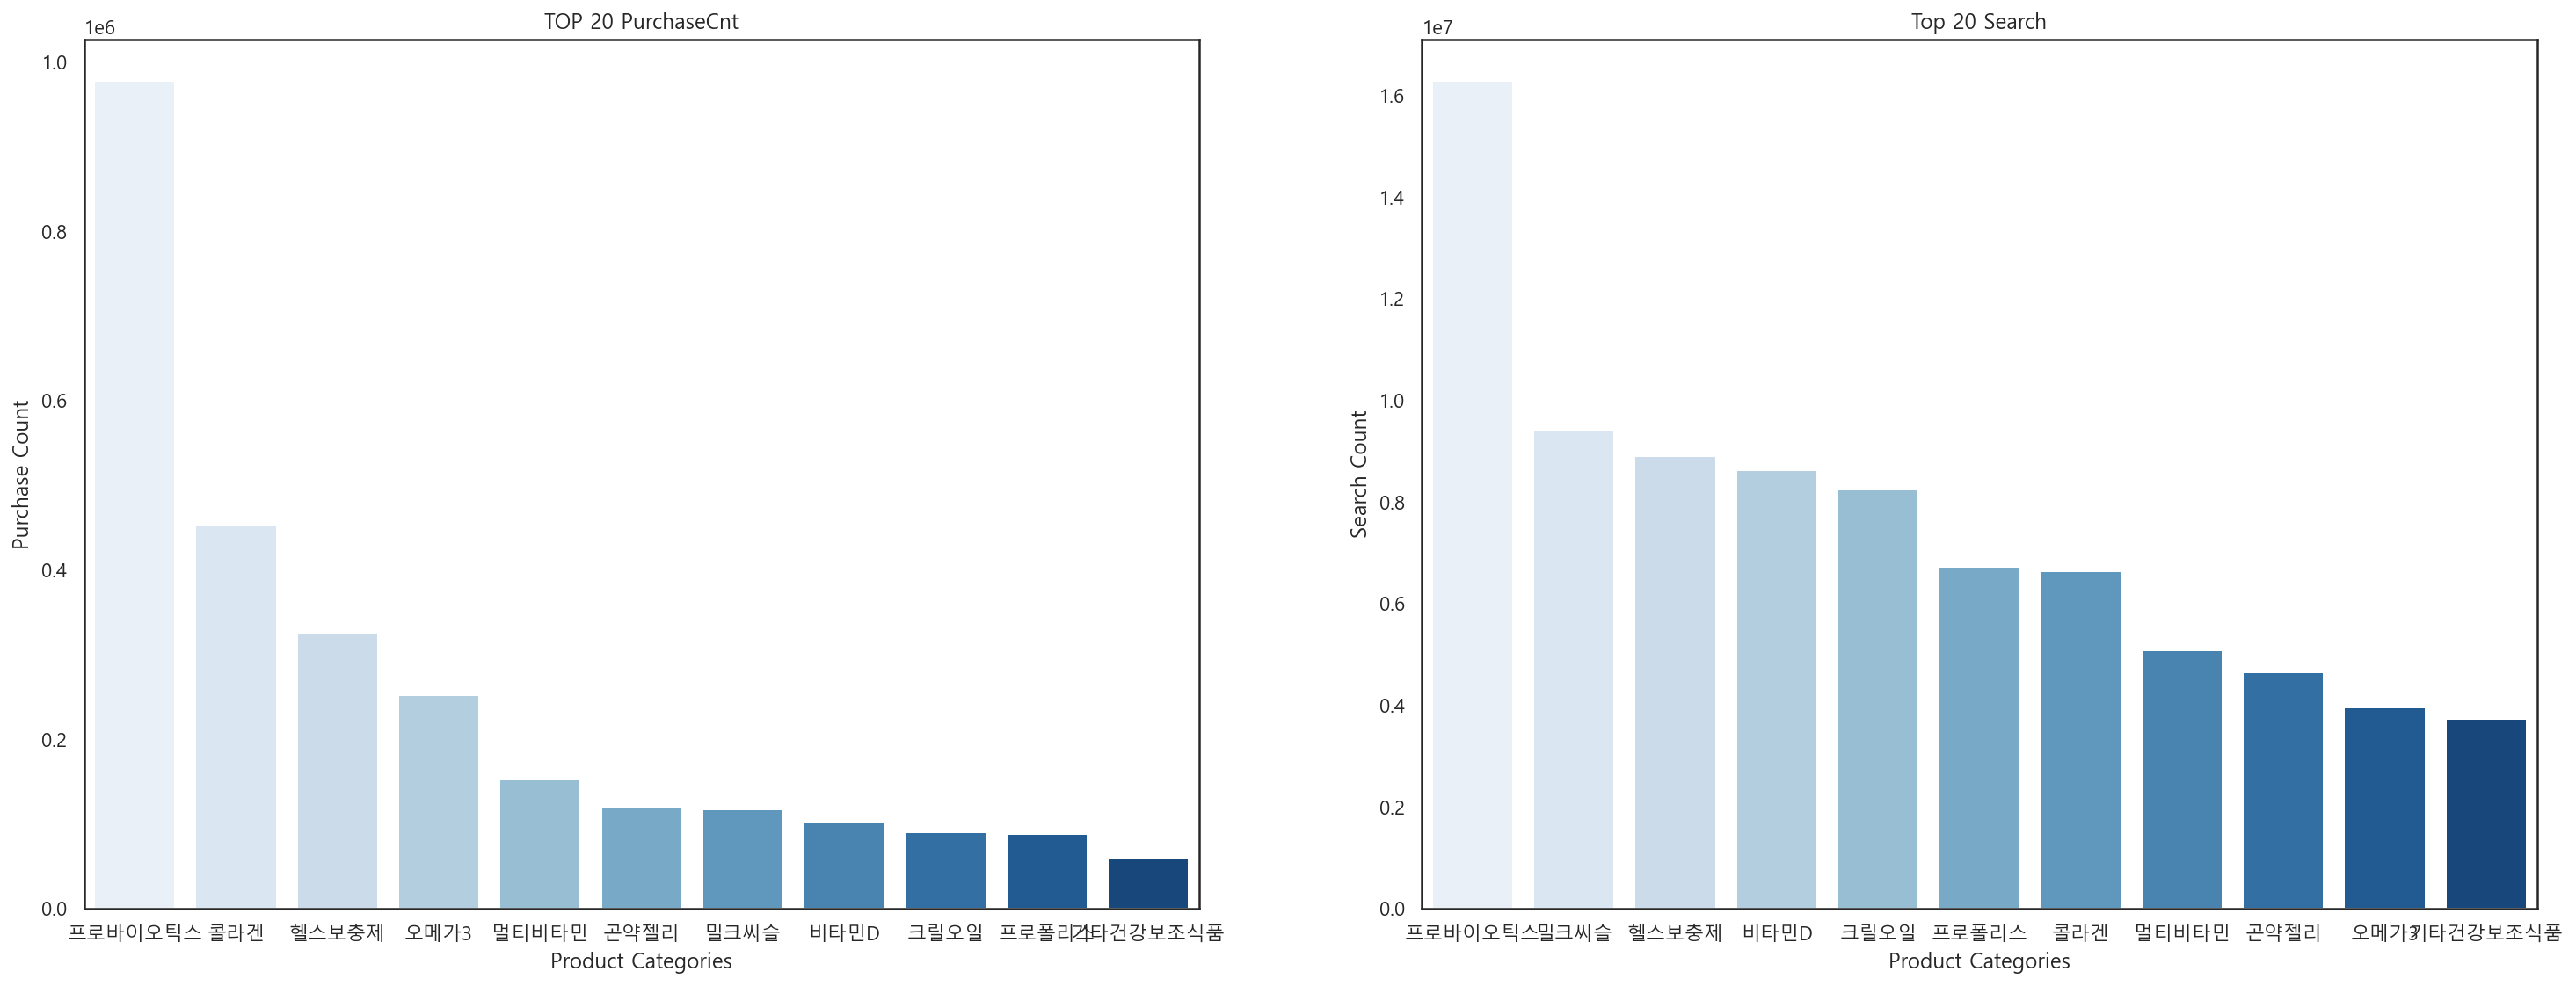

In [133]:
plt.figure(figsize=(25,20))

plt.subplot(221)
sns.barplot(x=top_10_common1["cate_5"], y=top_10_common1["purchaseCnt"], data=top_10_common1, palette='Blues')
plt.title('TOP 20 PurchaseCnt')
plt.xlabel('Product Categories')
plt.ylabel('Purchase Count')

plt.subplot(222)
sns.barplot(x=top_10_common2["cate_5"], y=top_10_common2["total_search"], data=top_10_common2, palette='Blues')
plt.title('Top 20 Search')
plt.xlabel('Product Categories')
plt.ylabel('Search Count')

plt.show()

##### 판매 상위 20개 제품의 쇼핑/검색 랭크에 겹치지 않는 제품군 구매건수/검색수 비교
- 223 : 쇼핑의 상위 20개 제품중, 쇼핑에만 있는 카테고리 (purchaseCnt)의 구매건수와 검색수
- 224 : 검색의 상위 20개 제품중, 검색에만 있는 카테고리 (total_search)의 구매건수와 검색수

(1) 쇼핑에서 상위 20개에 포함된 제품은 검색수도 높다

(2) 검색에서 상위 20개에 포함되었지만 구매건수는 낮다

-> 잘 팔리는 제품은 구매건수와 검색수가 모두 높지만
-> 잘 팔리지 않는 제품은 검색수가 높은 반면 구매건수는 낮다

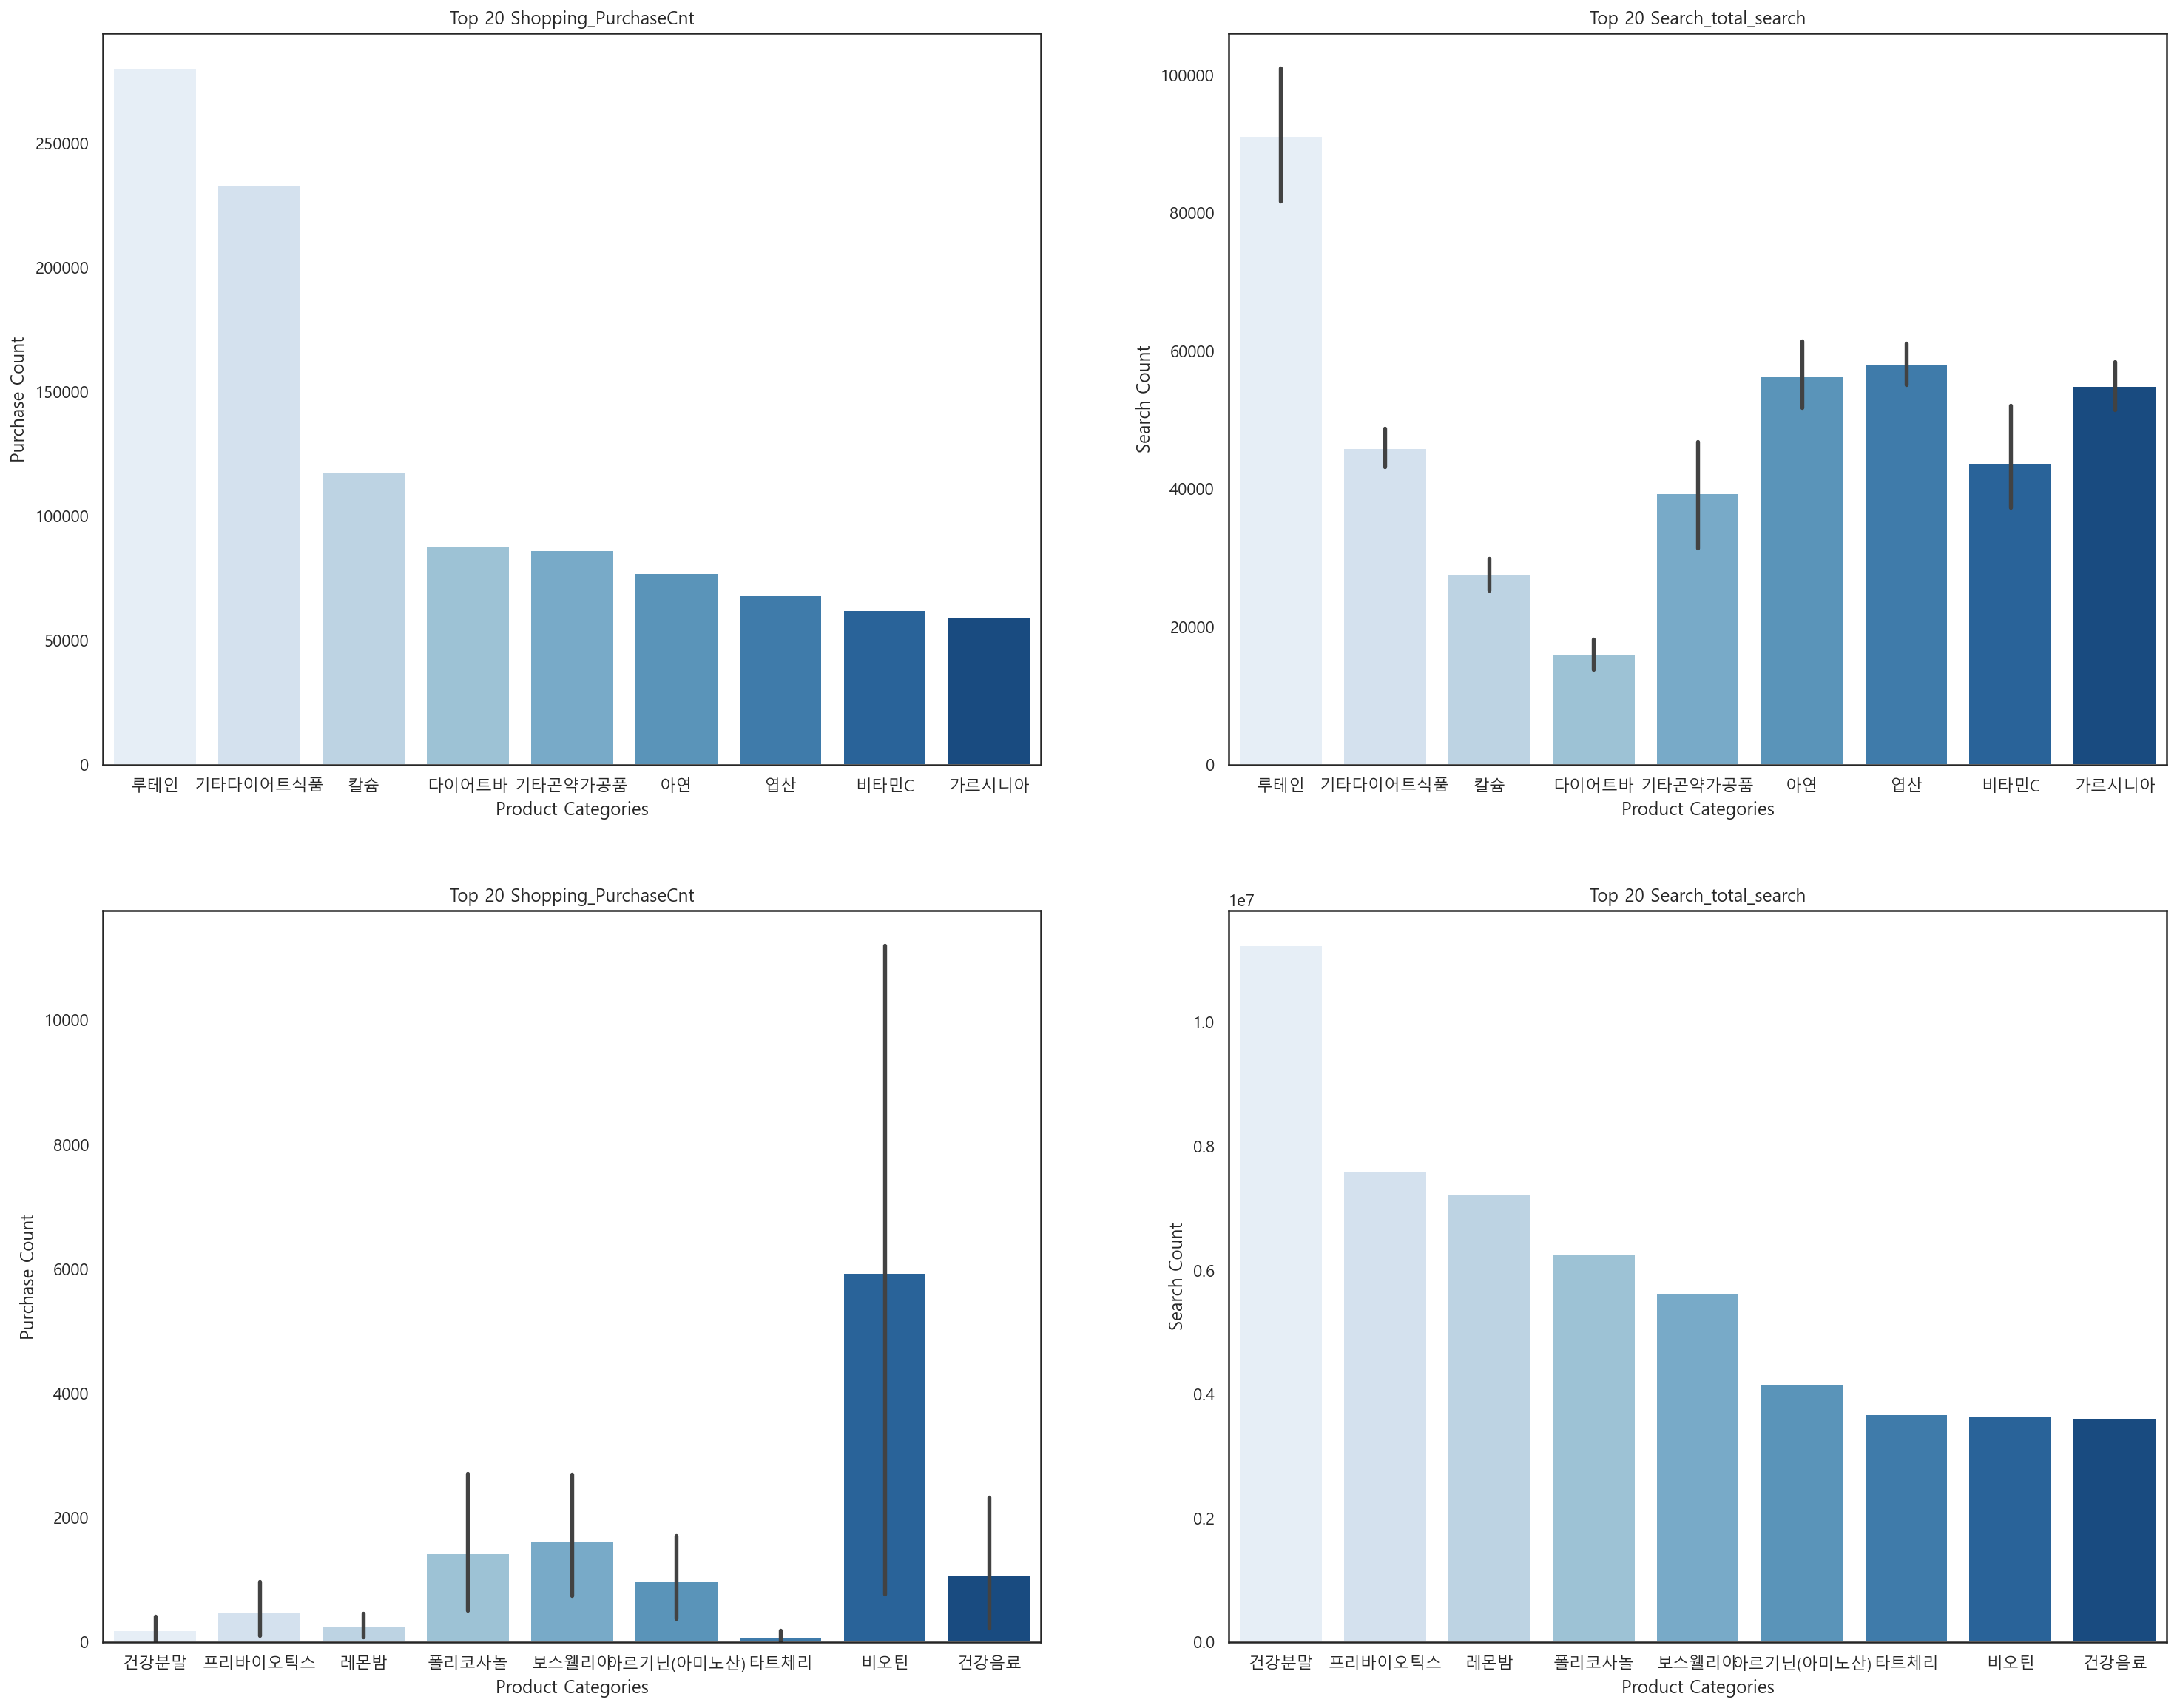

In [134]:
plt.figure(figsize=(25,20))
plt.subplot(221)
sns.barplot(x=top_10_non_common1["cate_5"], y=top_10_non_common1["purchaseCnt"], data=top_10_non_common1, palette='Blues')
plt.title('Top 20 Shopping_PurchaseCnt')
plt.xlabel('Product Categories')
plt.ylabel('Purchase Count')

plt.subplot(222)
sns.barplot(x=masking_shopping["cate_5"], y=masking_shopping["total_search"], data=masking_shopping, palette='Blues', order=["루테인", "기타다이어트식품","칼슘", "다이어트바","기타곤약가공품","아연", "엽산", "비타민C", "가르시니아"])
plt.title('Top 20 Search_total_search')
plt.xlabel('Product Categories')
plt.ylabel('Search Count')

plt.subplot(223)
sns.barplot(x=masking_searching["cate_5"], y=masking_searching["purchaseCnt"], data=masking_searching, palette='Blues', order=["건강분말", "프리바이오틱스","레몬밤", "폴리코사놀","보스웰리아","아르기닌(아미노산)", "타트체리", "비오틴", "건강음료"])
plt.title('Top 20 Shopping_PurchaseCnt')
plt.xlabel('Product Categories')
plt.ylabel('Purchase Count')

plt.subplot(224)
sns.barplot(x=top_10_non_common2["cate_5"], y=top_10_non_common2["total_search"], data=top_10_non_common2, palette='Blues')
plt.title('Top 20 Search_total_search')
plt.xlabel('Product Categories')
plt.ylabel('Search Count')

plt.show()

##### 시각화2_ 상위 10개 제품의 가격과 검색량
- 구매 랭크 10위 제품들의 평균 가격과 검색량
- 구매 랭크 하위 10위 제품들의 평균 가격과 검색량

(1) 상위 10개 제품은 가격은 높고 비교적 검색량은 낮다

(2) 하위 10개 제품은 가격은 낮지만 검색량은 제각각이다

-> 가격이 구매에 영향을 주지 않는다

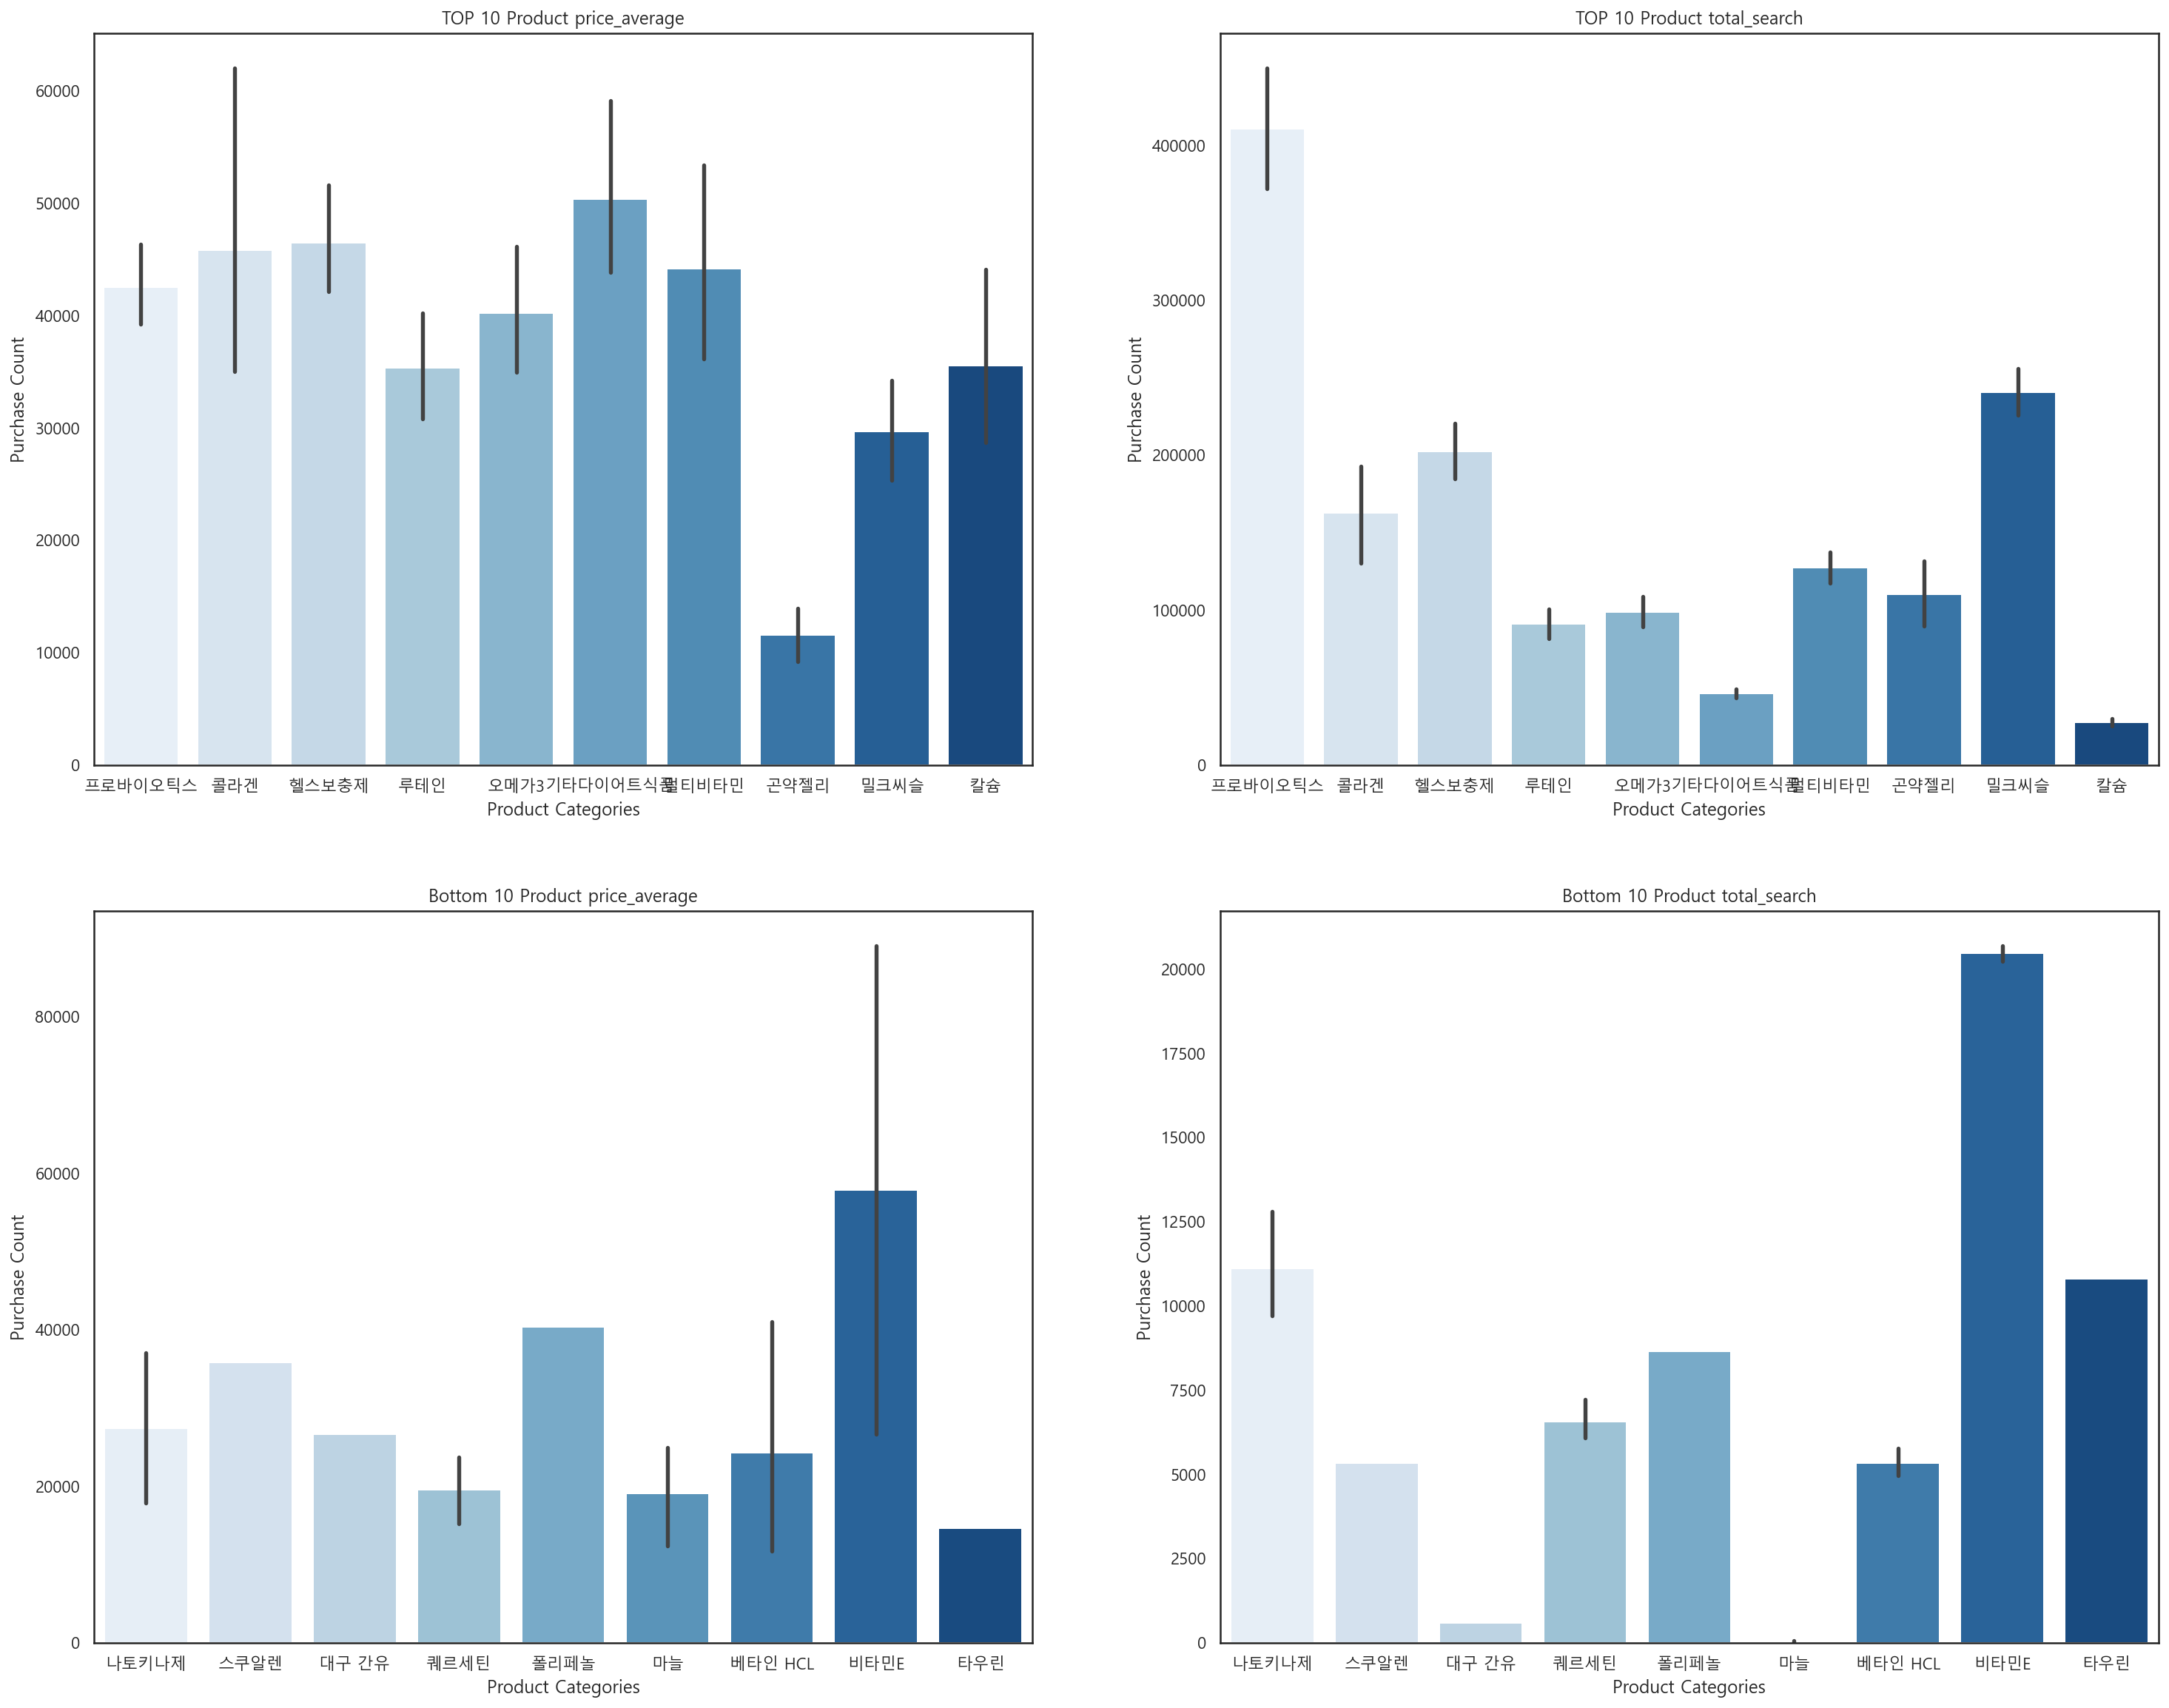

In [135]:
plt.figure(figsize=(25,20))

plt.subplot(221)
sns.barplot(x=top10["cate_5"], y=top10["price_avg"], data=top10, palette='Blues')
plt.title('TOP 10 Product price_average')
plt.xlabel('Product Categories')
plt.ylabel('Purchase Count')

plt.subplot(222)
sns.barplot(x=top10["cate_5"], y=top10["total_search"], data=top10, palette='Blues')
plt.title('TOP 10 Product total_search')
plt.xlabel('Product Categories')
plt.ylabel('Purchase Count')

plt.subplot(223)
sns.barplot(x=bottom10["cate_5"], y=bottom10["price_avg"], data=bottom10, palette='Blues')
plt.title('Bottom 10 Product price_average')
plt.xlabel('Product Categories')
plt.ylabel('Purchase Count')

plt.subplot(224)
sns.barplot(x=bottom10["cate_5"], y=bottom10["total_search"], data=bottom10, palette='Blues')
plt.title('Bottom 10 Product total_search')
plt.xlabel('Product Categories')
plt.ylabel('Purchase Count')

plt.show()

###### 제품 랭크에 따른 리뷰수와 검색수 비교
- 구매 랭크 10위 제품들의 리뷰수와 검색수
- 구매 랭크 하위 10위 제품들의 리뷰수와 검색수


(1) 상위 10개 제품은 리뷰수가 비교적 많고, 검색수 그래프도 비교적 비슷하다

(2) 하위 10개 제품은 상위 제품에 비해 리뷰수가 비교적 적고, 검색수 그래프는 현지히 적다

(3) 상위 20개 제품중, 쇼핑에서만 랭크에 들어가 있는 제품은 리뷰수도 많고 검색수도 비슷하다

(4) 상위 20개 제품중, 검색에서만 랭크에 들어가 있는 제품은 리뷰수는 적고 검색수는 비교적 많다

-> 잘 팔리는 제품들은 리뷰수가 많은 경우가 많고, 검색수도 비슷하지만
-> 잘 팔리지 않는 제품들은 리뷰수가 적은 경우가 많고 검색수도 적다

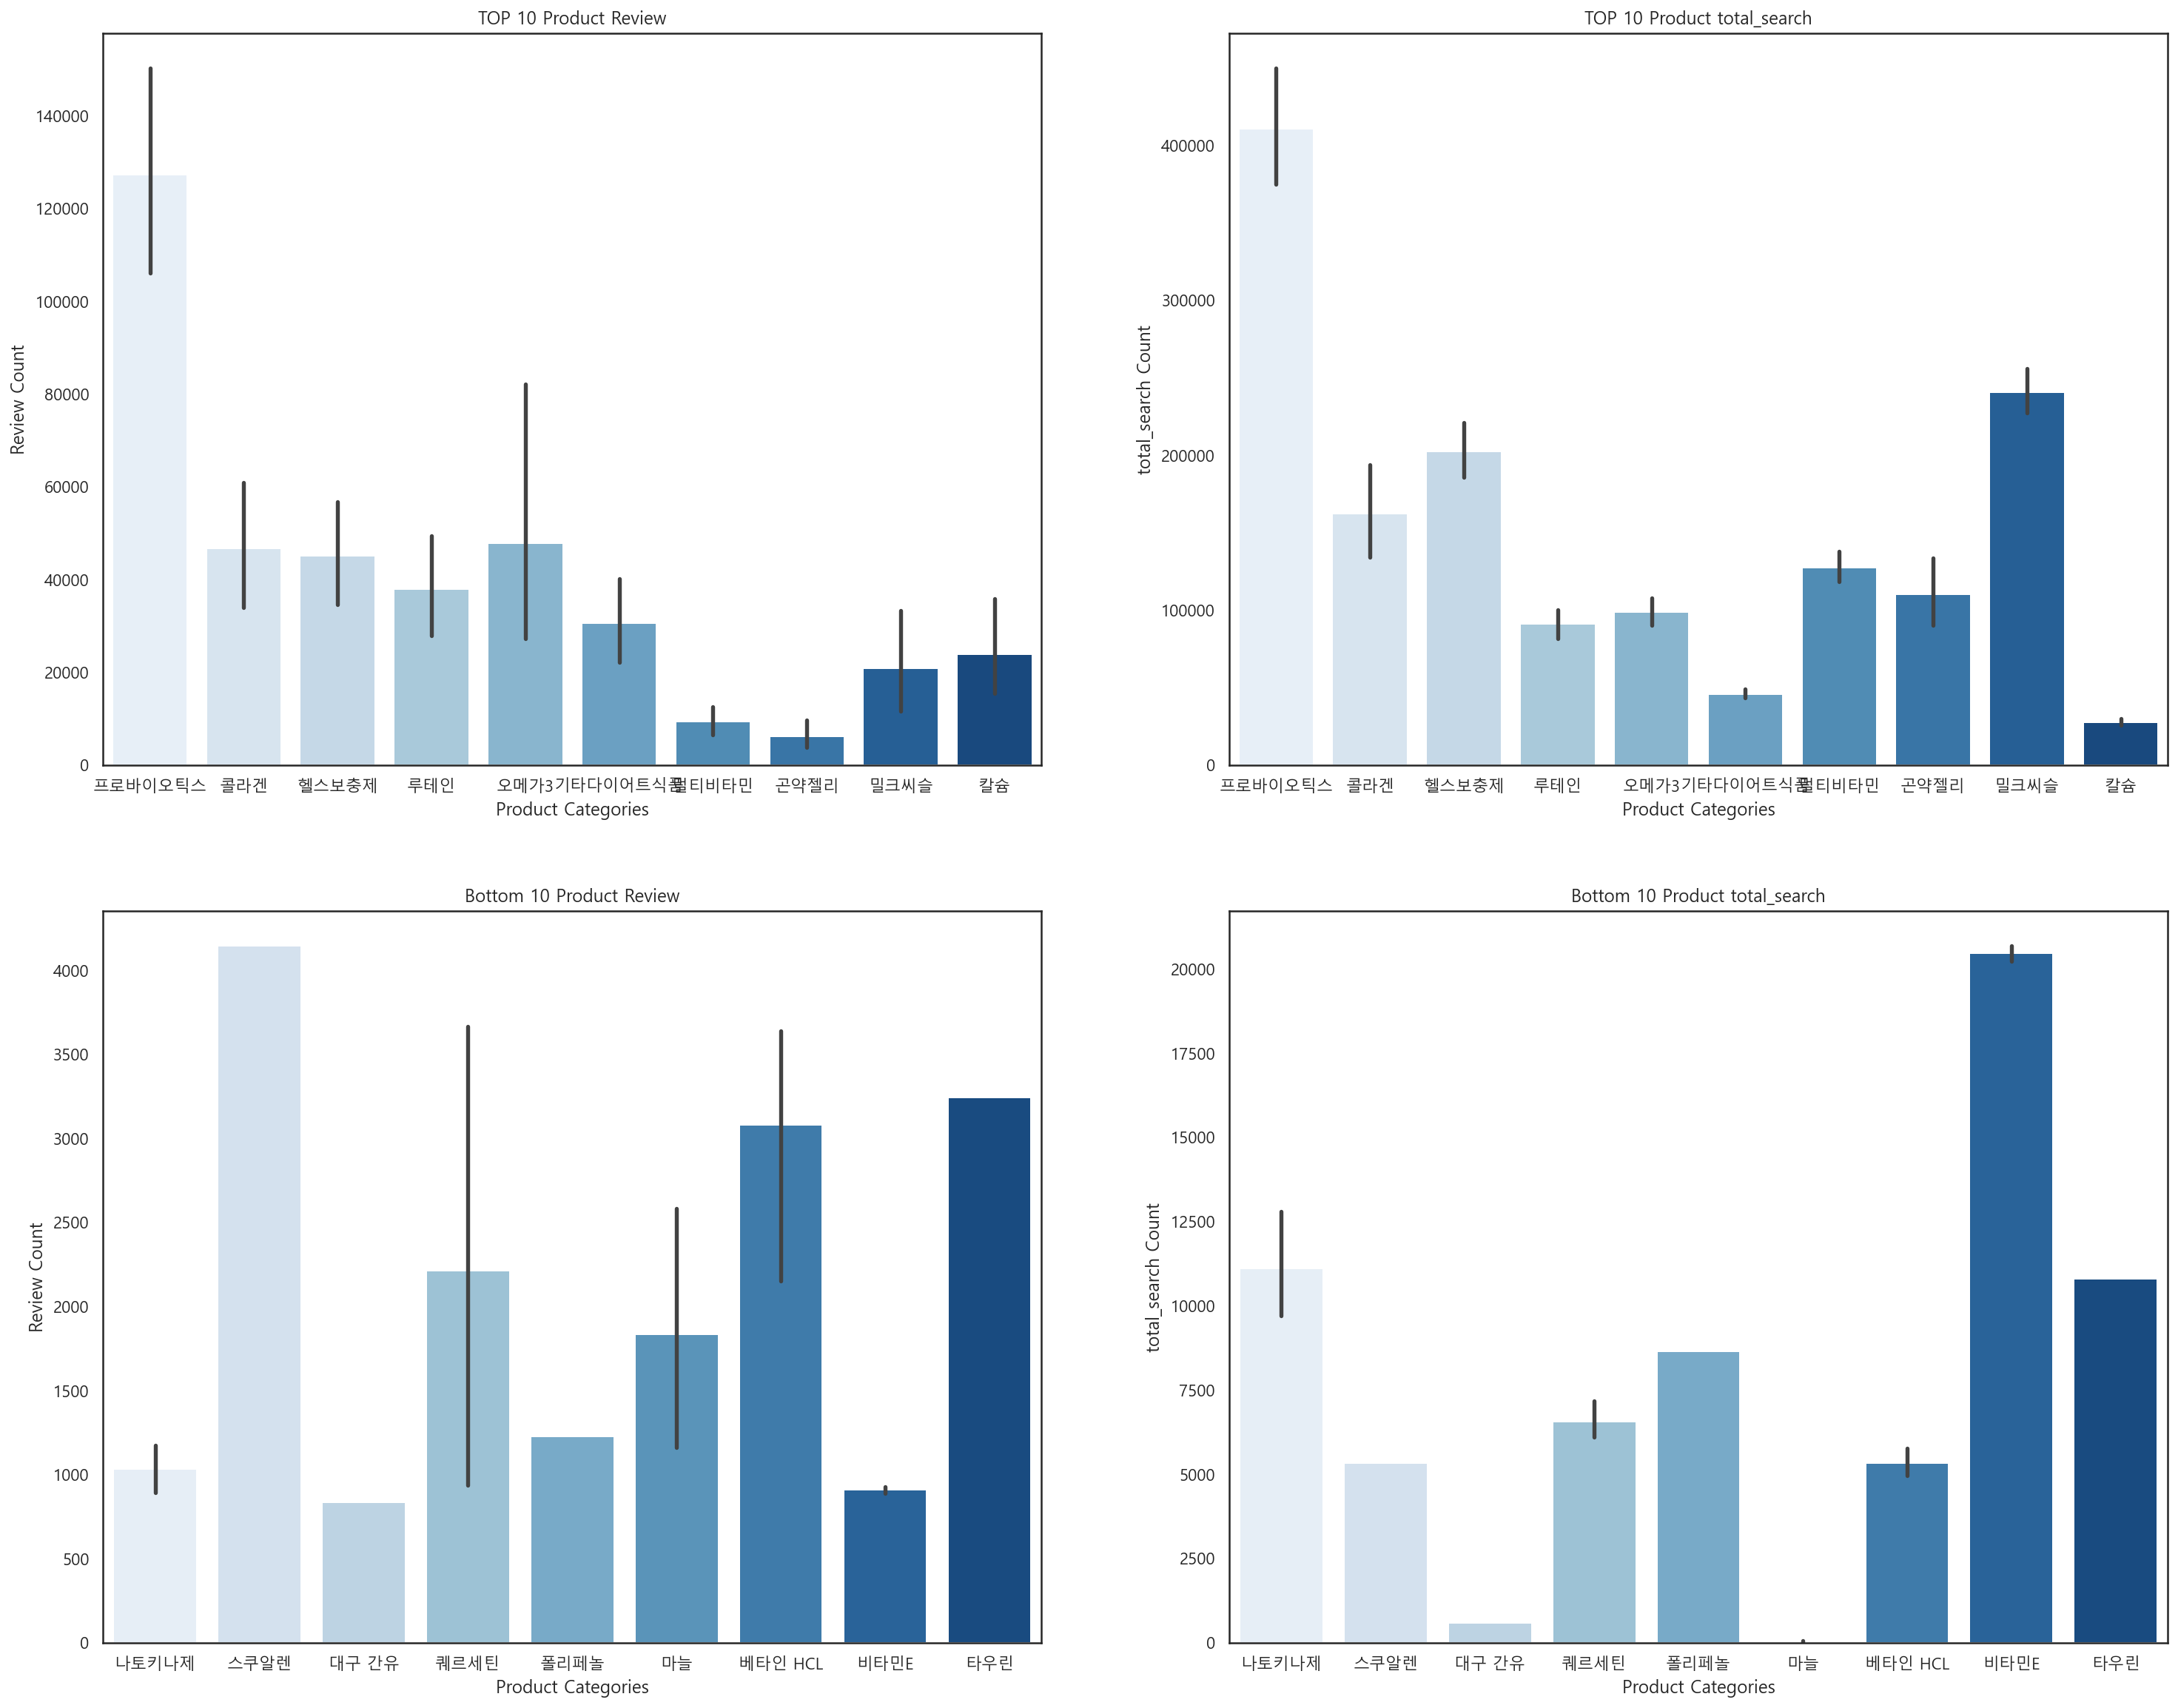

In [136]:
plt.figure(figsize=(25,20))

plt.subplot(221)
sns.barplot(x=top10["cate_5"], y=top10["review"], data=top10, palette='Blues')
plt.title('TOP 10 Product Review')
plt.xlabel('Product Categories')
plt.ylabel('Review Count')

plt.subplot(222)
sns.barplot(x=top10["cate_5"], y=top10["total_search"], data=top10, palette='Blues')
plt.title('TOP 10 Product total_search')
plt.xlabel('Product Categories')
plt.ylabel('total_search Count')

plt.subplot(223)
sns.barplot(x=bottom10["cate_5"], y=bottom10["review"], data=bottom10, palette='Blues')
plt.title('Bottom 10 Product Review')
plt.xlabel('Product Categories')
plt.ylabel('Review Count')

plt.subplot(224)
sns.barplot(x=bottom10["cate_5"], y=bottom10["total_search"], data=bottom10, palette='Blues')
plt.title('Bottom 10 Product total_search')
plt.xlabel('Product Categories')
plt.ylabel('total_search Count')

plt.show()

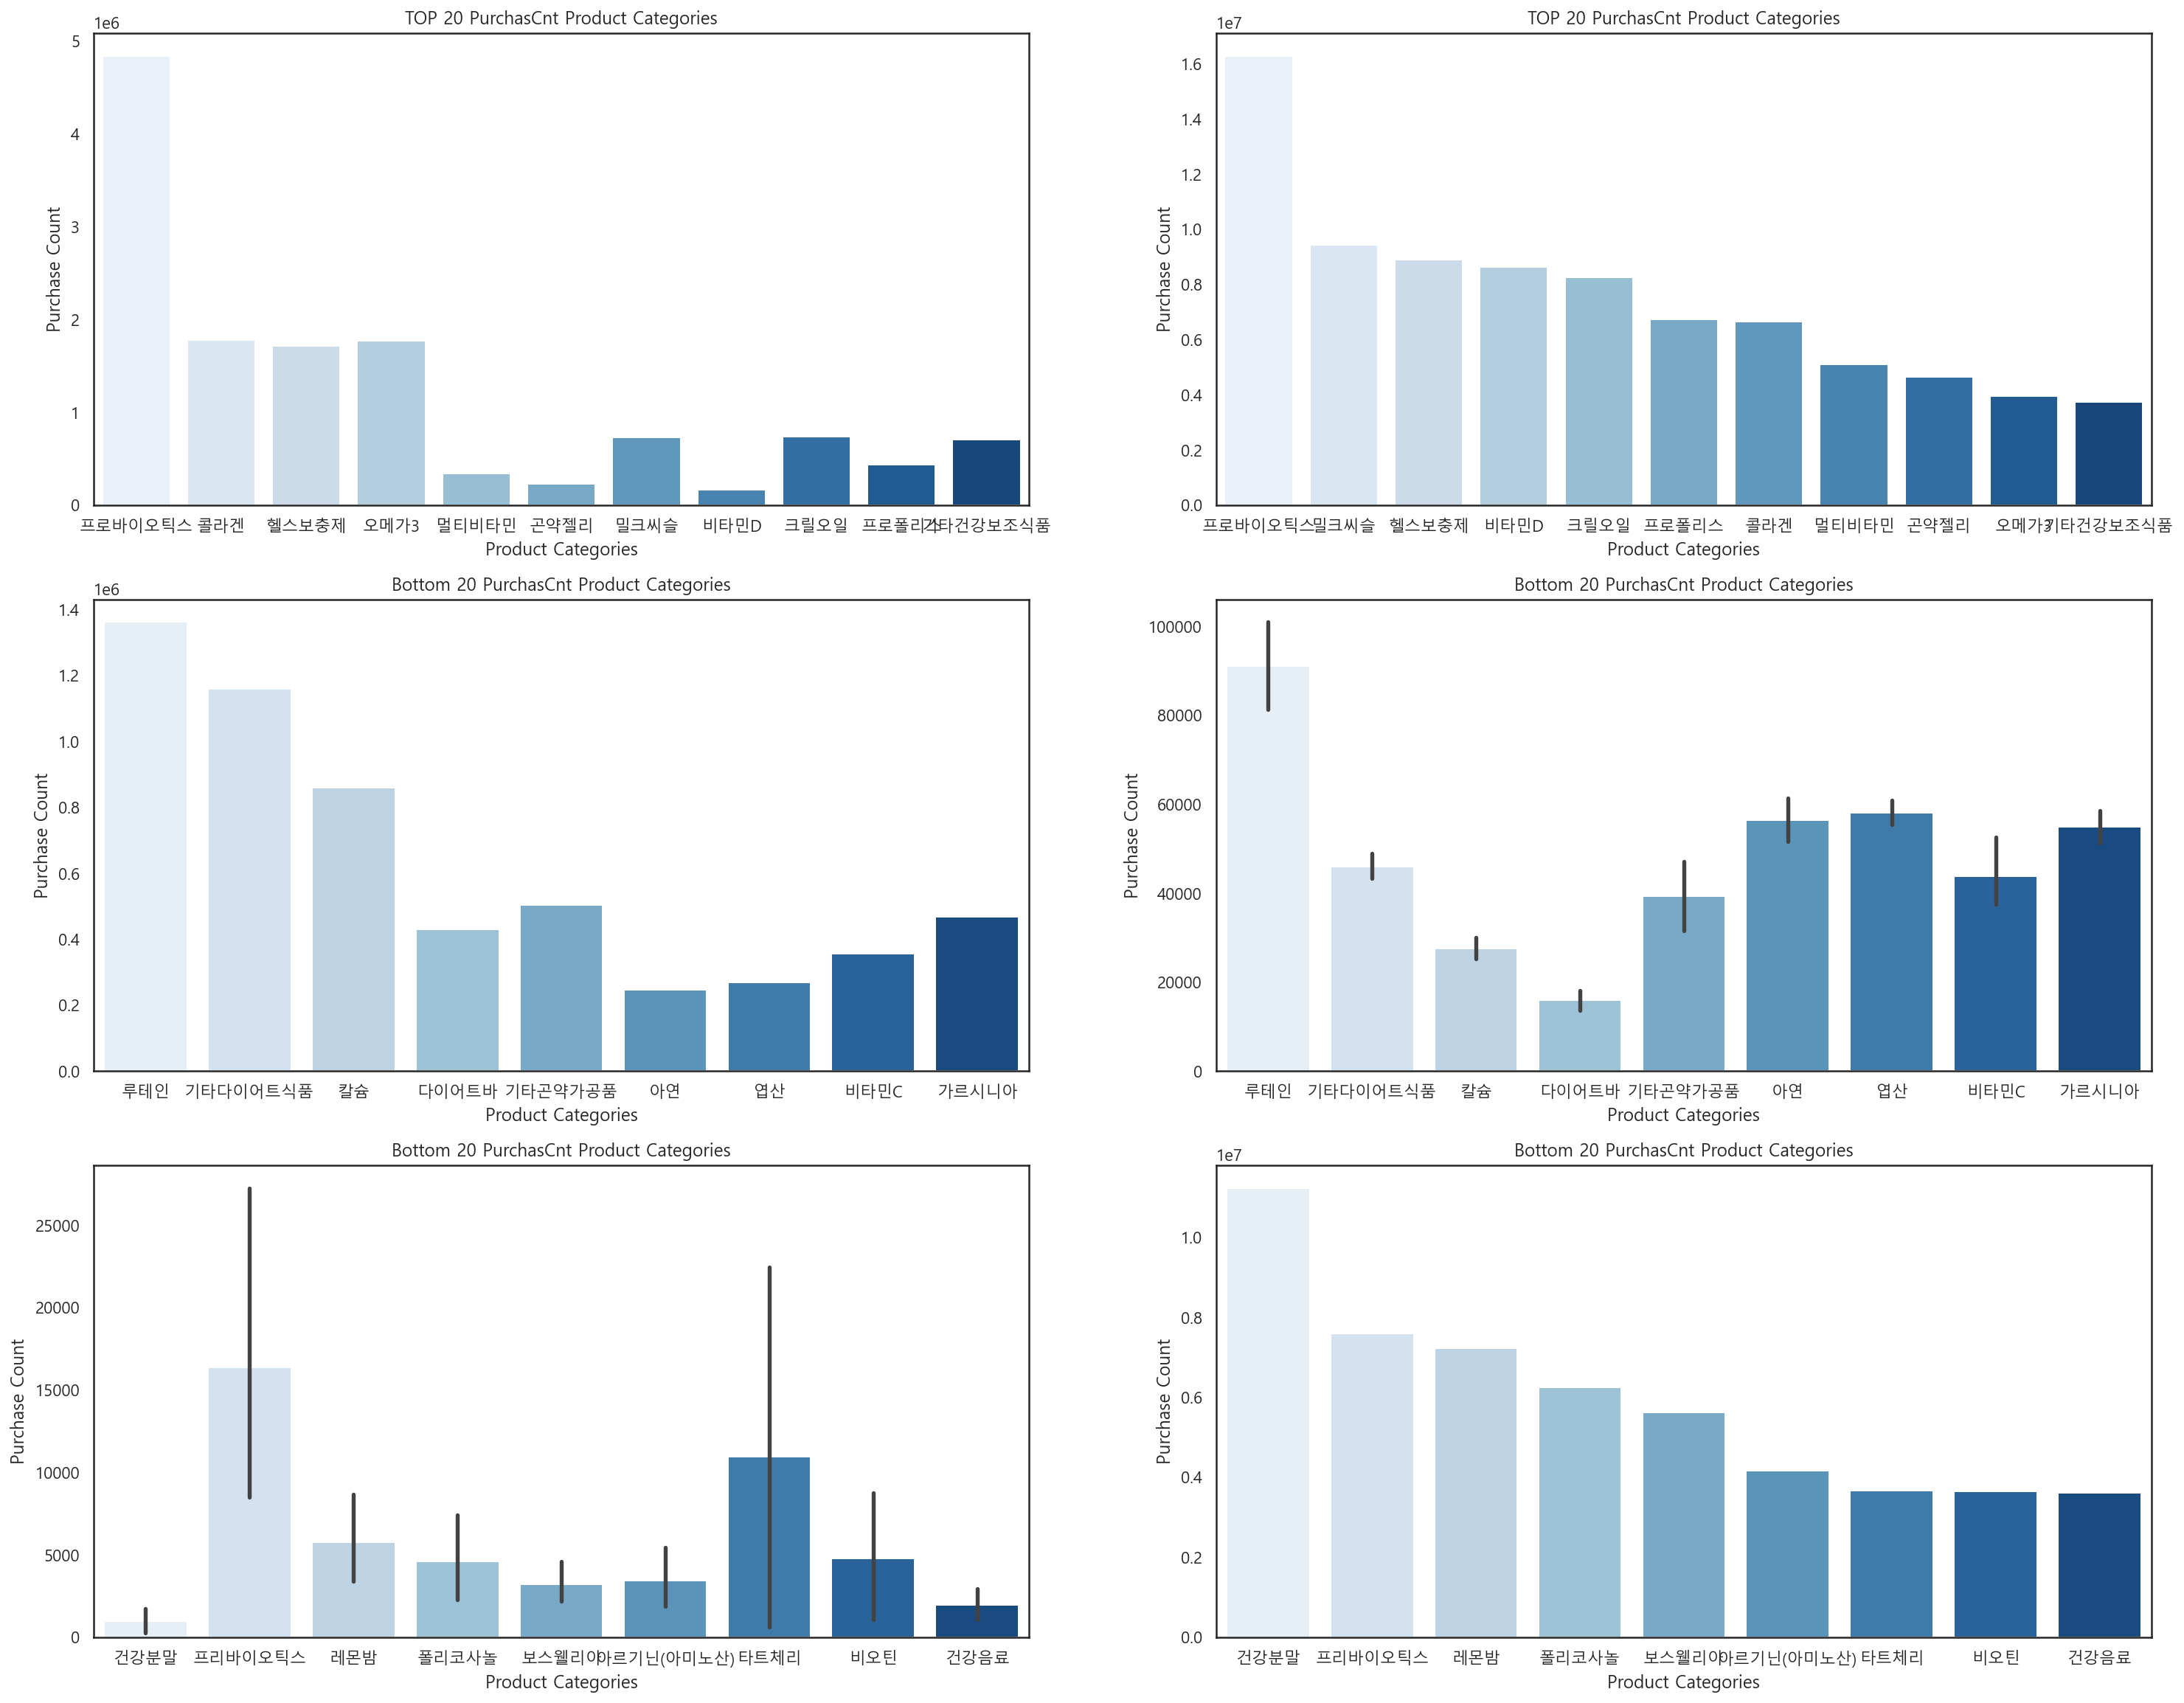

In [137]:
plt.figure(figsize=(25,20))

plt.subplot(321)
sns.barplot(x=top_10_common1["cate_5"], y=top_10_common1["review"], data=top_10_common1, palette='Blues')
plt.title('TOP 20 PurchasCnt Product Categories')
plt.xlabel('Product Categories')
plt.ylabel('Purchase Count')

plt.subplot(322)
sns.barplot(x=top_10_common2["cate_5"], y=top_10_common2["total_search"], data=top_10_common2, palette='Blues')
plt.title('TOP 20 PurchasCnt Product Categories')
plt.xlabel('Product Categories')
plt.ylabel('Purchase Count')

plt.subplot(323)
sns.barplot(x=top_10_non_common1["cate_5"], y=top_10_non_common1["review"], data=top_10_non_common1, palette='Blues', order=["루테인", "기타다이어트식품","칼슘", "다이어트바","기타곤약가공품","아연", "엽산", "비타민C", "가르시니아"])
plt.title('Bottom 20 PurchasCnt Product Categories')
plt.xlabel('Product Categories')
plt.ylabel('Purchase Count')

plt.subplot(324)
sns.barplot(x=masking_shopping["cate_5"], y=masking_shopping["total_search"], data=masking_shopping, palette='Blues', order=["루테인", "기타다이어트식품","칼슘", "다이어트바","기타곤약가공품","아연", "엽산", "비타민C", "가르시니아"])
plt.title('Bottom 20 PurchasCnt Product Categories')
plt.xlabel('Product Categories')
plt.ylabel('Purchase Count')

plt.subplot(325)
sns.barplot(x=masking_searching["cate_5"], y=masking_searching["review"], data=masking_searching, palette='Blues', order=["건강분말", "프리바이오틱스","레몬밤", "폴리코사놀","보스웰리아","아르기닌(아미노산)", "타트체리", "비오틴", "건강음료"])
plt.title('Bottom 20 PurchasCnt Product Categories')
plt.xlabel('Product Categories')
plt.ylabel('Purchase Count')

plt.subplot(326)
sns.barplot(x=top_10_non_common2["cate_5"], y=top_10_non_common2["total_search"], data=top_10_non_common2, palette='Blues', order=["건강분말", "프리바이오틱스","레몬밤", "폴리코사놀","보스웰리아","아르기닌(아미노산)", "타트체리", "비오틴", "건강음료"])
plt.title('Bottom 20 PurchasCnt Product Categories')
plt.xlabel('Product Categories')
plt.ylabel('Purchase Count')

plt.show()

###### 시각화 4_ 살펴본 내용 정리
(1) 잘 팔리는 제품 상위 10개 
    - 구매건수도 많고, 리뷰도 비슷한 그래프를 보이며, 평균 가격은 높고, 검색수도 비교적 많다
    
(2) 잘 팔리지 않는 제품 10개
    - 구매건수는 없고, 리뷰와 검색수도 적지만 평균 가격도 낮다

- 가격은 구매에 큰 영향을 미치지 않는다
(가격이 비싸거나 저렴하다고 구매건수가 많거나 적지 않다)
- 검색량이 많다면 대체로 잘 팔리는 상품일 확률이 높다

- 구매가 많은 제품들은
(1) 검색수가 많고
(2) 리뷰수가 많다

- 구매가 적은 제품들은
(1),(2)가 적다

- 가격은 구매에 영향을 주지 않을 확률이 높다

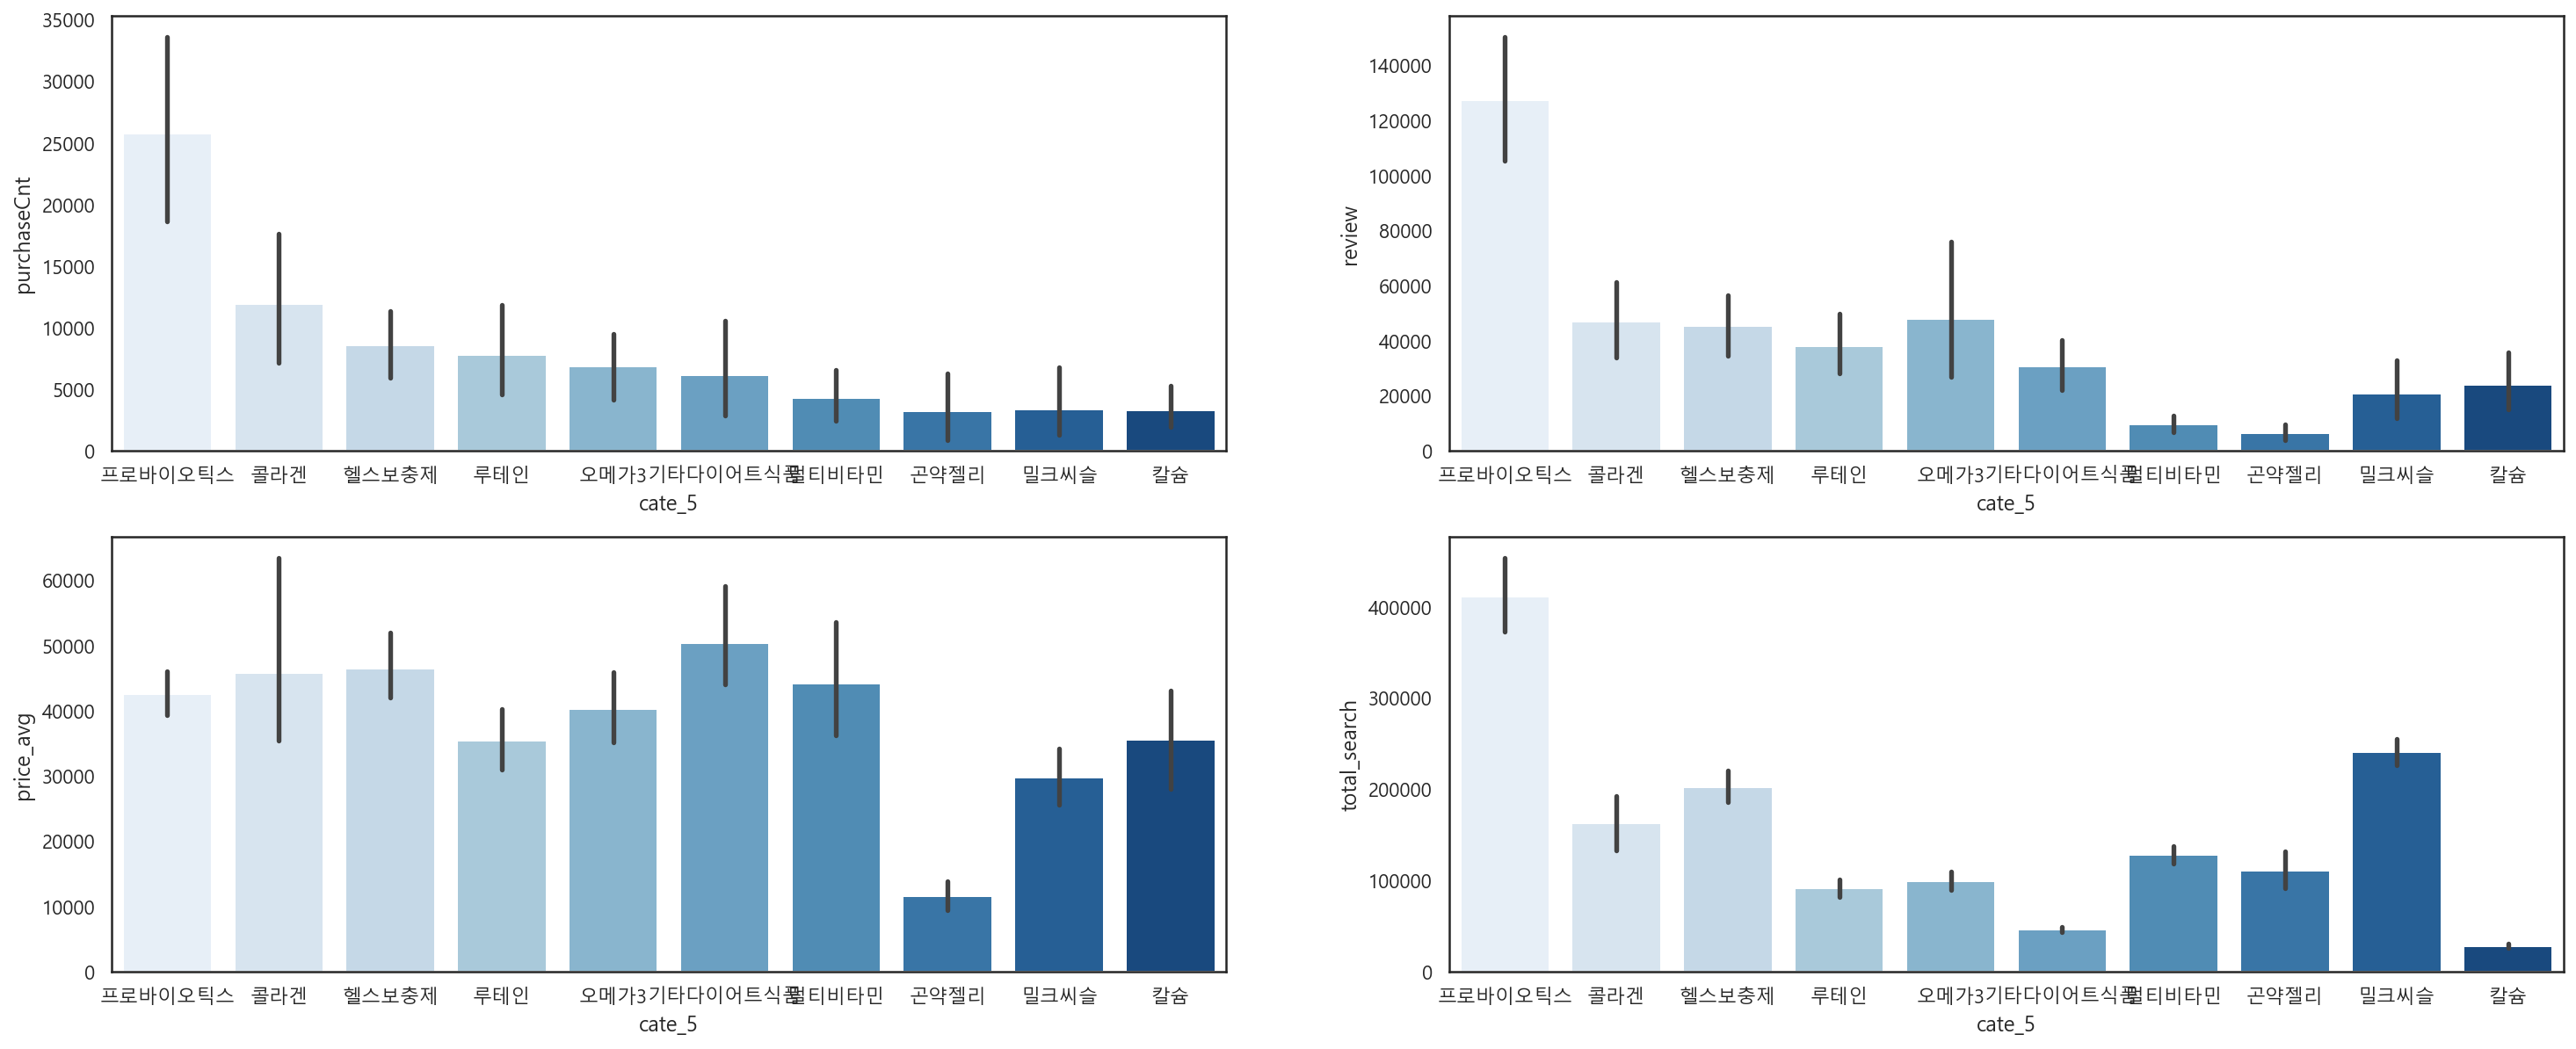

In [138]:
plt.figure(figsize=(25,10))
plt.subplot(221)
sns.barplot(data=top10, x="cate_5", y="purchaseCnt", palette='Blues')
plt.subplot(222)
sns.barplot(data=top10, x="cate_5", y="review", palette='Blues')
plt.subplot(223)
sns.barplot(data=top10, x="cate_5", y="price_avg", palette='Blues')
plt.subplot(224)
sns.barplot(data=top10, x="cate_5", y="total_search", palette='Blues')

plt.show()

plt.figure(figsize=(25,10))
plt.subplot(221)
sns.barplot(data=bottom10, x="cate_5", y="purchaseCnt", palette='Blues')
plt.subplot(222)
sns.barplot(data=bottom10, x="cate_5", y="review", palette='Blues')
plt.subplot(223)
sns.barplot(data=bottom10, x="cate_5", y="price_avg", palette='Blues')
plt.subplot(224)
sns.barplot(data=bottom10, x="cate_5", y="total_search", palette='Blues')

plt.show()